# Header

File: 
	figformat.py

Summary Description:
	Program for formatting data in Python consistently across multiple figures
	Use this file, along with the specified .mplstyle file to format figures.
		Benefits: Latex words, consistent and adjustable spacings/fonts. 
		
Info:
	Version 1.0
	Thomas Hartke
	1/8/2018

Usage:
	Put this file with .mplstyle file and any other datafiles in the same folder.
	Run this file in python, it will automatically load .mplstyle. 
	If you want to make style changes, they are made in global variable definitions 
		(approximately lines 50-100 of this file) or the .mplstyle file. 
		Make sure to maintain consistency within a paper/talk. 
		For a full list of possible changes, you have to read through the globals yourself. 
	Specific data and images can be loaded in the data loading section. 
	Detailed formatting (not global) is made in the figure creation section	
		For each subplot, you can:
			Insert data waves with error bars, select colors/symbols. 
			Add a legend (automatic formatting according to global style)
			Choose tick mark locations (choose a rule) and margins between data and axes 
			and label axes. 
			Insert arbitrary png images at full resolution at specific places in aubplots.
			Insert customizable arrows from those images to specific datapoints. 
		Almost all of these commands are fed global style controls, so they will be
			updated when you update the global formatting. They also generally avoid
			hard coding in locations (ie. inserted images are located at a relative 
			location within the subplot, not a datapoint (although you could do that if you wanted). 

Dependencies:
	Requires various python packages
	Requires Latex to be installed and functional 
		(if compilation fails, might be tricky to sort out. 
		You can turn off latex in .mplstyle file to debug.)
			
File outline:
	Import libraries
	Make sure correct style file is set up (contains additional specifications)
	Specify other global style variables (sizes, etc.)
	Define a few functions
	Load in data
	Load in images
	Plot figure
	For subplot in figure :
	   Plot data, error bars, color, symbols, etc.
	   Add a legend if desired. 
	   Set axis labels, tick marks, and subplot index label
	   Optionally add images and arrows
	Save figure as pdf

# Setup and Function Definitions 

In [1]:
import numpy as np
import os.path as path
import os, shutil
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from datetime import datetime
from astropy.io import fits
import scipy
import scipy.optimize
from scipy.ndimage import  rotate
from scipy import interpolate
# from jplot import *
# from jfit import *
import pandas as pd
import sys
import csv
import glob

########## Set up the correct style file for matplotlilb.
# Important: Style file of the correct name should be in current working directory.
cwd = os.getcwd()
rcdirectory = matplotlib.get_configdir()
stylefilename = 'fermi2style'
filename = stylefilename + '.mplstyle'
absdirfile = os.path.join(cwd, filename)
absdirwrite = os.path.join(rcdirectory, 'stylelib', filename)
direxists = os.path.join(rcdirectory, 'stylelib') # need to check subfolder exists, if not, create it. 
if not os.path.exists(direxists):
	os.makedirs(direxists)
rcfile = open(absdirwrite,'wb')
stylefile = open(absdirfile, 'rb')
rcfile.write(stylefile.read())
rcfile.close()
stylefile.close()      

In [2]:
########## Choose the file style and global style variables to use
plt.style.use(stylefilename) # This means you use the style file you specified. 
# print(plt.style.available) # If you want to see whether style file is being corretly loaded. 
# set up other style choices that can't be included in the .mplstyle file.
# A few more specific plotting style choices (global variables)
globalDPI = 600
egslinewidth = 0.75
egscapsize = 0.0
egscapthick = 0.0
errorbar_global_style = { # a dictionary, insert in plt.errorbar() function with **error_global_style)
        'linewidth' : egslinewidth, # horizontal width of vertical part of bar. 
        'capsize'   : egscapsize,   # horizontal width of horizontal part of bar. 
        'capthick'  : egscapthick, # vertical width of horizontal part of bar. 
}
pgslinewidth = 0.75
pgsmarkersize = 3
pgsmarkeredgewidth = 0.5
pgszorder = 3
plot_global_style = { # a dictionary, insert in plt.errorbar() function with **error_global_style)
        'linewidth'         : pgslinewidth, # linewidth of lines when plotting with '-' and so on.
        'markersize'        : pgsmarkersize, # size of markers when using plot commands like 'o'
        'markeredgewidth'   : pgsmarkeredgewidth,
		'zorder'			: pgszorder, # sets the points to be plotted on top
}
# Parameters for the subplot label (a) (b) and so on. 
subplotlabeloffset = (-19,-6.5) # number of points in plotting units from top left of each subplot.
subplotlabeloffsetinside= (2.2,-1.9)
subplotlabelfontsize = 'small'
# Axis and Tick parameters
label_globalpad = 1.0 # points between axis and labels of tick marks
xaxisMaxNumTicks = 6 # default global number of ticks set. Ultimately doesn't have to be anything specific. 
yaxisMaxNumTicks = 6 # These can both change subplot to subplot
# Set the plot size of the figure. 
golden_mean = (np.sqrt(5)-1.0)/2.0         	# Aesthetic ratio
fig_width = (3 + 3.0/8.0)   			# width in inches # Column width in PRL
fig_height = fig_width*golden_mean     	# height in inches + a bit for text and such. 
# Old single column figure width and height for scaling purposes. 
fig_reference_width = (3 + 3.0/8.0)
fig_reference_height = ((3 + 3.0/8.0)*(np.sqrt(5)-1.0)/2.0*1.4)
fig_size = [fig_width,fig_height]               # This variable will be used in the figure creation command
# Set arrow format parameters (used in function above)
arrowwidth = 0.5
arrowheadwidth = 2.0
arrowheadlength= 4.0
arrowedgecolor = 'none'
arrowfacecolor= 'black'
arrowshrink = 0.1
# Set the formatting parameters for dashed lines
dashedlinestyle = (0, (1.5,1.5)) # means 0 offset, 1 point on, 2 points off. 
dashedlinestyle2 = (0, (0.75,1.5,4.5,1.5)) # means 0 offset, 1 point on, 2 points off. 
# Now define our color pallete. set color = xcolor[i] for example in plotting functions.
# from http://ksrowell.com/blog-visualizing-data/2012/02/02/optimal-colors-for-graphs/
cscale=0.35;
xedgecolors = np.array([
[0,0,1],
[0,0,0],
[1,0,0],
[0,1,0],
[0,1,1],
[1,1,0],
[1,0,1],
[0.5,0.5,0.5]
])
xcolors = xedgecolors + (1-xedgecolors)*cscale
# gold color from fermion atom image: Light, R: 249 G: 167 B: 82, dark R: 239 G: 124 B: 9
# cscale =1.4;
# xcolors = np.array([
# 		[75/255.*cscale	,	75/255.*cscale		,	254/255.	], #light blue 
#         [83/255.*cscale  	,	81/255.*cscale  	,	84/255.*cscale  	], #light grey
# 		[254/255.	,	90/255.*cscale	 	,	90/255.*cscale	 	], #light red 
# 		[249/255.	,	167/255.*cscale	,	82/255.*cscale 	],  #light gold
#         [144/255.*cscale	,	103/255.*cscale 	,	157/255.*cscale	], #light purple 
# 		[225/255.	,	151/255.*cscale	,	76/255.*cscale 	], #light orange 
# 		[204/255.	,	194/255.	,	16/255.*cscale 	], #light yellow 
# 		[132/255.*cscale 	,	186/255.*cscale	,	91/255.*cscale 	] #light green 
# 		])
# # Old xcolors 
# # xcolors = np.array([
# # 		[75/255.	,	75/255.		,	254/255.	], #light blue 
# #         [83/255.  	,	81/255.  	,	84/255.  	], #light grey
# # 		[254/255.	,	90/255.	 	,	90/255.	 	], #light red 
# # 		[249/255.	,	167/255.	,	82/255. 	],  #light gold
# #         [144/255.	,	103/255. 	,	157/255.	], #light purple 
# # 		[225/255.	,	151/255.	,	76/255. 	], #light orange 
# # 		[204/255.	,	194/255.	,	16/255. 	], #light yellow 
# # 		[132/255. 	,	186/255.	,	91/255. 	] #light green 
# # 		])
# xedgecolors = np.array([
# 		[0/255.		,	0/255.		,	254/255.	], #blue 
# 		[0/255.  	,	0/255.  	,	0/255.  	], #black
# 		[254/255.	,	0/255.	 	,	0/255.	 	], #red 
#         [239/255.	,	124/255.	,	 9/255. 	],  #gold
#         [107/255.	,	76/255. 	,	154/255.	], #purple
# 		[218/255.	,	124/255.	,	48/255. 	], #orange
# 		[148/255.	,	139/255.	,	61/255. 	], #yellow
#         [62/255. 	,	150/255.	,	81/255. 	] #green  
# 		])
# # gold color from fermion atom image: Light, R: 249 G: 167 B: 82, dark R: 239 G: 124 B: 9

# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
# Good ones: 

In [3]:
########## Define a few functions (some of which use global variables from above)

# Function for reading in the data from a .csv file.
# This function assumes comma separated values, and
# (IMPORTANT) assumes first row is words specifying the data name (if saved from an Igor table, this is true)
def csv_to_dict(fileloc):
#This code takes a CSV file and returns a DICTIONARY with key given by the
#header and a list of all values after it. It trys to convert it to a number
#otherwise just appends the string
	reader = csv.DictReader(open(fileloc,'r'))
	dictionary = {}
	for each_line_dict in reader:
		line_dictionary = dict(each_line_dict)	#each_line_dict are type OrderedDict
		for column, value in line_dictionary.items():
			if column in dictionary:
				if value == '':
					continue
				try:
					value = float(value)
				except:
					pass
				dictionary[column].append(value)
			else:
				if value == '':
					continue
				try:
					value = float(value)
				except:
					pass
				dictionary[column] = [value,]
	return dictionary

# Function for reading in the data from a .csv file.
# This function assumes comma separated values, and
# (IMPORTANT) assumes first row is words specifying the data name (if saved from an Igor table, this is true)
# and lastly assumes all columns of data have same length (if not, it breaks, see if statement below).
def readCSVFileData(datafilename) : 
        # Returns 1 LARGE ARRAY containing the data, ignores the names at the beginning.
        with open(datafilename, 'r') as csvDataFile:
                csvFileContent = csv.reader(csvDataFile)
                headers = next(csvFileContent)
                numdatasets = len(headers)
                dataarr = np.ndarray(shape = (0,numdatasets))
                for row in csvFileContent :
                        if '' in row :
                                continue # skip if any of the data waves is an empty wave. 
                        else :
                                rowtemp = [row]
                                dataarr = np.concatenate((dataarr,rowtemp), axis = 0)
                dataarr = dataarr.astype(float)
        return headers, dataarr ; # headers is row of names.
# Read with no header 
def readCSVFileData_NoHeader(datafilename) :
        # Returns 1 large array containing the data, ignores the names at the beginning.
    with open(datafilename, 'r') as csvDataFile:
        csvFileContent = csv.reader(csvDataFile)
        datatemparr = list(csvFileContent)
        dataarr = np.asarray(datatemparr).astype(float)
        return dataarr
# Function for plotting Images in a subplot relative coordinates.
# important thing is that imgplotname has to be an initialized axes instance before this. 
def plotImgInSubplot(spname, imgplotname, imgname, relx, rely, relwidth, relheight, **kwargs) :
        # anchor is an optional kwargs parameter. 
		   # can be 'SW', NW, NE, SE (what corder to push image to in its bounding box.
        # spname is subplot you are plutting image in.
        # imgplotname is name of axes object you created directly before (so you are still editing it)
        # calling this function, and which you will put the image in.
        # imgname is name of image you loaded and want to place there. 
        spnameloc = spname.get_position() # finds the position of subplot in axes fraction coordinates (of figure)
        imgplotlocator = [spnameloc.x0 + spnameloc.width*relx, spnameloc.y0 + spnameloc.height*rely,
                  spnameloc.width*relwidth, spnameloc.height*relheight ]
                  # Actual location coordinates in figure axes relative units
        imgplotname.set_position(imgplotlocator, which = 'original') # move original axes location to new spot. 
        if ('anchor' in kwargs): #change the default corner in plot that image moves to. 
                imgplotname.set_aspect(aspect = 'auto', adjustable = None, anchor = kwargs['anchor']) 
				# 'anchor' should be a string. But you call it as plotImgInSubplot(blah, anchor = 'SW')
                print('Careful: nonstandard anchor Parameter set. See plotImgInSubplot() function.')
        else :
                imgplotname.set_aspect(aspect = 'auto', adjustable = None, anchor = 'SW')  # the default command. 
        # can set zorder = -1 to place behind other things)
        # anchor determines which corner of the image is locked to what part of the locator box.
        # so if locator box requires smushing image, it needs to know where to push the image to side.
        # Then rest is just sandwiched in (keeping same aspect ratio as original image
        imgplotname.imshow(imgname, interpolation = 'none') # keep native resolution 
        imgplotname.axis('off') # turn off the axis labels for images.
        
# Function to take axes labels in latex format like '$0.23$' and replace with '0.23' then replot labels
def convAxLabelSansSerif(ax_Used, which = 'both') :
    plt.draw()  #makes tick labels created as real numbers/instances, and now we can alter them. 
    if which == 'both':
        labelsx = [item.get_text().replace('$','') for item in ax_Used.get_xticklabels()] # These have latex $ $ formatting around them.
            # Remove latex formatting
        labelsy = [item.get_text().replace('$','') for item in ax_Used.get_yticklabels()] # These have latex $ $ formatting around them.
            # Remove latex formatting
        ax_Used.set_xticklabels(labelsx)
        ax_Used.set_yticklabels(labelsy)
    elif which == 'x' :
        labelsx = [item.get_text().replace('$','') for item in ax_Used.get_xticklabels()] # These have latex $ $ formatting around them.
            # Remove latex formatting
        ax_Used.set_xticklabels(labelsx)
    elif which == 'y' : 
        labelsy = [item.get_text().replace('$','') for item in ax_Used.get_yticklabels()] # These have latex $ $ formatting around them.
            # Remove latex formatting
        ax_Used.set_yticklabels(labelsy)
    else :
        None 
        
# Function to anchor graph in subplot 
def anchorGraphInSubplot(spname, graphplotname, relx, rely, relwidth, relheight, **kwargs) :
        # anchor is an optional kwargs parameter. 
		   # can be 'SW', NW, NE, SE (what corder to push image to in its bounding box.
        # spname is subplot you are plutting image in.
        # imgplotname is name of axes object you created directly before (so you are still editing it)
        # calling this function, and which you will put the image in.
        # imgname is name of image you loaded and want to place there. 
        spnameloc = spname.get_position() # finds the position of subplot in axes fraction coordinates (of figure)
        graphplotlocator = [spnameloc.x0 + spnameloc.width*relx, spnameloc.y0 + spnameloc.height*rely,
                  spnameloc.width*relwidth, spnameloc.height*relheight ]
                  # Actual location coordinates in figure axes relative units
        graphplotname.set_position(graphplotlocator, which = 'original') # move original axes location to new spot. 
        if ('anchor' in kwargs): #change the default corner in plot that image moves to. 
                graphplotname.set_aspect(aspect = 'auto', adjustable = None, anchor = kwargs['anchor']) 
				# 'anchor' should be a string. But you call it as plotImgInSubplot(blah, anchor = 'SW')
                print('Careful: nonstandard anchor Parameter set. See plotImgInSubplot() function.')
        else :
                graphplotname.set_aspect(aspect = 'auto', adjustable = None, anchor = 'SW')  # the default command. 
        # can set zorder = -1 to place behind other things)
        # anchor determines which corner of the image is locked to what part of the locator box.
        # so if locator box requires smushing image, it needs to know where to push the image to side.
        # Then rest is just sandwiched in (keeping same aspect ratio as original image
# Function to draw an arrow from some axes relative coordinate (like the bottom 
# left of image) to a datapoint, with certain format.
def arrowToData(spname, relx, rely, dpx, dpy) :
        # dpx and dpy are datapoint locations in data units.
        # relx and rely are other object (ie image) location in subplot relative axes fraction coordinates.
        # For other arrow types and formats, see https://matplotlib.org/users/annotations_guide.html
        spname.annotate("", xy=(dpx, dpy), xycoords='data',
                        xytext=(relx, rely), textcoords="axes fraction", # relative to subplot axes
                        arrowprops=dict(width = arrowwidth,
                                        headwidth = arrowheadwidth,
                                        headlength = arrowheadlength,
                                        edgecolor = arrowedgecolor,
                                        facecolor = arrowfacecolor,
                                        shrink = arrowshrink),
                        )
						# these are the chosen arrow parameters to be consistent across plotting
                        # If you want to update the arrow parameters, update them in the style area. 
# A quick function for plotting subplot labels like (a) (b) and so on.
def labelSubplot(spname, text) :
        spname.annotate(text, xy=(0,1), xycoords='axes fraction', xytext=subplotlabeloffset, 
						textcoords='offset points', verticalalignment='bottom', horizontalalignment='right', 
						fontsize=subplotlabelfontsize)
def get_aspect(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure
    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio 
    return aspect

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def convert_fname(fname):
    dt = datetime.strptime(fname, 'X%m_%d_%Y_%H_%M_%S_')
    fn = datetime.strftime(dt, '%m-%d-%Y_%H_%M_%S.fits')
    return fn

def FITSDecoder(filename):
    return fits.getdata(filename)

def plot_all(dats, plt_func, **fig_kwarg):
    ncol = int(4); nrow = int(np.ceil(len(dats)/ncol));
    fig, axs = plt.subplots(nrow, ncol, **fig_kwarg)
    
    for ii, dat in enumerate(dats):
        plt_func(axs[int(np.floor(ii/ncol)), int(ii%ncol)], dat)
        
    return fig

def show_img(ax, dat):
    ax.imshow(dat, vmax=600, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def get_rad_density(img, cm='auto'):
    if cm == 'auto': 
        center = scipy.ndimage.measurements.center_of_mass(img)
        
    y, x = np.indices((img.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), img.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def setupImgDisplay(axToSet, colSet) :
    axToSet.spines['right'].set_visible(True)
    axToSet.spines['top'].set_visible(True)
    axToSet.spines['bottom'].set_visible(True)
    axToSet.spines['left'].set_visible(True)
    plt.setp(axToSet.get_xticklabels(), visible=False)
    plt.setp(axToSet.get_yticklabels(), visible=False)
    axToSet.tick_params(axis='both', which='both', length=0)
    for spine in axToSet.spines.values():
        spine.set_edgecolor(colSet)
    return None 

# Read Data

In [4]:
# Functions for reading data
# Make a function to easily read in the correlator matrices 
def readInCorrMatrices(data_dirToUse, nameOfFilePrefix, nameOfRun, denIndValsToUse, runIndToUse,dr_maxToUse) : 
    # make array to store 2D matrices in 
    corr_mats = np.zeros((len(denIndValsToUse),2*dr_maxToUse+1,2*dr_maxToUse+1))
    corr_mats_err = np.zeros((len(denIndValsToUse),2*dr_maxToUse+1,2*dr_maxToUse+1))
    for matInd,denInd in enumerate(denIndValsToUse) : 
        corr_mats[matInd] = np.loadtxt(os.path.join(data_dirToUse, nameOfFilePrefix + nameOfRun
                                               +str(runIndToUse)+'_n_' 
                                                  + str(denInd)+'_dr_max_'
                                           +str(dr_maxToUse) + '.txt')) 
        corr_mats_err[matInd] = np.loadtxt(os.path.join(data_dirToUse, nameOfFilePrefix +'err_' + nameOfRun
                                               +str(runIndToUse)+'_n_' 
                                                  + str(denInd)+'_dr_max_'
                                           +str(dr_maxToUse) + '.txt'))     
    return corr_mats, corr_mats_err
def extractCorrsVsDensity(corr_mats, corr_mats_err, disp1, disp2, dr_maxToUse):
    corr_vsn = corr_mats[:,dr_maxToUse+disp1,dr_maxToUse+disp2]
    corr_vsn_err = corr_mats_err[:,dr_maxToUse+disp1,dr_maxToUse+disp2]
    return corr_vsn, corr_vsn_err

def extractCorrVsDensityFromFile(data_dirToUse, nameOfFilePrefix, nameOfRun, denIndValsToUse, runIndToUse,dr_maxToUse, disp1, disp2):
    corr2D, corr2D_err = readInCorrMatrices(data_dirToUse, nameOfFilePrefix, nameOfRun, denIndValsToUse, runIndToUse,dr_maxToUse)
    corr_vsn, corr_vsn_err = extractCorrsVsDensity(corr2D, corr2D_err, disp1,disp2, dr_maxToUse)
    return corr_vsn, corr_vsn_err


In [42]:
# Figure 1 data
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig1")

fnameBest = 'X12_03_2019_16_35_46_' # for best image

# Microscope image
microscopeImg_microscope = plt.imread(
        os.path.join(data_dir,"drawing27_microscope.png"))
#     os.path.join(data_dir,"drawing26_microscope.png"))

# Where to cut data for plotting images 
rawimg_pixhalfwidth = 72;
rawimg_start = 315-rawimg_pixhalfwidth;315 -64
rawimg_end = 315+rawimg_pixhalfwidth;315 + 64
oy = 2;4 # offset x and offset y for raw image
ox = -2;4;2; # lower value moves it right 
rawimg_rotangle = 107
binnedimg_latsitesx = 49;43
binnedimg_latsitesy = 46
binnedimg_startx = 2;5;4;7 # lower value moves it right
binnedimg_endx = binnedimg_startx + binnedimg_latsitesx
binnedimg_starty = 6;4;5;8 # lower moves it down
binnedimg_endy = binnedimg_starty + binnedimg_latsitesy

rawimgBest_dir = os.path.join(data_dir,convert_fname(fnameBest))
rawimgBest_beforerot = fits.getdata(rawimgBest_dir)[1]
rawimgBest = rotate(
    rawimgBest_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimgBest = np.flipud(rawimgBest)
binnedimgBest = np.loadtxt(os.path.join(
    data_dir, fnameBest+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]
# And the recombined best image (just take second)
rawimgRecom_beforerot = fits.getdata(rawimgBest_dir)[2]
rawimgRecom = rotate(
    rawimgRecom_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimgRecom = np.flipud(rawimgRecom)
binnedimgRecom = np.loadtxt(os.path.join(
    data_dir, fnameBest+'binned'+str(2)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]

radDenbinnedimgBest = get_rad_density(binnedimgBest)
radDenbinnedimgRecom = get_rad_density(binnedimgRecom)

In [6]:
# Figure S1 and part of Fig 1
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS1")

fnameHist = 'X09_20_2019_15_13_59_' # for Histogram
rawimgHist_dir = os.path.join(data_dir,convert_fname(fnameHist))
rawimgHist_beforerot = fits.getdata(rawimgHist_dir)[1]
rawimgHist = rotate(
    rawimgHist_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimgHist = np.flipud(rawimgHist)
binnedimgHist = np.loadtxt(os.path.join(
    data_dir, fnameHist+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]

histogram_test = np.loadtxt(os.path.join(data_dir, fnameHist+'histogram.txt'))
histogram_xvals = np.loadtxt(os.path.join(data_dir, 'histogram_xvals.txt'))
histogram_xvals = histogram_xvals/4000
## Now read in the PSF vs radius files 
headerArrPSFs,dataArrPSFs = readCSVFileData(os.path.join(data_dir, 'PSFsVsDensity.csv'))
tot_psf_singlons_rad_x = dataArrPSFs[:,0]
tot_psf_singlons_rad_d = dataArrPSFs[:,1]
tot_psf_doublons_rad_x = dataArrPSFs[:,2]
tot_psf_doublons_rad_d = dataArrPSFs[:,3]
tot_psf_doublons_rad_normed_x = dataArrPSFs[:,4]
tot_psf_doublons_rad_normed_d = dataArrPSFs[:,5]

# And lastly the 2D psf images
tot_psf_singlons_crop = np.loadtxt(os.path.join(data_dir, 'tot_psf_singlons_crop.txt'))
tot_psf_doublons_crop = np.loadtxt(os.path.join(data_dir, 'tot_psf_doublons_crop.txt'))

In [7]:
# Figure 2
whichDataSet = "Dec3"

# Confining potential coefficients
# NOTE these have to be updated to match whatever confining potential was used in the data generation. 
# alphaPots_Fig2 = [3.13827951, 3.312519  ,3.6021162] # Hz per lattice site squared 
# alphaPots_Fig2 = [3.09287128, 3.26711077  ,3.55670797] # Hz per lattice site squared - from real data
# alphaPots_Fig2 = [2.78358415, 3.10375523  ,3.55670797] # Hz per lattice site squared - from weaker changed potentials
alphaPots_Fig2 = [2.53615445, 2.9730708  ,3.55670797] 
    # Hz per lattice site squared - from potentials used for PRL submission. 
realtArr_Fig2 = [109.8, 76.3, 43.0]

# Other parameters
Fig2_RunIndToUse = [0,1,3]#["7","12","19","25"]# Only approximate values. See data for sig figs
    # Can take subset of this if you want
# Fig2_DQMCNameToUse = ["Uovert7p1","Uovert11p8","Uovert25p3_Tovert2p25"]
# Fig2_DQMCNameToUse = ["Uovert7p1_Tovert1p68","Uovert11p8_Tovert1p75","Uovert25p3_Tovert2p25"]
Fig2_DQMCNameToUse = ["Uovert7p1_Tovert1p40","Uovert11p8_Tovert1p60","Uovert25p3_Tovert2p25"]

data_dir = os.path.join(os.getcwd(),"DataRaw","Fig2", whichDataSet,"BinByMu", "vsMu")
nArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'nArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # hole singlon doublon full density
delNSqAvgOvNArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvNArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # 1x1, 3x3, then 5x5
delNSqAvgOvAreaArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvAreaArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # 1x1, 3x3, then 5x5
EOSArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'EOSArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # mu, full density,P_vsn, kappa_vsn, doublon density
rArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'rArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # radius values, and error 
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig2", whichDataSet,"BinByMu", "radial")
radialDensitiesArr_Fig2 = [np.loadtxt(
    os.path.join(data_dir, 'radialDensitiesArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig2_RunIndToUse]
    # radius values, total density, doublon density

# Read dec 3rd dqmc data from Martin
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig2", "DQMC")
DQMC_Dens_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_Dens.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
DQMC_deltanonloc_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_deltanonloc.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
DQMC_deltan_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_deltan.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
DQMC_kappa_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_kappa.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
DQMC_mu_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_mu.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
    # mu has units of t. 
DQMC_Pressure_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_Pressure.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]
DQMC_dd_Fig2 = [np.loadtxt(
    os.path.join(data_dir,_DQMCFolder, 'DQMC_dd.txt'))
          for _DQMCFolder in Fig2_DQMCNameToUse]

DQMC_Pressure_Fig2[0] = DQMC_Pressure_Fig2[0]/7.1 
DQMC_Pressure_Fig2[1] = DQMC_Pressure_Fig2[1]/11.8
DQMC_Pressure_Fig2[2] = DQMC_Pressure_Fig2[2]/25.3
DQMC_mu_Fig2[0] = DQMC_mu_Fig2[0]/7.1 
DQMC_mu_Fig2[1] = DQMC_mu_Fig2[1]/11.8
DQMC_mu_Fig2[2] = DQMC_mu_Fig2[2]/25.3

# # Read dec 3rd dqmc data from Jia
# data_dir = os.path.join(os.getcwd(),"DataRaw","Fig2", "DQMC_Jia")
# DQMC_Jia_kappa0_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=7.10_T=1.90.txt'))
# DQMC_Jia_kappa1_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=11.80_T=2.00.txt'))
# DQMC_Jia_kappa2_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=11.80_T=2.00.txt'))
# # DQMC_Jia_kappa0_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=7.10_T=1.40.txt'))
# # DQMC_Jia_kappa1_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=11.80_T=1.60.txt'))
# # DQMC_Jia_kappa2_Fig2 = np.loadtxt(os.path.join(data_dir, 'kappa_U=25.30_T=2.25.txt'))
# DQMC_Jia_kappa_Fig2 = [DQMC_Jia_kappa0_Fig2[1],DQMC_Jia_kappa1_Fig2[1],DQMC_Jia_kappa2_Fig2[1]]
# DQMC_Jia_mu_Fig2 = [np.linspace(-12, 12, 15)/7.1,np.linspace(-12, 12, 15)/11.8,np.linspace(-12, 12, 15)/11.8]
# DQMC_Jia_Dens_Fig2 = [DQMC_Jia_kappa0_Fig2[0],DQMC_Jia_kappa1_Fig2[0],DQMC_Jia_kappa2_Fig2[0]]


In [8]:
# Figure 3

whichDataSet = "Dec6"

Fig3_RunIndToUse = [0,1,2]#["7","12","19","25"]# Only approximate values. See data for sig figs
    # Can take subset of this if you want
    
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", whichDataSet,"BinByMu_FakeMu", "vsMu")
nArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'nArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # hole singlon doublon full density
delNSqAvgOvNArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvNArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # 1x1, 3x3, then 5x5
delNSqAvgOvAreaArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvAreaArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # 1x1, 3x3, then 5x5
EOSArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'EOSArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # mu, full density,P_vsn, kappa_vsn, doublon density
nnij_c_sumsArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'nnij_c_sumsArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]

data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", whichDataSet,"BinByMu_FakeMu", "temperature")
TovertArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'TovertArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert3x3,Tovert5x5]
Tovert_cutoffArr_Fig3 = [np.loadtxt(
    os.path.join(data_dir, 'Tovert_cutoffArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig3_RunIndToUse]
    # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert3x3,Tovert5x5]

# Correlator matrices

corrMatsRadMax = 2; 
# to get kFEachSpecies = (np.sqrt(2*np.pi*nArr)) 
Fig3_RunIndToUse_mats = 0
Fig3_densitiesToDisplay = [0.1,0.25, 0.5, 0.75, 1.0] #[0.35,0.5, 0.65, 0.8, 1.0]
nArr_Fig3_matsExpIndToDisplay = np.zeros(len(Fig3_densitiesToDisplay)).astype(int)
    # Can take subset of this if you want
    
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", whichDataSet,"BinByMu_FakeMu", "vsMu")
# load experiment connected density correlator matrices 
nArr_Fig3_mats = np.loadtxt(os.path.join(data_dir, 'nArr_'+whichDataSet+'_'
                                       +str(Fig3_RunIndToUse_mats)+'.txt'))[3] # array of densities 
    # This is the array of correlator matrix densities we had in experiment. 
    # find the ones to display
for nInd in range(len(Fig3_densitiesToDisplay)):
    nArr_Fig3_matsExpIndToDisplay[nInd] = np.argmin(np.abs(
        Fig3_densitiesToDisplay[nInd] - nArr_Fig3_mats))
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", whichDataSet,"BinByMu_FakeMu", "nnij_c_mats")
# Read in connected correlators and g2 values 
nnij_c_mats, nnij_c_mats_err = readInCorrMatrices(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                  range(len(nArr_Fig3_mats)), Fig3_RunIndToUse_mats,corrMatsRadMax)
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", whichDataSet,"BinByMu_FakeMu", "nng2_mats")
nng2_mats, nng2_mats_err = readInCorrMatrices(data_dir, 'nng2_mat_',whichDataSet+'_', 
                                                  range(len(nArr_Fig3_mats)), Fig3_RunIndToUse_mats,corrMatsRadMax)

# Get subset of matrices to display for 2d images
nArr_Fig3_matsToDisplay = nArr_Fig3_mats[nArr_Fig3_matsExpIndToDisplay]
nnij_c_matsToDisplay_Fig3 = nnij_c_mats[nArr_Fig3_matsExpIndToDisplay]
nnij_c_mats_errToDisplay_Fig3 = nnij_c_mats_err[nArr_Fig3_matsExpIndToDisplay]

nn00_c_Fig3,nn00_c_err_Fig3 = extractCorrsVsDensity(nnij_c_mats, nnij_c_mats_err, 0,0, corrMatsRadMax)
nn01_c_Fig3,nn01_c_err_Fig3 = extractCorrsVsDensity(nnij_c_mats, nnij_c_mats_err, 0,1, corrMatsRadMax)
nn11_c_Fig3,nn11_c_err_Fig3 = extractCorrsVsDensity(nnij_c_mats, nnij_c_mats_err, 1,1, corrMatsRadMax)
nng201_Fig3,nng201_err_Fig3 = extractCorrsVsDensity(nng2_mats, nng2_mats_err, 0,1, corrMatsRadMax)
nng211_Fig3,nng211_err_Fig3 = extractCorrsVsDensity(nng2_mats, nng2_mats_err, 1,1, corrMatsRadMax)

# Load DQMC Theory for 2D correlator plots
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", "Theory", "DQMC_2D")
# Get the list of densities from the file names 
DQMCfnames = glob.glob(data_dir+"/*.txt")
DQMCn_list = [_f.split('=')[-1].split('.txt')[0] for _f in DQMCfnames]
DQMCg2_denToUse1Dunsort = np.array(DQMCn_list).astype(float)
DQMCg2_denToUse1D = DQMCg2_denToUse1Dunsort[np.argsort(DQMCg2_denToUse1Dunsort)]
DQMCg2_data = [np.loadtxt(
    os.path.join(data_dir, 'Cij_n='+str(_den)+'.txt'))
          for _den in DQMCg2_denToUse1D] #array of matrices at each density 
DQMCg2_radmax = np.round((len(DQMCg2_data[0])-1)/2.0).astype(int) # should be 4 or something 
# NORMED RADIUS DATA
# create arrays of specifically certain correlators and g2 values vs normed radius
nng201_DQMCVsRadNormed_n = DQMCg2_denToUse1D
nng201_DQMCVsRadNormed_r = np.sqrt(2*np.pi*DQMCg2_denToUse1D)
nng211_DQMCVsRadNormed_n = DQMCg2_denToUse1D
nng211_DQMCVsRadNormed_r = np.sqrt(2)*np.sqrt(2*np.pi*DQMCg2_denToUse1D)
# Arrays to store g2 vs radius 
nng201_DQMCVsRadNormed_g2 = np.copy(nng201_DQMCVsRadNormed_n)
nng211_DQMCVsRadNormed_g2 = np.copy(nng201_DQMCVsRadNormed_n)
for denInd in range(len(DQMCg2_denToUse1D)) : 
    n_DQMC = nng201_DQMCVsRadNormed_n[denInd]
    nng201_DQMCVsRadNormed_g2[denInd] = DQMCg2_data[denInd][DQMCg2_radmax,DQMCg2_radmax+1]/(n_DQMC**2) + 1
    nng211_DQMCVsRadNormed_g2[denInd] = DQMCg2_data[denInd][DQMCg2_radmax+1,DQMCg2_radmax+1]/(n_DQMC**2) + 1
# 2D CORRELATOR MATRICES DATA
nnij_c_mats_DQMC = np.zeros((len(DQMCg2_denToUse1D),2*corrMatsRadMax+1,2*corrMatsRadMax+1))
for denInd in range(len(DQMCg2_denToUse1D)) : 
    nnij_c_mats_DQMC[denInd] = DQMCg2_data[denInd][DQMCg2_radmax-corrMatsRadMax:DQMCg2_radmax+corrMatsRadMax+1,
                                                   DQMCg2_radmax-corrMatsRadMax:DQMCg2_radmax+corrMatsRadMax+1]
# find index in DQMC that is closest to each experimental datapoints
DQMCConvExpIndToDQMCInd = np.copy(nArr_Fig3_mats).astype(int)
for denInd in range(len(nArr_Fig3_mats)) : 
    DQMCConvExpIndToDQMCInd[denInd] = np.argmin(np.abs(DQMCg2_denToUse1D - nArr_Fig3_mats[denInd]))
    # If I want closest DQMC to exp datapoint j, use nnij_c_mats_DQMC[DQMCConvExpIndToDQMCInd[j]]
    
# Load Non-interacting Fermions theory at T/t = 0.73 
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3", "Theory","NonIntFermions")
nonIntg2nn_1Component_Fig3 = np.loadtxt(os.path.join(data_dir, 'Simple_NonIntFermions_1Comp_g2vsn_Teq0p69.txt'))
nonIntg2nn_2Component_Fig3 = np.loadtxt(os.path.join(data_dir, 'Simple_NonIntFermions_2Comp_g2vsn_Teq0p69.txt'))

# Read DQMC data we generated at end for T/t = 0.73 from Martin
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig3","Theory", "DQMC_Final","Uovert11p8_Tovert0p73")
DQMC_Final_Dens_Fig3 = np.loadtxt(
    os.path.join(data_dir, 'DQMC_Dens.txt'))
DQMC_Final_deltanonloc_Fig3 = np.loadtxt(
    os.path.join(data_dir, 'DQMC_deltanonloc.txt'))
DQMC_Final_deltan_Fig3 = np.loadtxt(
    os.path.join(data_dir, 'DQMC_deltan.txt'))
DQMC_Final_deltan01_Fig3 = np.loadtxt(
    os.path.join(data_dir, 'DQMC_deltan01.txt'))
DQMC_Final_g2nn_Fig3 = (DQMC_Final_deltan01_Fig3/DQMC_Final_Dens_Fig3**2)+1

/Users/thomashartke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide


In [9]:
# Figure 4
whichDataSet = "Dec6"

Fig4_RunIndToUse = [0,1,2]#["7","12","19","25"]# Only approximate values. See data for sig figs
    # Can take subset of this if you want
    
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig4", whichDataSet,"BinByMu_FakeMu", "vsMu")
nArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'nArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # hole singlon doublon full density
delNSqAvgOvNArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvNArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # 1x1, 3x3, then 5x5
delNSqAvgOvAreaArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'delNSqAvgOvAreaArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # 1x1, 3x3, then 5x5
EOSArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'EOSArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # mu, full density,P_vsn, kappa_vsn, doublon density
nnij_c_sumsArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'nnij_c_sumsArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]

data_dir = os.path.join(os.getcwd(),"DataRaw","Fig4", whichDataSet,"BinByMu_FakeMu", "temperature")
TovertArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'TovertArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert3x3,Tovert5x5]
Tovert_cutoffArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'Tovert_cutoffArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert3x3,Tovert5x5]
Tovert_TtheoryCompArr_Fig4 = [np.loadtxt(
    os.path.join(data_dir, 'Tovert_TtheoryCompArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in Fig4_RunIndToUse]
    # contains 1 element 
Tovert_TtheoryCompArr_Fig4 = np.transpose(np.array(Tovert_TtheoryCompArr_Fig4))
    # Now is such that element 0 is a list of the 3 values (each run, and so on)
        # element 1 is singlon correlation temperatures, then element 2 is singlon density fits
        # then 3 is error on 1, 4 is error on 2

In [43]:
# Figure 5

# Known calibration for U/t calibration
UovertArr = [np.asarray([7.1,11.79,18.85, 25.34]),np.asarray([0.407,0.495, 0.546, 0.586])] # value and error
UovertSqArr = [UovertArr[0]**2, 2*UovertArr[0]*UovertArr[1]]
tovUSqArr = [1/(UovertArr[0]**2), 2/(UovertArr[0]**2)*(UovertArr[1]/UovertArr[0])]

# Correlator matrices

whichDataSet = "Dec3"

corrMatsRadMax = 2; 
# to get kFEachSpecies = (np.sqrt(2*np.pi*nArr)) 
Fig5a_RunIndToUse = 1
Fig5a_densitiesToDisplay = [0.4, 0.6,0.8, 1, 1.1]
nArr_Fig5a_matsExpIndToDisplay = np.zeros(len(Fig5a_densitiesToDisplay)).astype(int)
    # Can take subset of this if you want
    
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"BinByMu", "vsMu")
# load experiment connected density correlator matrices 
nArr_Fig5a_mats = np.loadtxt(os.path.join(data_dir, 'nArr_'+whichDataSet+'_'
                                       +str(Fig5a_RunIndToUse)+'.txt'))[3] # array of densities 
    # This is the array of correlator matrix densities we had in experiment. 
    # find the ones to display
for nInd in range(len(Fig5a_densitiesToDisplay)):
    nArr_Fig5a_matsExpIndToDisplay[nInd] = np.argmin(np.abs(
        Fig5a_densitiesToDisplay[nInd] - nArr_Fig5a_mats))
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"BinByMu", "nnij_c_mats")
# Read in connected correlators and g2 values 
dhij_c_mats, dhij_c_mats_err = readInCorrMatrices(data_dir, 'dhij_c_mat_',whichDataSet+'_', 
                                                  range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,corrMatsRadMax)
dh01_c_Fig5a,dh01_c_err_Fig5a = extractCorrVsDensityFromFile(data_dir, 'dhij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,
                                                           corrMatsRadMax, 0,1)
nn01_c_Fig5a,nn01_c_err_Fig5a = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,
                                                           corrMatsRadMax, 0,1)
nn11_c_Fig5a,nn11_c_err_Fig5a = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,
                                                           corrMatsRadMax, 1,1)
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"BinByMu", "nng2_mats")
dhg2_mats, dhg2_mats_err = readInCorrMatrices(data_dir, 'dhg2_mat_',whichDataSet+'_', 
                                                  range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,corrMatsRadMax)
dhg201_Fig5a,dhg201_err_Fig5a = extractCorrVsDensityFromFile(data_dir, 'dhg2_mat_',whichDataSet+'_', 
                                                           range(len(nArr_Fig5a_mats)), Fig5a_RunIndToUse,
                                                           corrMatsRadMax, 0,1)

# Get subset of matrices to display for 2d images
nArr_Fig5a_matsToDisplay = nArr_Fig5a_mats[nArr_Fig5a_matsExpIndToDisplay]
dhij_c_matsToDisplay_Fig5a = dhij_c_mats[nArr_Fig5a_matsExpIndToDisplay]
dhij_c_mats_errToDisplay_Fig5a = dhij_c_mats_err[nArr_Fig5a_matsExpIndToDisplay]

###########################
##### Uovert Data vs Run ########
###########################

whichDataSet = "Dec3"

runIndsArr = np.array([0,1,2,3])
vsRun_ndArr_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_ndArr_err_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_nhArr_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_nhArr_err_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dh01_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dh01_err_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dh11_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dh11_err_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dhPcond01_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dhPcond01_err_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dhPcond11_Uovert_Fig5 = np.zeros(len(runIndsArr))
vsRun_dhPcond11_err_Uovert_Fig5 = np.zeros(len(runIndsArr))

# Find the half filling index to use for drawing in the matrices
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"HalfFilling", "vsMu")
halfFillInds_Fig5 = np.array([np.argmin(np.abs(np.loadtxt(os.path.join(data_dir, 'EOSArr_' + whichDataSet+'_'
                                       +str(_runInd)+'.txt'))[0])) for _runInd in runIndsArr])
print('Half filling indices: ',halfFillInds_Fig5)

for _runInd in runIndsArr :
    # Load densities
    data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"HalfFilling", "vsMu")
    t_nArr_Uovert_Fig5 = np.loadtxt(os.path.join(data_dir, 'nArr' +'_'+whichDataSet+'_'
                                           +str(_runInd)+'.txt'))[3][halfFillInds_Fig5[_runInd]] # array of densities 
    t_ndArr_Uovert_Fig5 = np.loadtxt(os.path.join(data_dir, 'nArr' +'_'+whichDataSet+'_'
                                           +str(_runInd)+'.txt'))[2][halfFillInds_Fig5[_runInd]] # array of densities 
    t_ndArr_err_Uovert_Fig5 = np.loadtxt(os.path.join(data_dir, 'nArr' +'_'+whichDataSet+'_'
                                           +str(_runInd)+'.txt'))[6][halfFillInds_Fig5[_runInd]] # array of densities 
    t_nhArr_Uovert_Fig5 = np.loadtxt(os.path.join(data_dir, 'nArr' +'_'+whichDataSet+'_'
                                           +str(_runInd)+'.txt'))[0][halfFillInds_Fig5[_runInd]] # array of densities 
    t_nhArr_err_Uovert_Fig5 = np.loadtxt(os.path.join(data_dir, 'nArr' +'_'+whichDataSet+'_'
                                           +str(_runInd)+'.txt'))[4][halfFillInds_Fig5[_runInd]] # array of densities 
    
    # Load non-connected correlator
    data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"HalfFilling", "nnij_mats")
        # Load specific correlators vs density 
    t_dh01_Uovert_Fig5,t_dh01_err_Uovert_Fig5 = extractCorrVsDensityFromFile(data_dir, 'dhij_mat_',whichDataSet+'_', 
                                                               [halfFillInds_Fig5[_runInd]], _runInd,
                                                               corrMatsRadMax, 0,1)
    t_dh11_Uovert_Fig5,t_dh11_err_Uovert_Fig5 = extractCorrVsDensityFromFile(data_dir, 'dhij_mat_',whichDataSet+'_', 
                                                               [halfFillInds_Fig5[_runInd]], _runInd,
                                                               corrMatsRadMax, 1,1)
    # Load conditional probabiltiy 
    data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5", whichDataSet,"HalfFilling", "nnPcond_mats")
        # Load specific correlators vs density 
    t_dhPcond01_Uovert_Fig5,t_dhPcond01_err_Uovert_Fig5 = extractCorrVsDensityFromFile(data_dir, 'dhPcond_mat_',whichDataSet+'_', 
                                                               [halfFillInds_Fig5[_runInd]], _runInd,
                                                               corrMatsRadMax, 0,1)
    t_dhPcond11_Uovert_Fig5,t_dhPcond11_err_Uovert_Fig5 = extractCorrVsDensityFromFile(data_dir, 'dhPcond_mat_',whichDataSet+'_', 
                                                               [halfFillInds_Fig5[_runInd]], _runInd,
                                                               corrMatsRadMax, 1,1)
    vsRun_ndArr_Uovert_Fig5[_runInd] = t_ndArr_Uovert_Fig5
    vsRun_ndArr_err_Uovert_Fig5[_runInd] = t_ndArr_err_Uovert_Fig5
    vsRun_nhArr_Uovert_Fig5[_runInd] = t_nhArr_Uovert_Fig5
    vsRun_nhArr_err_Uovert_Fig5[_runInd] = t_nhArr_err_Uovert_Fig5
    vsRun_dh01_Uovert_Fig5[_runInd] = t_dh01_Uovert_Fig5
    vsRun_dh01_err_Uovert_Fig5[_runInd] = t_dh01_err_Uovert_Fig5
    vsRun_dh11_Uovert_Fig5[_runInd] = t_dh11_Uovert_Fig5
    vsRun_dh11_err_Uovert_Fig5[_runInd] = t_dh11_err_Uovert_Fig5
    vsRun_dhPcond01_Uovert_Fig5[_runInd] = t_dhPcond01_Uovert_Fig5
    vsRun_dhPcond01_err_Uovert_Fig5[_runInd] = t_dhPcond01_err_Uovert_Fig5
    vsRun_dhPcond11_Uovert_Fig5[_runInd] = t_dhPcond11_Uovert_Fig5
    vsRun_dhPcond11_err_Uovert_Fig5[_runInd] = t_dhPcond11_err_Uovert_Fig5

###########################
##### Uovert Raw Images ########
###########################

# Load raw images to display 
data_dir = os.path.join(os.getcwd(),"DataRaw","Fig5","ImagesUovert")

fnamesdh = [
'X12_03_2019_19_50_04_', # 7.5
'X12_03_2019_20_02_36_', # 7.5
'X12_03_2019_22_31_30_', # 11.5
'X12_03_2019_20_04_41_', # 10.5
'X12_03_2019_19_56_19_', # 10.5
'X12_03_2019_22_57_32_', # 10.5
'X12_04_2019_00_02_11_' # 10.5
]

# Hartke final edit

# BEST PLOTTING INFO FOR MELTED IMAGE
arrdhrawimgs = [None for dummyind in range(len(fnamesdh))]
arrdhbinnedimgs = [None for dummyind in range(len(fnamesdh))]
# Where to cut data for plotting images 
rawimg_start = 315-rawimg_pixhalfwidth;315 -64
rawimg_end = 315+rawimg_pixhalfwidth;315 + 64
oy = 2;4 # offset x and offset y for raw image # lower value moves it up
ox = 6;2 # smaller pushes it rigth?
rawimg_rotangle = 107
binnedimg_latsitesx = 49;43
binnedimg_latsitesy = 46
binnedimg_startx = 5;3;8;7 # higher value moves it left
binnedimg_endx = binnedimg_startx + binnedimg_latsitesx
binnedimg_starty = 5;4;7;8 # lower value moves it down
binnedimg_endy = binnedimg_starty + binnedimg_latsitesy
for ii, _f in enumerate(fnamesdh) :
    rawimg_dir = os.path.join(data_dir,convert_fname(_f))
    rawimg_beforerot = fits.getdata(rawimg_dir)[1]
    rawimg = rotate(
        rawimg_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
    rawimg = np.flipud(rawimg)
    binnedimg = np.loadtxt(os.path.join(
        data_dir, _f+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]
    arrdhrawimgs[ii] = rawimg
    arrdhbinnedimgs[ii] = binnedimg

# BEST PLOTTING INFO FOR Doublon Hole IMAGE
arrdhrawimgs_othershift = [None for dummyind in range(len(fnamesdh))]
arrdhbinnedimgs_othershift = [None for dummyind in range(len(fnamesdh))]
# Where to cut data for plotting images 
rawimg_start = 315-rawimg_pixhalfwidth;315 -64
rawimg_end = 315+rawimg_pixhalfwidth;315 + 64
oy = 2;4 # offset x and offset y for raw image # lower value moves it up
ox = -2;2 # smaller pushes it rigth?
rawimg_rotangle = 107
binnedimg_latsitesx = 49;43
binnedimg_latsitesy = 46
binnedimg_startx = 2;5;3;8;7 # higher value moves it left
binnedimg_endx = binnedimg_startx + binnedimg_latsitesx
binnedimg_starty = 5;4;7;8 # lower value moves it down
binnedimg_endy = binnedimg_starty + binnedimg_latsitesy
for ii, _f in enumerate(fnamesdh) :
    rawimg_dir = os.path.join(data_dir,convert_fname(_f))
    rawimg_beforerot = fits.getdata(rawimg_dir)[1]
    rawimg = rotate(
        rawimg_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
    rawimg = np.flipud(rawimg)
    binnedimg = np.loadtxt(os.path.join(
        data_dir, _f+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]
    arrdhrawimgs_othershift[ii] = rawimg
    arrdhbinnedimgs_othershift[ii] = binnedimg

Half filling indices:  [1 1 1 1]


In [11]:
# Figure S2 data
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS2","11_29")

fname_FigS2 = 'X11_29_2019_20_19_25_' # for best image

# Where to cut data for plotting images 
rawimg_start = 245 -60
rawimg_end = 245 + 60
oy = 18 # offset x and offset y for raw image
ox = -5
rawimg_rotangle = 0
binnedimg_latsites = 43
binnedimg_startx = 7
binnedimg_endx = binnedimg_startx + binnedimg_latsites
binnedimg_starty = 8
binnedimg_endy = binnedimg_starty + binnedimg_latsites

rawimg_FigS2_dir = os.path.join(data_dir,convert_fname(fname_FigS2))
rawimg_FigS2_beforerot = fits.getdata(rawimg_FigS2_dir)[1]
rawimg_FigS2 = rotate(
    rawimg_FigS2_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimg_FigS2 = np.flipud(rawimg_FigS2)
binnedimg_FigS2 = np.loadtxt(os.path.join(
    data_dir, fname_FigS2+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]

rawimg_FigS2_beforerotLater = fits.getdata(rawimg_FigS2_dir)[2]
rawimg_FigS2Later = rotate(
    rawimg_FigS2_beforerotLater,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimg_FigS2Later = np.flipud(rawimg_FigS2Later)

# histogram_FigS2 = np.loadtxt(os.path.join(data_dir, fname_FigS2+'histogram.txt'))[0]
# histogram_startInd =np.argmax(histogram_FigS2)
# print(histogram_startInd)
# xvals_FigS2 = np.linspace(0,3, len(histogram_FigS2))
# print(len(xvals_FigS2))
# print(len(histogram_FigS2))
# plt.scatter(xvals_FigS2,histogram_FigS2, label='Data')
# plt.ylim(0,100)

In [12]:
# Figure S3 data
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS3","SplitAndBlast")

fname_FigS3 = 'X01_03_2020_21_30_20_' # for best image

# Where to cut data for plotting images 
rawimg_start = 315 -64
rawimg_end = 315 + 64
oy = 4 # offset x and offset y for raw image
ox = 2
rawimg_rotangle = 107
binnedimg_latsites = 43
binnedimg_startx = 7
binnedimg_endx = binnedimg_startx + binnedimg_latsites
binnedimg_starty = 8
binnedimg_endy = binnedimg_starty + binnedimg_latsites

rawimg_FigS3_dir = os.path.join(data_dir,convert_fname(fname_FigS3))
rawimg_FigS3_beforerot = fits.getdata(rawimg_FigS3_dir)[1]
rawimg_FigS3 = rotate(
    rawimg_FigS3_beforerot,rawimg_rotangle)[rawimg_start+oy:rawimg_end+oy,rawimg_start+ox:rawimg_end+ox]
rawimg_FigS3 = np.flipud(rawimg_FigS3)
binnedimg_FigS3 = np.loadtxt(os.path.join(
    data_dir, fname_FigS3+'binned'+str(1)+'.txt'))[binnedimg_starty:binnedimg_endy,binnedimg_startx:binnedimg_endx]

# Read dec 20th dqmc data from Jia, and later analysis data from TOM
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS3", "SzCorrelators")
SzVsMzSq_FigS3 = np.loadtxt(os.path.join(data_dir, 'SpinCorrelationsVsS.txt'))
# SzVsMzSq_DQMC_FigS3 = np.loadtxt(os.path.join(data_dir, 'Cs_v_mz_DQMC_Tovteq0p65.txt'))



# DQMC data from Jia at the appropriate temperatures
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS3","DQMCDec6")
DQMCArr_FigS3 = [np.loadtxt(
    os.path.join(data_dir, 'DQMC_Mz_t=' +str(_runInd)+'.txt'))
          for _runInd in [0,1,2]]

DQMCss01_c_FigS3_t0 = [DQMCArr_FigS3[0][0],DQMCArr_FigS3[0][1],DQMCArr_FigS3[0][2]]
DQMCss01_c_FigS3_t1 = [DQMCArr_FigS3[1][0],DQMCArr_FigS3[1][1],DQMCArr_FigS3[1][2]]
DQMCss01_c_FigS3_t2 = [DQMCArr_FigS3[2][0],DQMCArr_FigS3[2][1],DQMCArr_FigS3[2][2]]

# Read in DQMC data from Jia latest data
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS3","DataRaw_DQMCTheory", "SimResult3")

finalDQMCs_0p5_FigS3, finalDQMCszsz_0p5_FigS3 = np.loadtxt(os.path.join(data_dir, 'csz_T=0.500.txt'))
finalDQMCs_0p45_FigS3, finalDQMCszsz_0p45_FigS3 = np.loadtxt(os.path.join(data_dir, 'csz_T=0.450.txt'))
finalDQMCs_0p4_FigS3, finalDQMCszsz_0p4_FigS3 = np.loadtxt(os.path.join(data_dir, 'csz_T=0.400.txt'))

# plt.plot(finalDQMCn_FigS3, finalDQMCszsz_FigS3)




In [13]:
# Fig S4 data 
# Moment for temperature
# Figure S4

whichDataSet = "Dec6"

FigS4_RunIndToUse = [0,1,2]

data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet,"BinByMu_FakeMu", "temperature")
Tovert_TtheoryCompArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'Tovert_TtheoryCompArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # contains 1 element 
Tovert_TtheoryCompArr_FigS4 = np.transpose(np.array(Tovert_TtheoryCompArr_FigS4))
    # Now is such that element 0 is a list of the 3 values, 
    # element 1 is list of 3 values for singles density fits
    # element 2 and 3 are the corresponding errors
    
# Extract the 6 temperatured edges for theory bands 
t0low_FigS4 = Tovert_TtheoryCompArr_FigS4[0][0]-Tovert_TtheoryCompArr_FigS4[2][0]
t0high_FigS4 = Tovert_TtheoryCompArr_FigS4[0][0]+Tovert_TtheoryCompArr_FigS4[2][0]
t1low_FigS4 = Tovert_TtheoryCompArr_FigS4[0][1]-Tovert_TtheoryCompArr_FigS4[2][1]
t1high_FigS4 = Tovert_TtheoryCompArr_FigS4[0][1]+Tovert_TtheoryCompArr_FigS4[2][1]
t2low_FigS4 = Tovert_TtheoryCompArr_FigS4[0][2]-Tovert_TtheoryCompArr_FigS4[2][2]
t2high_FigS4 = Tovert_TtheoryCompArr_FigS4[0][2]+Tovert_TtheoryCompArr_FigS4[2][2]
# Best temp guess values
t0best_FigS4 = Tovert_TtheoryCompArr_FigS4[0][0]
t1best_FigS4 = Tovert_TtheoryCompArr_FigS4[0][1]
t2best_FigS4 = Tovert_TtheoryCompArr_FigS4[0][2]

# Best temp guess values
t0singlesProfile_FigS4 = Tovert_TtheoryCompArr_FigS4[1][0]
t1singlesProfile_FigS4 = Tovert_TtheoryCompArr_FigS4[1][1]
t2singlesProfile_FigS4 = Tovert_TtheoryCompArr_FigS4[1][2]


whichDataSet = "Dec6"

FigS4_RunIndToUse = [0,1,2]
    
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet, "BinByMu_FakeMu", "vsMu")
nArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'nArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # hole singlon doublon full density
EOSArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'EOSArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # mu, full density,P_vsn, kappa_vsn, doublon density
nnij_c_sumsArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'nnij_c_sumsArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet, "BinByMu_FakeMu", "temperature")
Tovert_cutoffArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'Tovert_cutoffArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert3x3,Tovert5x5]
    
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet, "BinByMu_FakeMu", "radial")
radialSinglonDensitiesArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'radialSinglonDensitiesArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    # radius values, singlond ensity, then errors
singlesProfilesFitArr_FigS4 = [np.loadtxt(
    os.path.join(data_dir, 'singlesProfilesFitArr_'+whichDataSet+'_'+str(_runInd)+'.txt'))
          for _runInd in FigS4_RunIndToUse]
    #  temp, offset mu, and alpha coefficient
    
# Correlator matrices

corrMatsRadMax = 2; 

FigS4_t0_RunIndToUse = 0;
FigS4_t1_RunIndToUse = 1;
FigS4_t2_RunIndToUse = 2;

data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet, "BinByMu_FakeMu", "vsMu")

nArr_FigS4_t0 = np.loadtxt(os.path.join(data_dir, 'nArr_'+whichDataSet+'_'
                                       +str(FigS4_t0_RunIndToUse)+'.txt'))[3] # array of densities 
nArr_FigS4_t1 = np.loadtxt(os.path.join(data_dir, 'nArr_'+whichDataSet+'_'
                                       +str(FigS4_t1_RunIndToUse)+'.txt'))[3] # array of densities 
nArr_FigS4_t2 = np.loadtxt(os.path.join(data_dir, 'nArr_'+whichDataSet+'_'
                                       +str(FigS4_t2_RunIndToUse)+'.txt'))[3] # array of densities 

muArr_FigS4_t0 =EOSArr_FigS4[0][0] # mu values
muArr_FigS4_t1 =EOSArr_FigS4[1][0] 
muArr_FigS4_t2 =EOSArr_FigS4[2][0] 

kappaArr_FigS4_t0 =EOSArr_FigS4[0][3] # kappa values
kappaArr_FigS4_t1 =EOSArr_FigS4[1][3] 
kappaArr_FigS4_t2 =EOSArr_FigS4[2][3] 
kappaArr_err_FigS4_t0 =EOSArr_FigS4[0][8] # kappa err values
kappaArr_err_FigS4_t1 =EOSArr_FigS4[1][8] 
kappaArr_err_FigS4_t2 =EOSArr_FigS4[2][8] 

dArr_FigS4_t0 = nArr_FigS4[0][2] # doublon density 
dArr_FigS4_t1 = nArr_FigS4[1][2]
dArr_FigS4_t2 = nArr_FigS4[2][2]
dArr_err_FigS4_t0 = nArr_FigS4[0][6] # doublon density error
dArr_err_FigS4_t1 = nArr_FigS4[1][6]
dArr_err_FigS4_t2 = nArr_FigS4[2][6]

data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4", whichDataSet, "BinByMu_FakeMu","nnij_c_mats")

ss01_c_FigS4_t0,ss01_c_err_FigS4_t0 = extractCorrVsDensityFromFile(data_dir, 'ssij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t0)), FigS4_t0_RunIndToUse,
                                                           corrMatsRadMax, 0,1)

ss01_c_FigS4_t1,ss01_c_err_FigS4_t1 = extractCorrVsDensityFromFile(data_dir, 'ssij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t1)), FigS4_t1_RunIndToUse,
                                                           corrMatsRadMax, 0,1)
ss01_c_FigS4_t2,ss01_c_err_FigS4_t2 = extractCorrVsDensityFromFile(data_dir, 'ssij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t2)), FigS4_t2_RunIndToUse,
                                                           corrMatsRadMax, 0,1)

nn01_c_FigS4_t0,nn01_c_err_FigS4_t0 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t0)), FigS4_t0_RunIndToUse,
                                                           corrMatsRadMax, 0,1)

nn01_c_FigS4_t1,nn01_c_err_FigS4_t1 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t1)), FigS4_t1_RunIndToUse,
                                                           corrMatsRadMax, 0,1)
nn01_c_FigS4_t2,nn01_c_err_FigS4_t2 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t2)), FigS4_t2_RunIndToUse,
                                                           corrMatsRadMax, 0,1)

nn00_c_FigS4_t0,nn00_c_err_FigS4_t0 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t0)), FigS4_t0_RunIndToUse,
                                                           corrMatsRadMax, 0,0)

nn00_c_FigS4_t1,nn00_c_err_FigS4_t1 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t1)), FigS4_t1_RunIndToUse,
                                                           corrMatsRadMax, 0,0)
nn00_c_FigS4_t2,nn00_c_err_FigS4_t2 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t2)), FigS4_t2_RunIndToUse,
                                                           corrMatsRadMax, 0,0)

nn11_c_FigS4_t0,nn11_c_err_FigS4_t0 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t0)), FigS4_t0_RunIndToUse,
                                                           corrMatsRadMax, 1,1)

nn11_c_FigS4_t1,nn11_c_err_FigS4_t1 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t1)), FigS4_t1_RunIndToUse,
                                                           corrMatsRadMax, 1,1)
nn11_c_FigS4_t2,nn11_c_err_FigS4_t2 = extractCorrVsDensityFromFile(data_dir, 'nnij_c_mat_',whichDataSet+'_', 
                                                           range(len(nArr_FigS4_t2)), FigS4_t2_RunIndToUse,
                                                           corrMatsRadMax, 1,1)

In [14]:
# Fig S4
# Read in NLCE data

# NLCE data for Dec6 comparison from best fits to theory
data_dir = os.path.join(os.getcwd(),"DataRaw","FigS4","DataRaw_NLCETheory")
# Read in from .dat file tediously...
Tnum = 65; # number of temperatures
munum = 750; # number of 

Tvals = np.zeros(Tnum*munum)
nvals = np.zeros(Tnum*munum)
dvals = np.zeros(Tnum*munum)
sscorrvals = np.zeros(Tnum*munum)
nncorrvals = np.zeros(Tnum*munum)
szszcorrvals = np.zeros(Tnum*munum)

fnam = os.path.join(data_dir, 'Euler05_MzMz_08_U11p8.dat')
datInd = 0; # will count 
with open(fnam) as fffile:
    next(fffile) # Skip first 2 header lines.
    next(fffile)
    for line in fffile: 
        linesplit = line.split()
        # Tval is element 1, 
        # density should be element 2, 
        # mz correlator should be element 5
        Tvals[datInd]= float(linesplit[1])
        nvals[datInd]= float(linesplit[2])
        dvals[datInd]= float(linesplit[3])        
        sscorrvals[datInd]= float(linesplit[5])
        datInd += 1
    fffile.close()

fnam = os.path.join(data_dir, 'Euler05_DdDd_08_U11p8.dat')
datInd = 0; # will count 
with open(fnam) as fffile:
    next(fffile) # Skip first 2 header lines.
    next(fffile)
    for line in fffile: 
        linesplit = line.split()     
        nncorrvals[datInd]= float(linesplit[5])
        datInd += 1
    fffile.close()


fnam = os.path.join(data_dir, 'Euler06_SzSz_09_U11p8.dat')
datInd = 0; # will count 
with open(fnam) as fffile:
    next(fffile) # Skip first 2 header lines.
    next(fffile)
    for line in fffile: 
        linesplit = line.split()     
        szszcorrvals[datInd]= float(linesplit[5])
        datInd += 1
    fffile.close()

uTvals = np.unique(Tvals) # unique elements

nvalsvsT = np.zeros((Tnum,munum))
dvalsvsT = np.zeros((Tnum,munum))
sscorrvalsvsT = np.zeros((Tnum,munum))
nncorrvalsvsT = np.zeros((Tnum,munum))
szszcorrvalsvsT = np.zeros((Tnum,munum))
svalsvsT = np.zeros((Tnum,munum)) # derivative

for Tind in range(Tnum):
    nvalsvsT[Tind] = nvals[np.where(Tvals == uTvals[Tind])] # where temp is this temperature in the big array
    dvalsvsT[Tind] = dvals[np.where(Tvals == uTvals[Tind])]
    sscorrvalsvsT[Tind] = sscorrvals[np.where(Tvals == uTvals[Tind])]
    nncorrvalsvsT[Tind] = nncorrvals[np.where(Tvals == uTvals[Tind])]
    szszcorrvalsvsT[Tind] = szszcorrvals[np.where(Tvals == uTvals[Tind])]

svalsvsT = nvalsvsT - 2*dvalsvsT

In [15]:
# Now get interpolated values at some temperature for plotting. 

def interp2DNiceXVsFixedY(nicex, thTbyx, thTbyy, TlowTest, ThighTest, TvalsArr, Tfinal):
    # Create a function to interpolate the x data for each dataset at a given temperature and then find the closest y
    # Then interpolate these values for y vs temperature to find the value at some temperature. 

    # Cut out temperatures we care about in the array. 
    TvalsInds = np.intersect1d(np.where(TvalsArr > TlowTest),np.where(TvalsArr < ThighTest))
    TvalsCut = TvalsArr[TvalsInds]
    thTbyxCut = thTbyx[TvalsInds]
    thTbyyCut = thTbyy[TvalsInds]
    
    # For the nice x, find y values for each temperature that are located at that x. 
    thTbyniceyCut= np.zeros((len(TvalsCut),len(nicex)))
    nicey = np.zeros(len(nicex)) # To be filled 
    
    # For each temp, interpolate in x to get thTbyniceyCut 
    for TindTest in range(len(TvalsCut)) :
        interpThisTempinx = interpolate.interp1d(thTbyxCut[TindTest], thTbyyCut[TindTest],'linear')
        thTbyniceyCut[TindTest] = interpThisTempinx(nicex) 
        # Check function
        #plt.plot(thTbyxCut[TindTest], thTbyyCut[TindTest])
        #plt.plot(nicex, thTbyniceyCut[TindTest])
        #plt.show()
    
    # Now for each x in nicex, interpolate in y to get best y value 
    for nicexindTest in range(len(nicex)) :
        interpThisxinTemp = interpolate.interp1d(TvalsCut, np.transpose(thTbyniceyCut)[nicexindTest],'linear')
        #print(interpThisxinTemp(Tfinal))
        nicey[nicexindTest] = interpThisxinTemp(Tfinal) 
    
    return nicey

# niceplotnArr = np.arange(0.08,0.99, 0.01)
# niceplotssArr= interp2DNiceXVsFixedY(niceNArr, nvalsvsT, sscorrvalsvsT, 0.4,2.2, uTvals,0.8)
# plt.plot(niceNArr,nicessArr)

# niceNArr = np.arange(0.08,0.9, 0.01)
# nicessArr= interp2DNiceXVsFixedY(niceNArr, nvalsvsT, sscorrvalsvsT, 0.4,2.2, uTvals,0.85)
# plt.plot(niceNArr,nicessArr)

# niceNArr = np.arange(0.08,0.9, 0.01)
# nicessArr= interp2DNiceXVsFixedY(niceNArr, nvalsvsT, sscorrvalsvsT, 0.4,2.2, uTvals,0.9)
# plt.plot(niceNArr,nicessArr)

# niceNArr = np.arange(0.08,0.99, 0.01)
# nicessArr= interp2DNiceXVsFixedY(niceNArr, nvalsvsT, sscorrvalsvsT, 0.4,2.2, uTvals,1.6)

In [16]:
# Fig S4 extract ss corr data

print(t0low_FigS4,t0high_FigS4,t1low_FigS4,t1high_FigS4,t2low_FigS4,t2high_FigS4)

# Now actually extract the density values and correlator values at the desired temperatures. 
niceplotnArr_FigS4= np.arange(0.15,0.999, 0.0025) # something reasonable, within interpolation range
niceplotssArr_FigS4 = [ # the 6 temps
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t0low_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t0high_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t1low_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t1high_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t2low_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t2high_FigS4)
]
niceplotssBestArr_FigS4 = [ # the 3 best temps
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t0best_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t1best_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, sscorrvalsvsT, 0.4,3.5, uTvals,t2best_FigS4)
]

niceplotsinglesProfilesBestArr_FigS4 = [ # the 3 best temps
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, svalsvsT, 0.4,3.5, uTvals,t0singlesProfile_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, svalsvsT, 0.4,3.5, uTvals,t1singlesProfile_FigS4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS4, nvalsvsT, svalsvsT, 0.4,3.5, uTvals,t2singlesProfile_FigS4)
]

# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[0], marker = '', linestyle = '-')
# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[1], marker = '', linestyle = '-')
# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[2], marker = '', linestyle = '-')
# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[3], marker = '', linestyle = '-')
# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[4], marker = '', linestyle = '-')
# plt.plot(niceplotnArr_FigS4, niceplotssArr_FigS4[5], marker = '', linestyle = '-')

0.7881238960537603 0.8819012372795715 0.9632381152567728 1.1519240180765442 1.4523906226635805 2.1933893773363917


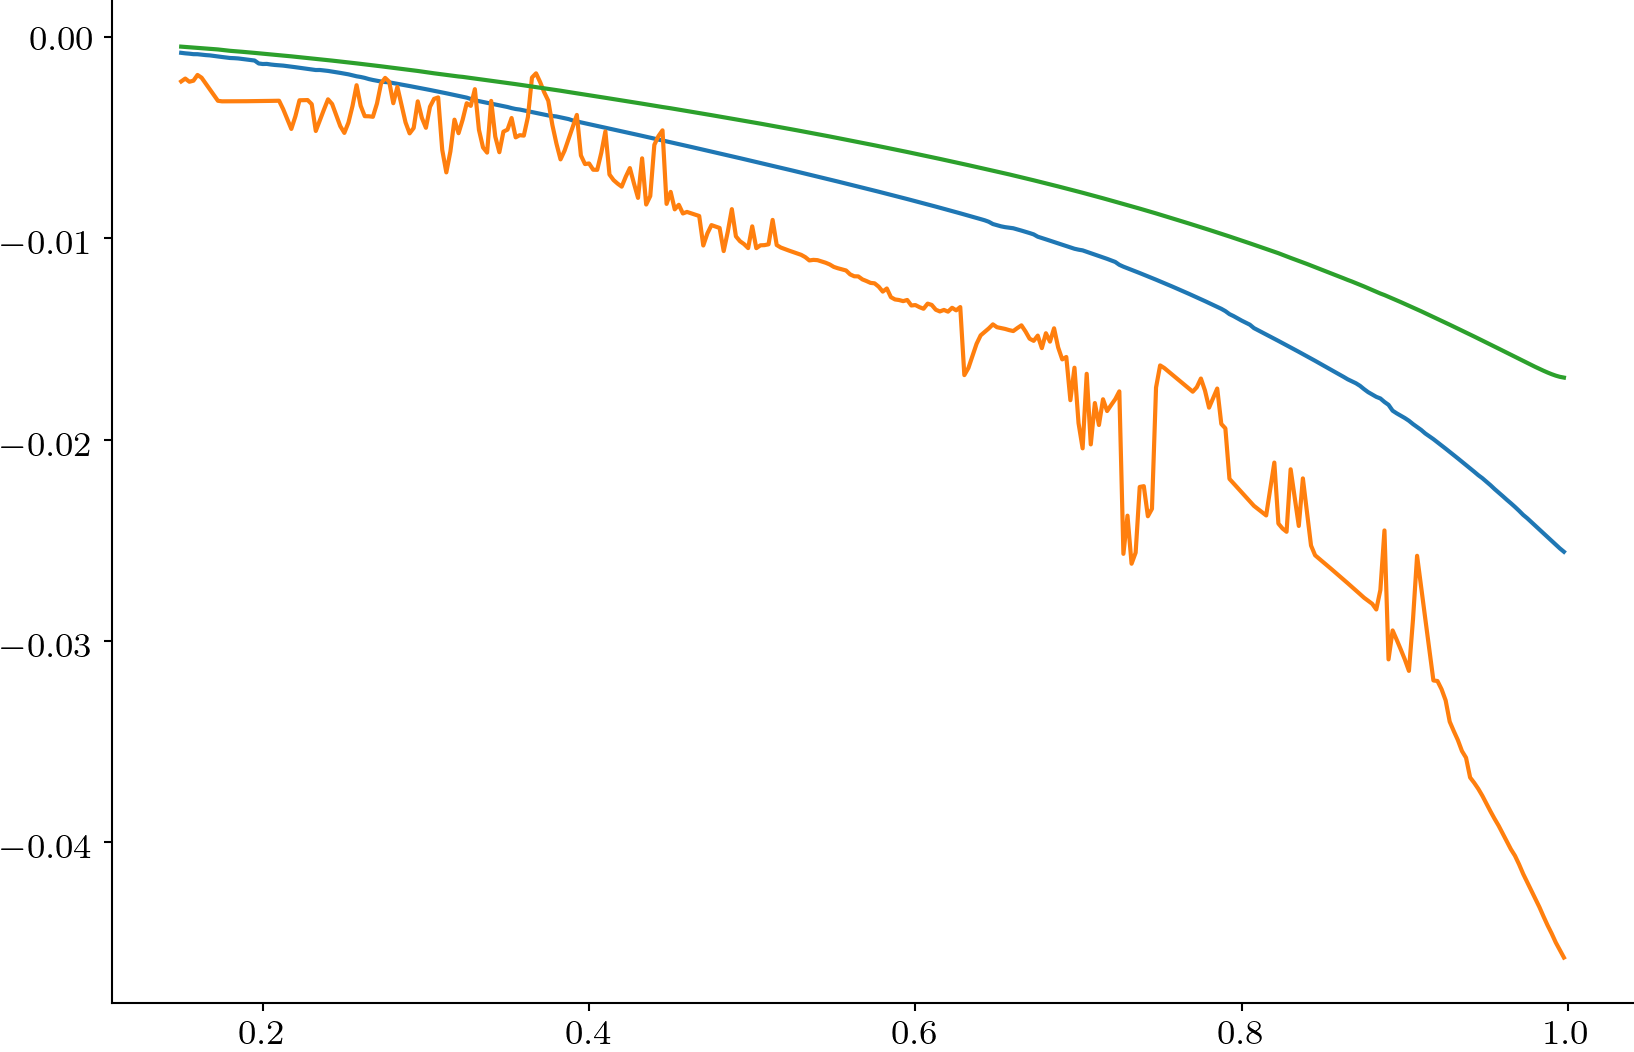

In [17]:
# Fig S3 extract szsz corr data

# Now actually extract the density values and correlator values at the desired temperatures. 

niceplotnArr_FigS3 =niceplotnArr_FigS4
niceplotszszArr_FigS3 = [ # the 6 temps
    interp2DNiceXVsFixedY(niceplotnArr_FigS3, nvalsvsT, szszcorrvalsvsT, 0.3,2.2, uTvals,0.4),
    interp2DNiceXVsFixedY(niceplotnArr_FigS3, nvalsvsT, szszcorrvalsvsT, 0.3,2.2, uTvals,0.72+(0.72-0.4))
]
niceplotszszBestArr_FigS3 = interp2DNiceXVsFixedY(niceplotnArr_FigS3, nvalsvsT, 
                                                  szszcorrvalsvsT, 0.4,2.2, uTvals,0.72)


plt.plot(niceplotnArr_FigS3, niceplotszszBestArr_FigS3, marker = '', linestyle = '-')
plt.plot(niceplotnArr_FigS3, niceplotszszArr_FigS3[0], marker = '', linestyle = '-')
plt.plot(niceplotnArr_FigS3, niceplotszszArr_FigS3[1], marker = '', linestyle = '-')
plt.show() 



In [18]:
# # runInd, then error or value, then [radius, total, doublon, singlon ]
# # errorbar(radialDensitiesArr_Fig2[jjj][0],radialDensitiesArr_Fig2[jjj][1],
# #                            xerr = None, yerr=radialDensitiesArr_Fig2[jjj][4],
# #                            marker='o', linestyle = '', 
# #                            color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
# #                   label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
# #                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
# for jjj in range(len(FigS4_RunIndToUse)) :
#     plt.errorbar(radialSinglonDensitiesArr_FigS4[jjj][0],radialSinglonDensitiesArr_FigS4[jjj][1],
#                            xerr = None, yerr=radialSinglonDensitiesArr_FigS4[jjj][3],
#                            marker='o', linestyle = '', 
#                            color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
#                   label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)

#     stest_theory = testOfr_FromTheory(rtest, bestmuOffset, alphaTest,muvalsvsT[TindTest],svalsvsT[TindTest])
#     plt.plot(rtest, stest_theory, label = 's Theory best')

# Process Data

650
563
371


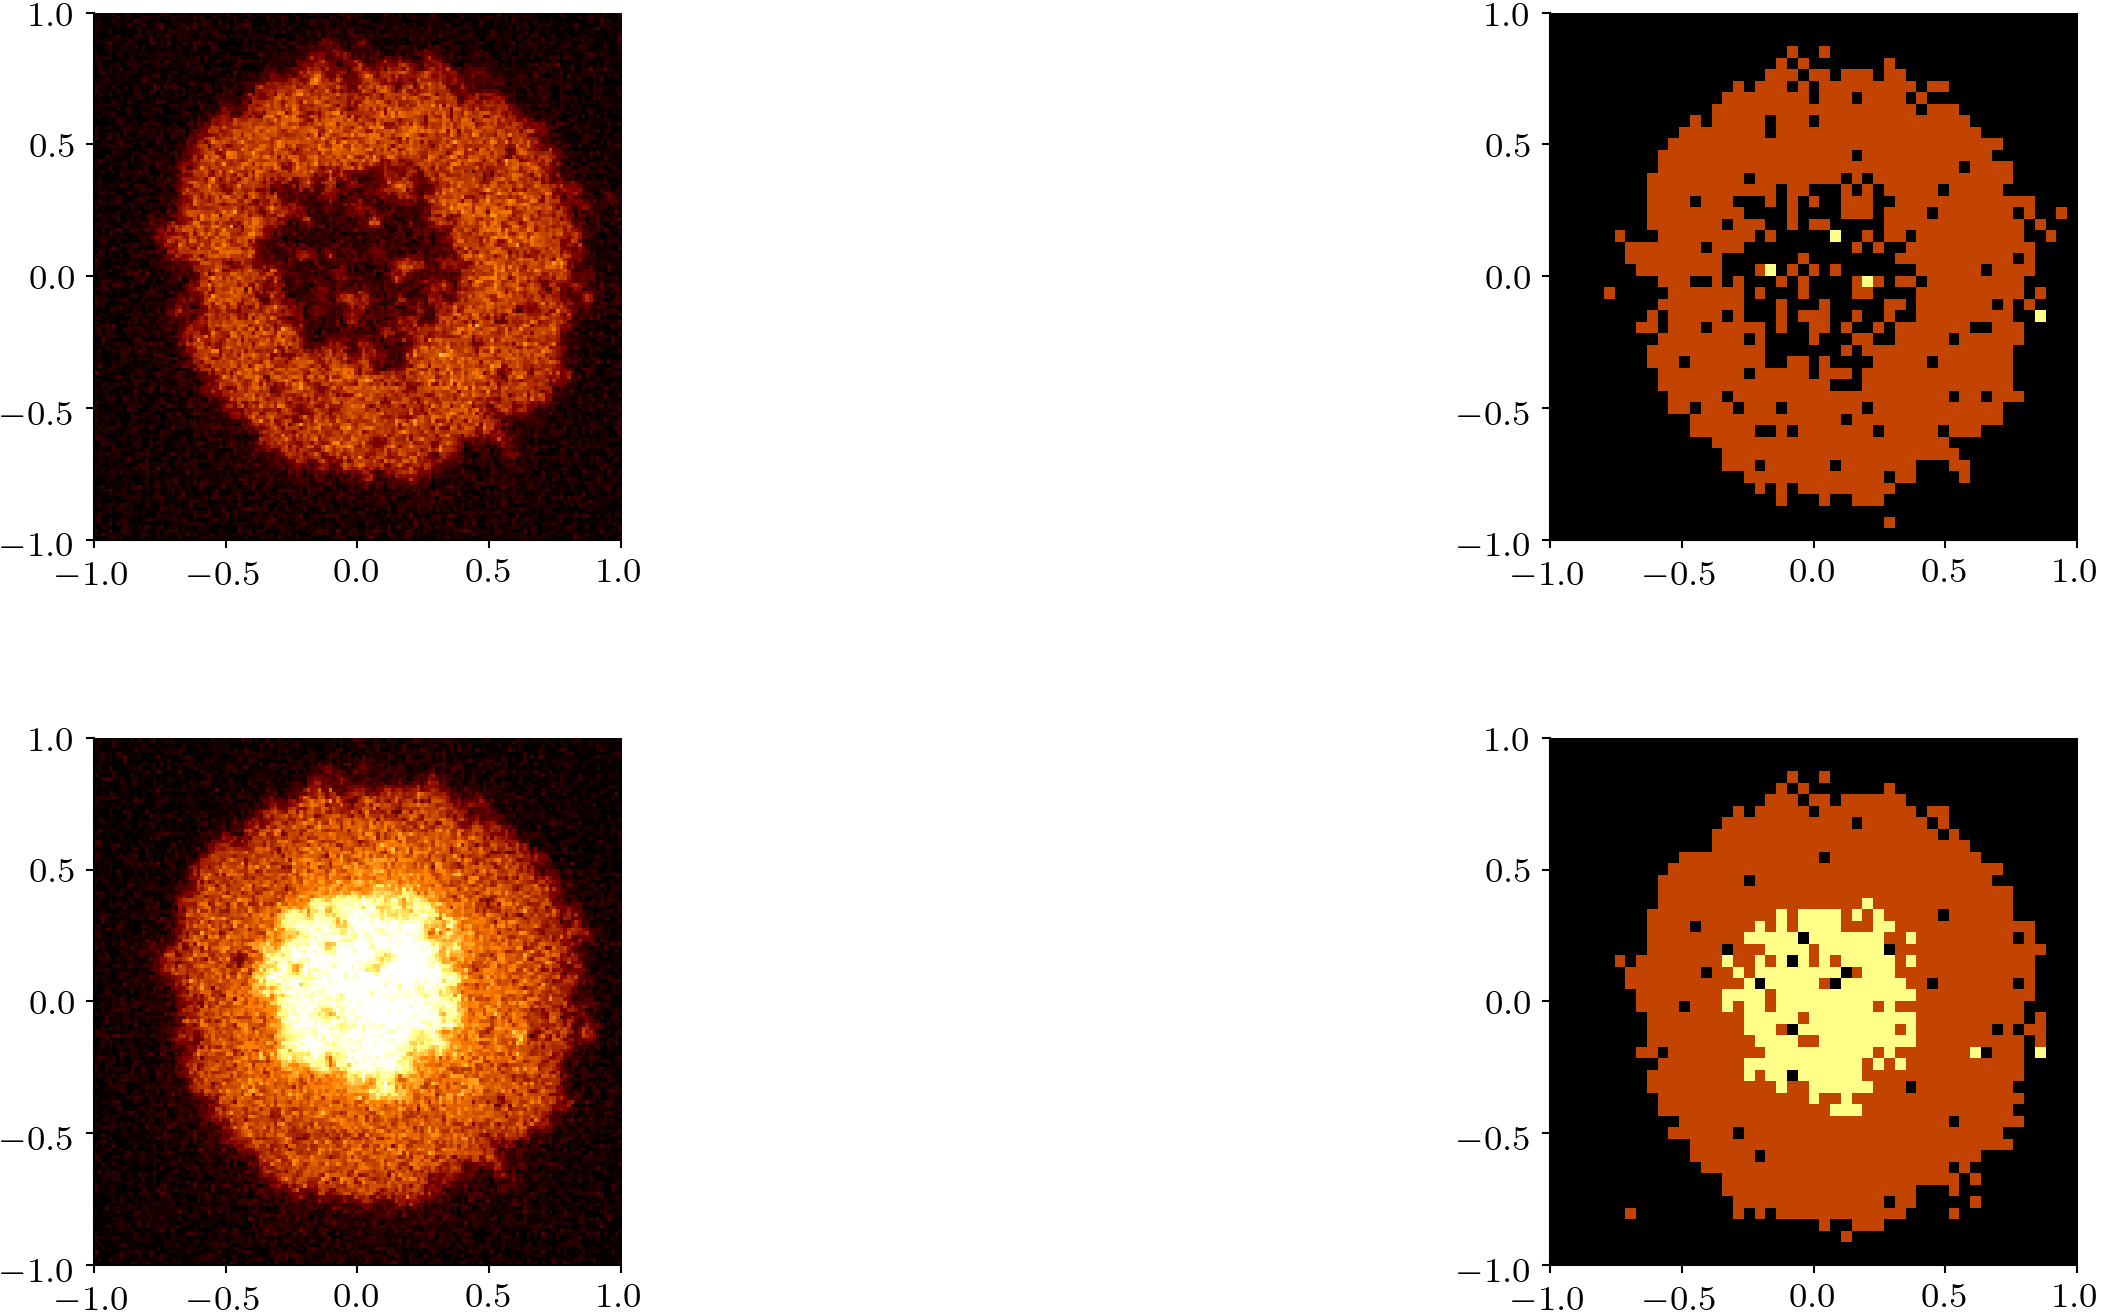

In [44]:
# Fig_1 Setup and processing
# Take a look at the raw image for demonstration/binninb and for Fig 1
# Choose color scales for plotting, etc. 

# first set up a color map
hsvcolorhueval = 0.08; 
    # 0.75 is purple
    # 0.55 is light blue
hsvbrightnessRatio = 1;  0.467;# For red 

newcmp = 'afmhot'#'gist_heat'# 'afmhot'
# See https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html for how HSV looks 

# Plot for raw images
rawimgColorMap = newcmp
rawimgExtent = [-1,1,-1,1]
binnedimgExtent = [-binnedimg_latsitesx,binnedimg_latsitesx,-binnedimg_latsitesy,binnedimg_latsitesy]
doubBrightnessPlotRatio = 1.0;# 1.25 # 1.0
backgroundBrightnessPlotRatio = 0.1; #0.1 # 0.1
binnedImageCorrection = 1.3; #1.3 # 1.0
# Get raw image scales roughly
rawimgMaxDoublonPix = 650 # np.amax(rawimgBest) #650 # 650
rawimgMaxSinglonPix = np.amax(rawimgRecom)
rawimgMinPix = np.amin(rawimgRecom)
print(rawimgMaxDoublonPix)
print(rawimgMaxSinglonPix)
print(rawimgMinPix)
minrawimgscale =  rawimgMinPix +backgroundBrightnessPlotRatio*doubBrightnessPlotRatio*(rawimgMaxDoublonPix - rawimgMinPix)
maxrawimgscale = doubBrightnessPlotRatio*(rawimgMaxDoublonPix - rawimgMinPix) + rawimgMinPix
vminBinned = 0 #0.2 # 0.0
vmaxBinned = 2*doubBrightnessPlotRatio*binnedImageCorrection


fig1, ax1 = plt.subplots(2, 2, figsize=(10,5))
ax1[0,0].imshow(rawimgRecom, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
ax1[0,1].imshow(binnedimgRecom, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                 extent=rawimgExtent,interpolation ='none')
ax1[1,0].imshow(rawimgBest, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
ax1[1,1].imshow(binnedimgBest, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                 extent=rawimgExtent,interpolation ='none')

[-1.52311029e-01  1.17424136e+03  1.17023066e-01  9.07633398e-01
  1.07222893e+02  4.40023363e-01  2.42419452e+00  3.14585879e+01
  5.58795526e-01]


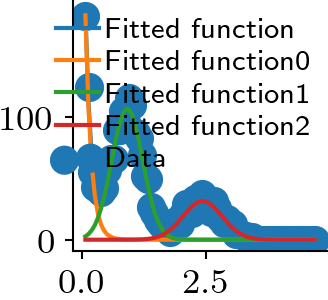

In [20]:
# Fig 1 histogram Processing
# Fit histogram data to 3 peaks to then plot those functions. 

# First crop the data to remove the stuff near 0 that messes up the fit. 
startindforfit = 26
x_data = histogram_xvals[startindforfit:]
y_data = histogram_test[0][startindforfit:]

def test_fluor(x,x0,a0,s0,x1,a1,s1,x2,a2,s2):
    zerocounts = a0*np.exp(-abs(x-x0)/s0)
    onecounts = a1*np.exp(-(x-x1)*(x-x1)/(s1*s1))
    twocounts = a2*np.exp(-(x-x2)*(x-x2)/(s2*s2))
    return zerocounts + onecounts + twocounts

def test_fluor0(x,x0,a0,s0,x1,a1,s1,x2,a2,s2):
    zerocounts = a0*np.exp(-abs(x-x0)/s0)
    onecounts = a1*np.exp(-(x-x1)*(x-x1)/(s1*s1))
    twocounts = a2*np.exp(-(x-x2)*(x-x2)/(s2*s2))
    return zerocounts 

def test_fluor1(x,x0,a0,s0,x1,a1,s1,x2,a2,s2):
    zerocounts = a0*np.exp(-abs(x-x0)/s0)
    onecounts = a1*np.exp(-(x-x1)*(x-x1)/(s1*s1))
    twocounts = a2*np.exp(-(x-x2)*(x-x2)/(s2*s2))
    return  onecounts 

def test_fluor2(x,x0,a0,s0,x1,a1,s1,x2,a2,s2):
    zerocounts = a0*np.exp(-abs(x-x0)/s0)
    onecounts = a1*np.exp(-(x-x1)*(x-x1)/(s1*s1))
    twocounts = a2*np.exp(-(x-x2)*(x-x2)/(s2*s2))
    return twocounts

paramsguess = [0,500,0.1, 1, 125, 0.4, 2.5, 50, 0.4]
params, params_covariance = scipy.optimize.curve_fit(test_fluor, x_data, y_data, p0=paramsguess)
print(params)

plt.figure(figsize=(1, 1))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_fluor(x_data, *params), linestyle = '-', marker = '',label='Fitted function')
plt.plot(x_data, test_fluor0(x_data, *params), linestyle = '-', marker = '',label='Fitted function0')
plt.plot(x_data, test_fluor1(x_data, *params), linestyle = '-', marker = '',label='Fitted function1')
plt.plot(x_data, test_fluor2(x_data, *params), linestyle = '-', marker = '',label='Fitted function2')
plt.legend(loc='best')
plt.show()

2.53615445 2.9730708 3.55670797


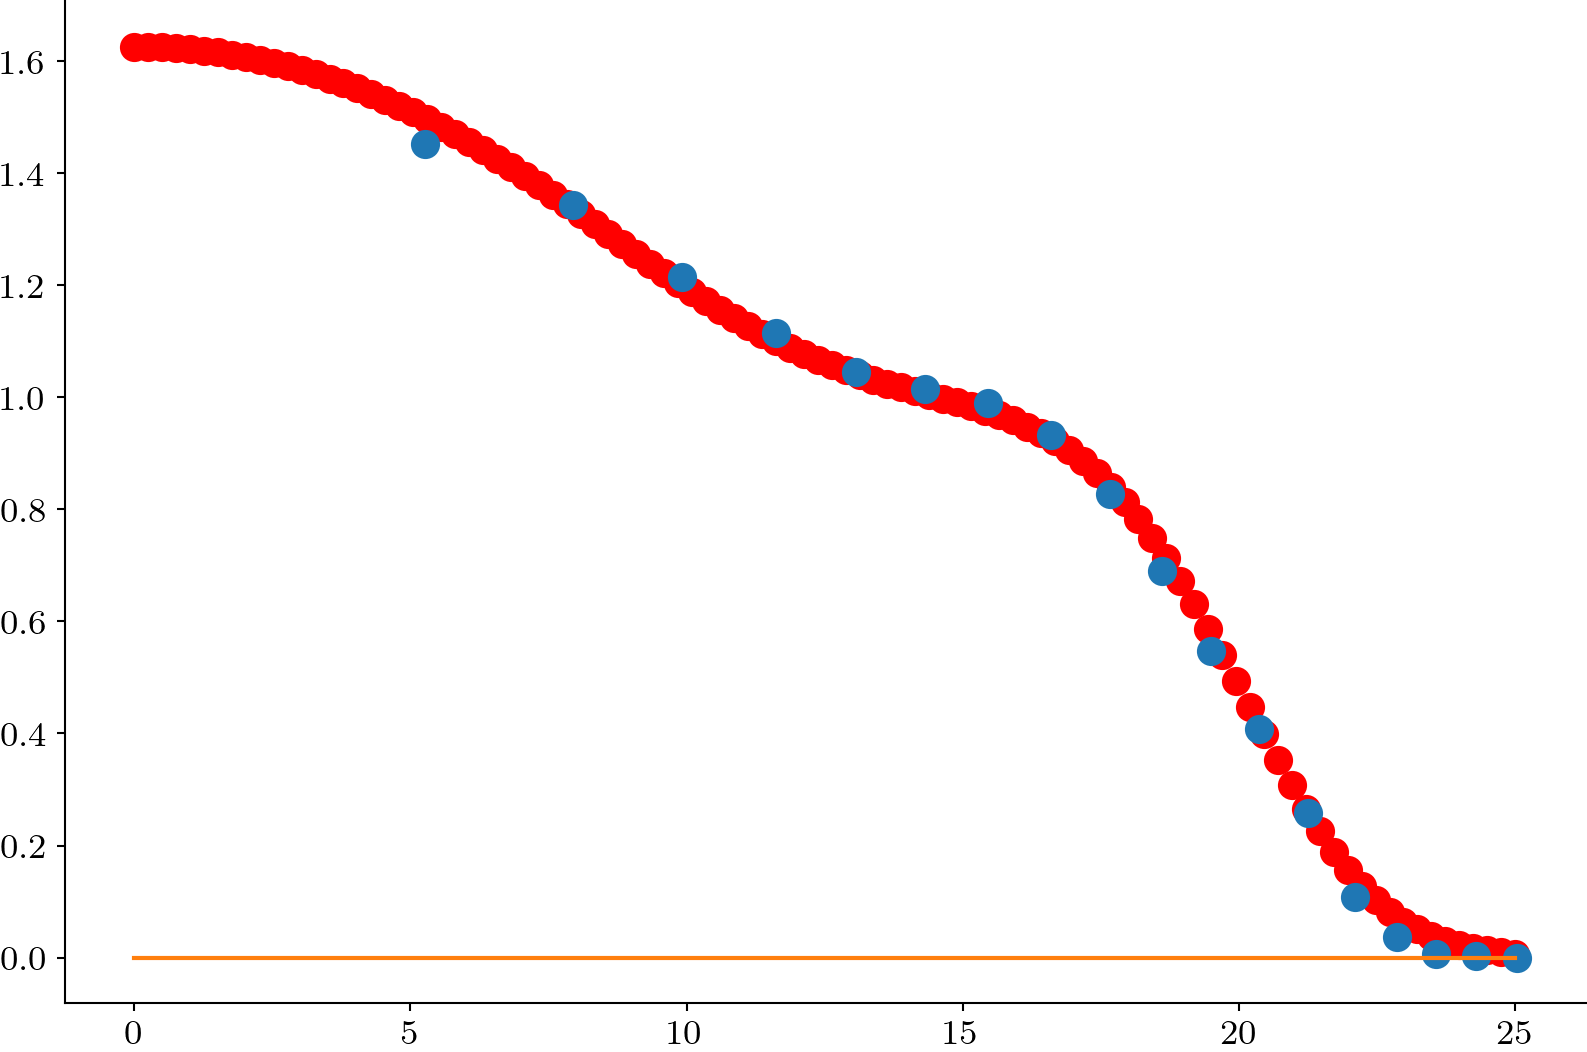

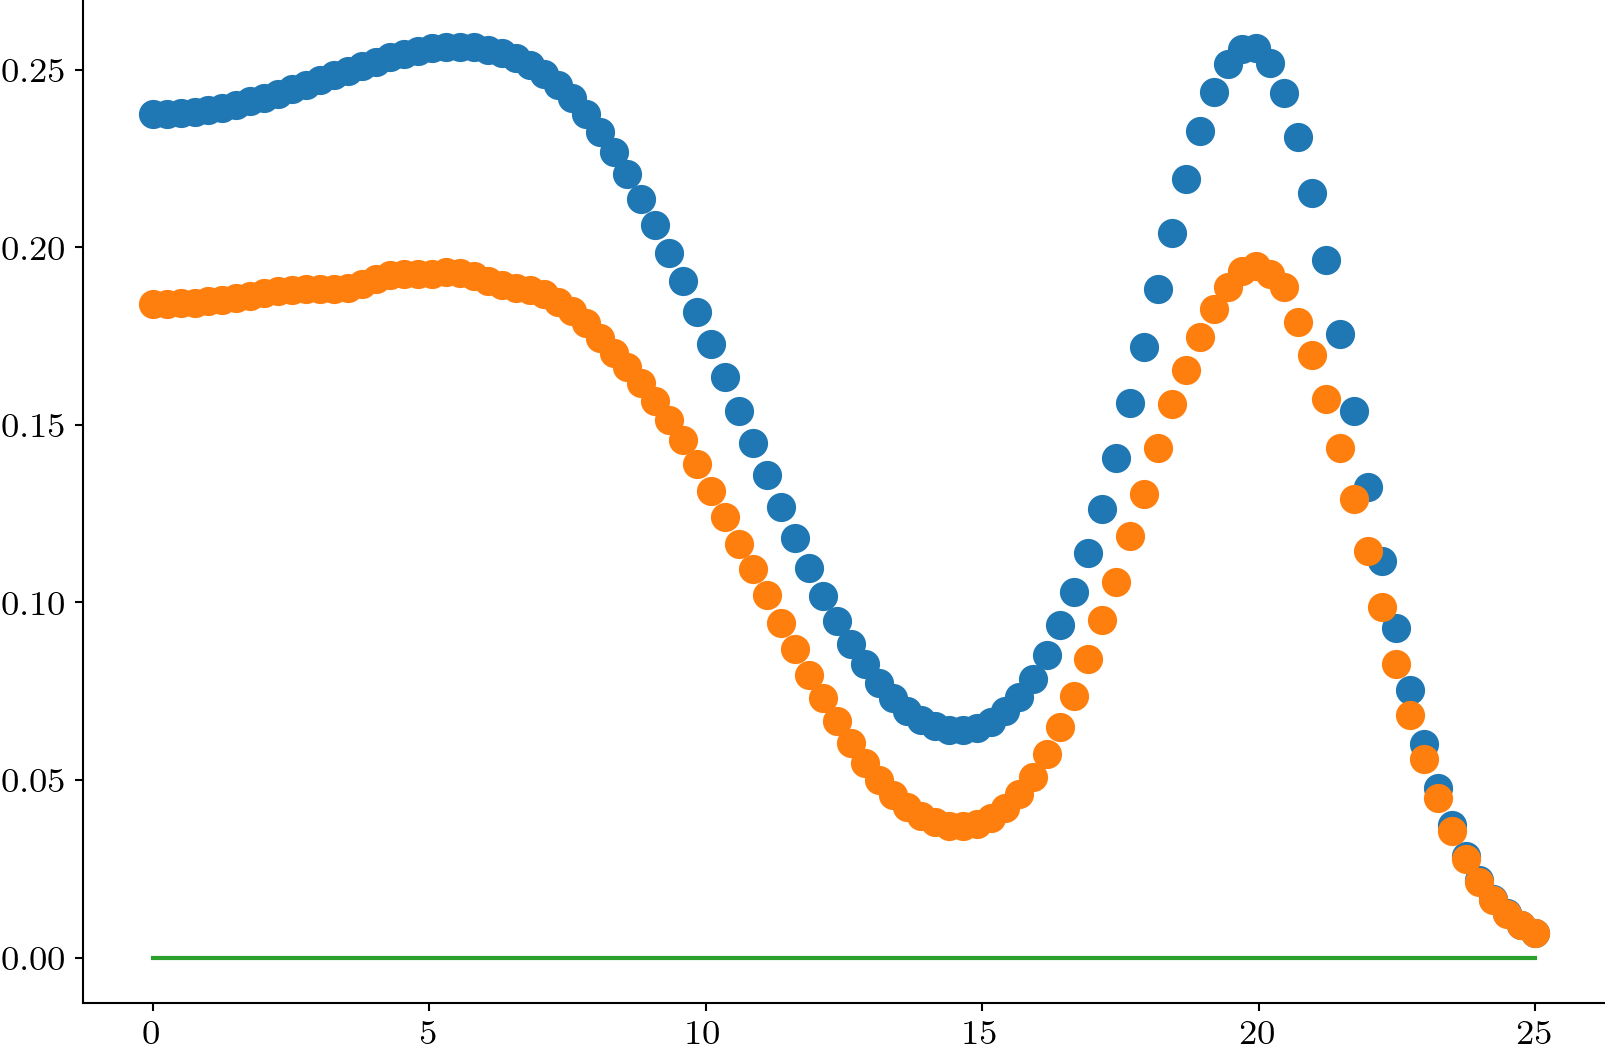

In [21]:
# Fig2 fits
from scipy.interpolate import interp1d

# alphaPotScaling = [1,1, 1]
# muOffsets_Fig2 = [0.81,0.775,0.715] # Manually chosen for now
alphaPotScaling = [1,1, 1]
muOffsets_Fig2 = [0.63,0.7,0.715] # Manually chosen for now - for scaled potentials
# alphaPotScaling = [0.78, 0.9, 1]
# muOffsets_Fig2 = [0.60,0.7,0.715] # Manually chosen for now
# alphaPotScaling = [0.80, 0.90, 1]
# muOffsets_Fig2 = [0.62,0.68,0.715] # Manually chosen for now - low Ts trap adjusted
numRvalsDQMC = 100
startRad = 0
stopRad = 25
DQMC_r_rvals_Fig2 = [np.linspace(startRad,stopRad,numRvalsDQMC),np.linspace(startRad,stopRad,numRvalsDQMC),
                     np.linspace(startRad,stopRad,numRvalsDQMC)]
DQMC_pot_rvals_Fig2 = [muOffsets_Fig2[0]-alphaPots_Fig2[0]*alphaPotScaling[0]*DQMC_r_rvals_Fig2[0]**2/realtArr_Fig2[0]/7.1,
                muOffsets_Fig2[1]-alphaPots_Fig2[1]*alphaPotScaling[1]*DQMC_r_rvals_Fig2[1]**2/realtArr_Fig2[1]/11.8,
                muOffsets_Fig2[2]-alphaPots_Fig2[2]*alphaPotScaling[2]*DQMC_r_rvals_Fig2[2]**2/realtArr_Fig2[2]/25.3]

print(alphaPots_Fig2[0]*alphaPotScaling[0],alphaPots_Fig2[1]*alphaPotScaling[1], 
      alphaPots_Fig2[2]*alphaPotScaling[2])

# DQMC_r_rvals_Fig2 = np.array(rArr_Fig2)[:,0]
# DQMC_pot_rvals_Fig2 = np.array(EOSArr_Fig2)[:,0]
DQMC_kappa_rvals_Fig2 = np.copy(DQMC_pot_rvals_Fig2)
DQMC_Dens_rvals_Fig2 = np.copy(DQMC_pot_rvals_Fig2)
DQMC_dd_rvals_Fig2 = np.copy(DQMC_pot_rvals_Fig2)
DQMC_deltan_rvals_Fig2 = np.copy(DQMC_pot_rvals_Fig2)
DQMC_deltantotal_rvals_Fig2 = np.copy(DQMC_pot_rvals_Fig2)
for runInd in [0,1,2]:
    def rolavg(inarr):
        inarrroll = (np.roll(inarr,1)+ np.roll(inarr,-1)+inarr)/3
        return inarrroll
    kappainterp = interp1d(DQMC_mu_Fig2[runInd],rolavg(DQMC_kappa_Fig2[runInd]), kind = 'cubic')
    Densinterp = interp1d(DQMC_mu_Fig2[runInd],rolavg(DQMC_Dens_Fig2[runInd]), kind = 'cubic')
    ddinterp = interp1d(DQMC_mu_Fig2[runInd],rolavg(DQMC_dd_Fig2[runInd]), kind = 'cubic')
    deltaninterp = interp1d(DQMC_mu_Fig2[runInd],rolavg(DQMC_deltan_Fig2[runInd]), kind = 'cubic')
    deltantotalinterp = interp1d(DQMC_mu_Fig2[runInd],rolavg(DQMC_deltan_Fig2[runInd]+DQMC_deltanonloc_Fig2[runInd]), kind = 'cubic')
    for rInd in range(len(DQMC_r_rvals_Fig2[runInd])) : 
        DQMC_kappa_rvals_Fig2[runInd][rInd] = kappainterp(DQMC_pot_rvals_Fig2[runInd][rInd])
        DQMC_Dens_rvals_Fig2[runInd][rInd] = Densinterp(DQMC_pot_rvals_Fig2[runInd][rInd])
        DQMC_dd_rvals_Fig2[runInd][rInd] = ddinterp(DQMC_pot_rvals_Fig2[runInd][rInd])
        DQMC_deltan_rvals_Fig2[runInd][rInd] = deltaninterp(DQMC_pot_rvals_Fig2[runInd][rInd])
        DQMC_deltantotal_rvals_Fig2[runInd][rInd] = deltantotalinterp(DQMC_pot_rvals_Fig2[runInd][rInd])
whichPlot = 1
plt.plot(DQMC_r_rvals_Fig2[whichPlot],DQMC_Dens_rvals_Fig2[whichPlot], color = 'red')
plt.plot(rArr_Fig2[whichPlot][0], nArr_Fig2[whichPlot][3])
plt.plot([0,25],[0,0], marker = '', linestyle = 'solid')
plt.show()
plt.plot(DQMC_r_rvals_Fig2[whichPlot],DQMC_deltan_rvals_Fig2[whichPlot])
plt.plot(DQMC_r_rvals_Fig2[whichPlot],DQMC_deltantotal_rvals_Fig2[whichPlot])
plt.plot([0,25],[0,0], marker = '', linestyle = 'solid')
plt.show()

0.05807480198793734
0.07232404122866917
0.10497677708478538


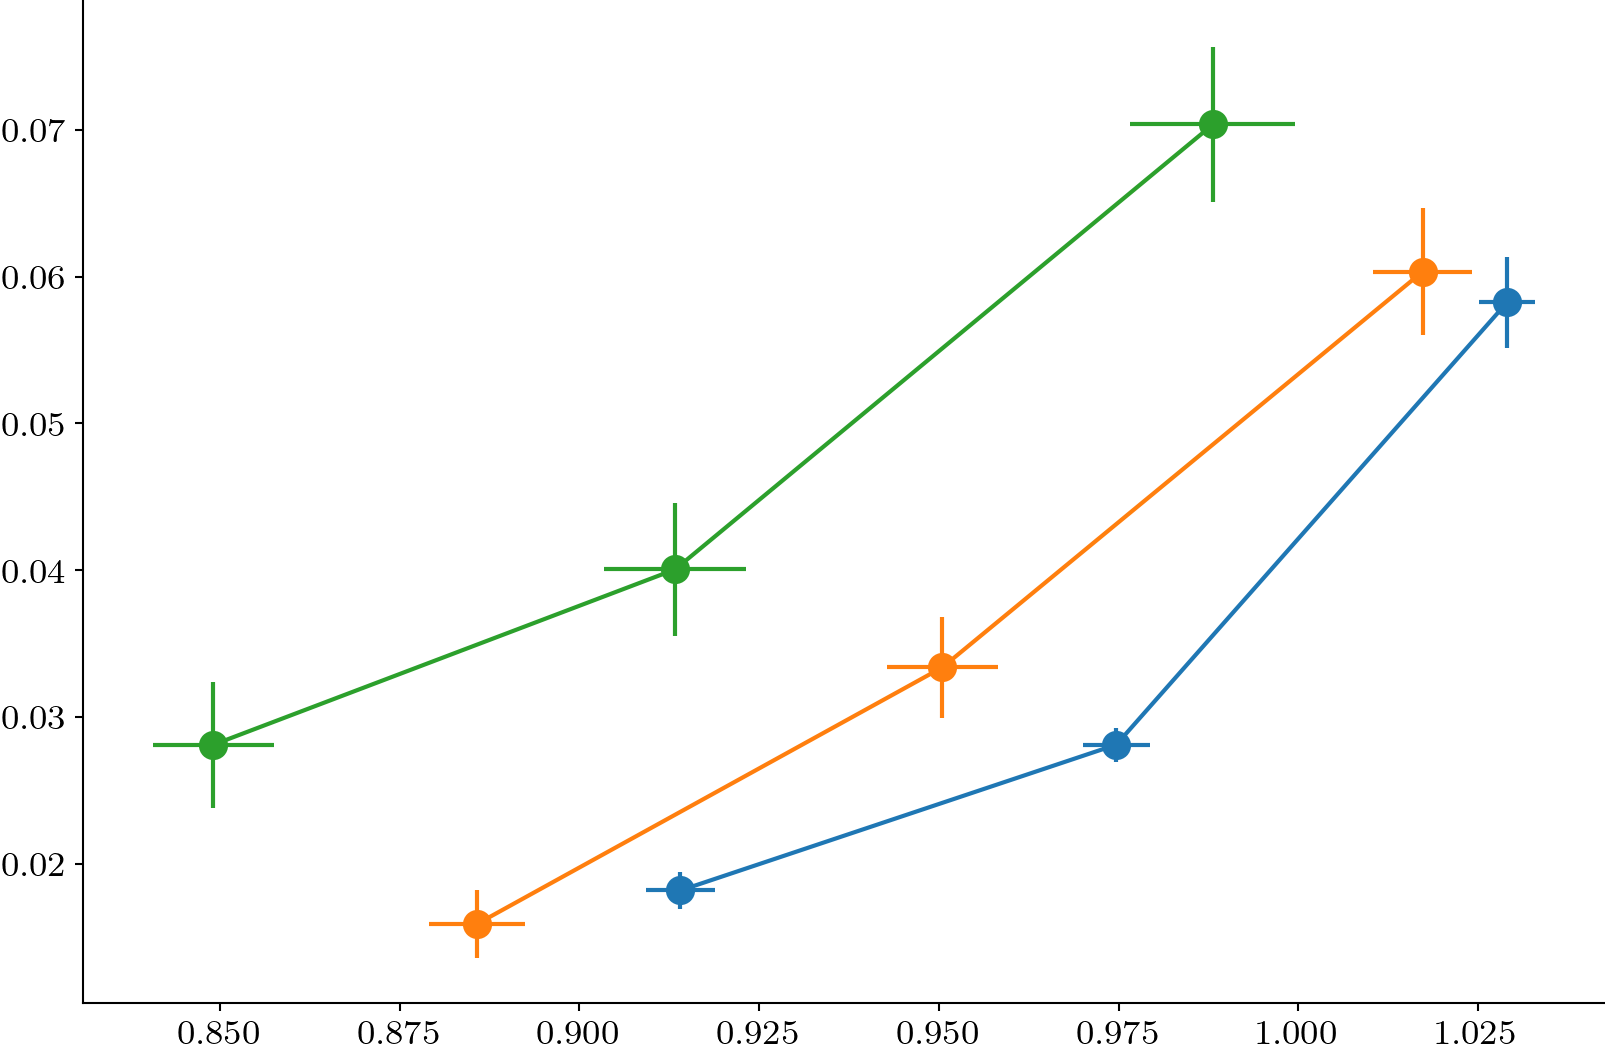

In [22]:
# Figure 3 doublon fraction display for reference and comparison to DQMC
for runInd in [0,1,2]:
    print(Tovert_cutoffArr_Fig3[runInd][0][0]/11.8) #first 0 is run index
    plt.errorbar(nArr_Fig3[runInd][3][10:],nArr_Fig3[runInd][2][10:],
                 xerr= nArr_Fig3[runInd][7][10:],yerr= nArr_Fig3[runInd][6][10:],
                 linestyle = 'solid')

370
716
376
706
375
769


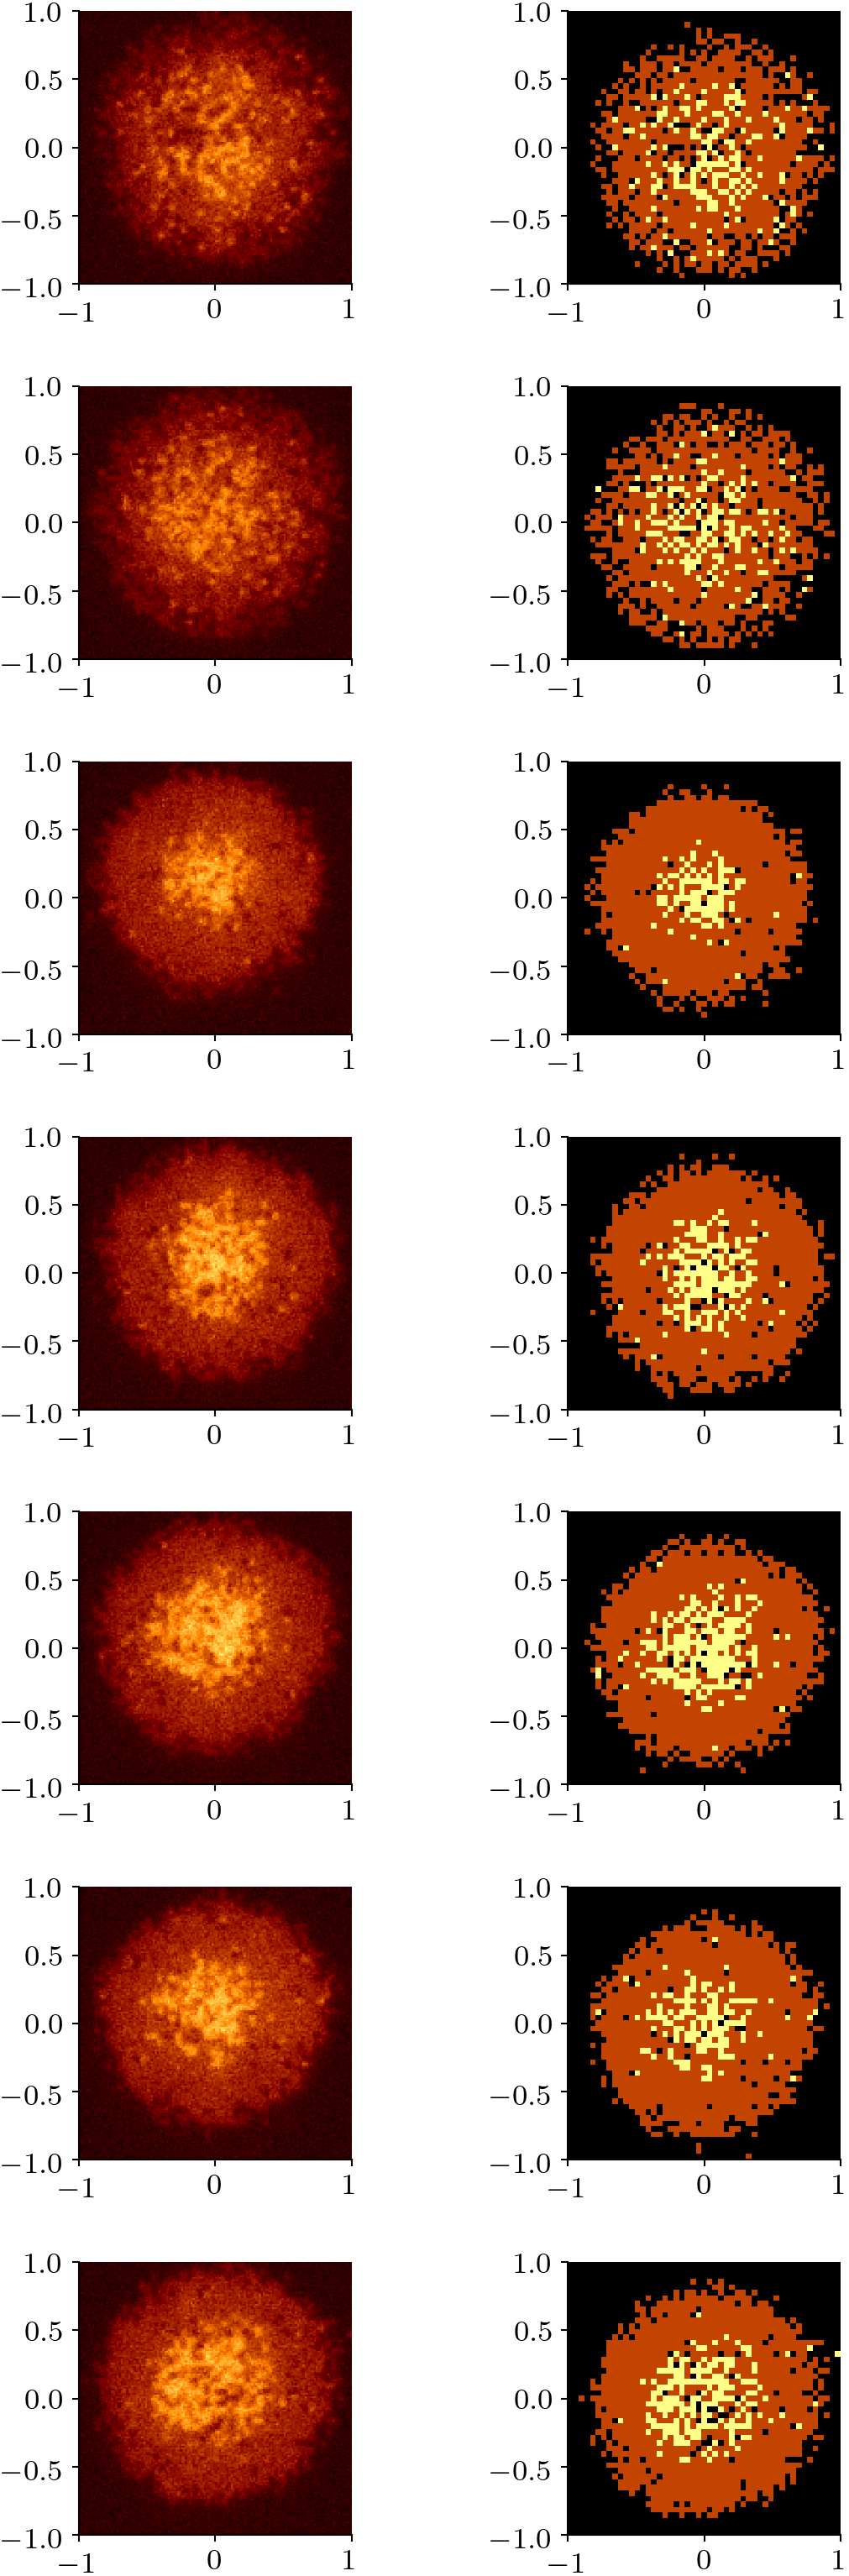

In [23]:
# Fig_5 see images 
# Use fig 1 setup 

fig1, ax1 = plt.subplots(len(arrdhrawimgs), 2, figsize=(4,12))
for jj in range(len(arrdhrawimgs)):
    ax1[jj,0].imshow(arrdhrawimgs[jj], cmap=rawimgColorMap, vmin=minrawimgscale*0.9, vmax=maxrawimgscale*1.45, 
                     extent=rawimgExtent,interpolation ='none')
    ax1[jj,1].imshow(arrdhbinnedimgs[jj], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                     extent=rawimgExtent,interpolation ='none')

# best seems to be 1 and 5  

# Find brightness scale to match figure 1
print(np.amin(rawimgBest))
print(np.amax(rawimgBest))
print(np.amin(arrdhrawimgs[1]))
print(np.amax(arrdhrawimgs[1]))
print(np.amin(arrdhrawimgs[5]))
print(np.amax(arrdhrawimgs[5]))
# they're actually pretty similar. 

# Plot Figures

## Figure 1

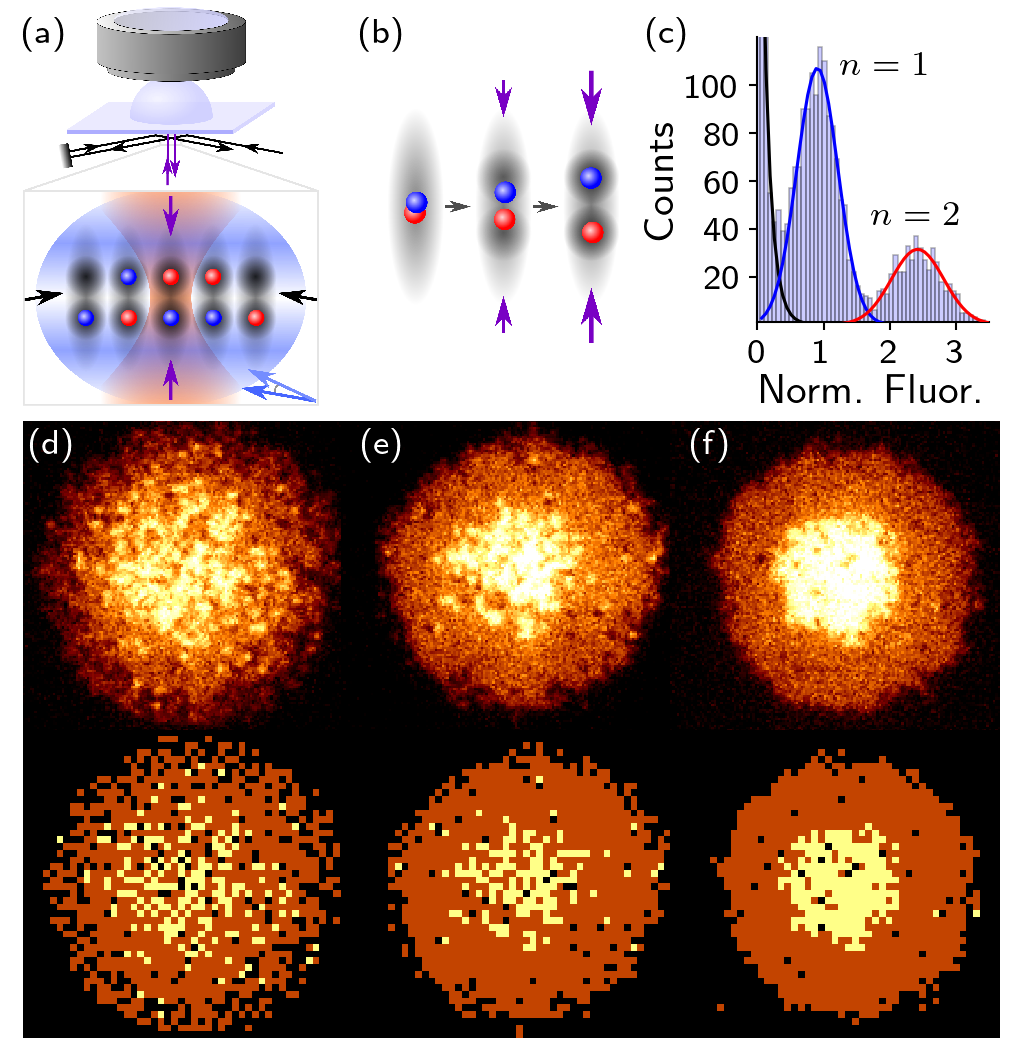

In [48]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio =  0.8 ;
fig1 = plt.figure(figsize = [fig_size[0],fig_size[1]/golden_mean*figAspectRatio]) # Make height same as width 
# basic drawing region
subplot0 = fig1.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 
# Microscope diagram
ax_mic_microscope = fig1.add_axes([0,0,0,0], frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_mic_microscope.axis('off')
anchorGraphInSubplot(subplot0, ax_mic_microscope, relx=0.02, rely=0.3333/figAspectRatio*1.2, 
                     relwidth=1.0, relheight=0.6666*figAspectRatio*0.925)
# anchorGraphInSubplot(subplot0, ax_mic_microscope, relx=0, rely=0.3333/figAspectRatio, 
#                      relwidth=1.1, relheight=0.6666*figAspectRatio)

# Brightness settings for images
rawImgBrightnessScale1 = 0.95 # weak int
rawImgBrightnessScale2 = 0.925 # more strongly int

# actual images
imgSize =  0.325;0.334;0.325
imgHorizSpacingScale = 0.96
imgShiftDownScale = 1.095;
ax_fillmelted = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fillmelted.axis('off')
setupImgDisplay(ax_fillmelted, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fillmelted, relx=0.00000*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, rely=0.075, 
                     relwidth=imgSize, relheight=imgSize/figAspectRatio)
ax_fillmelting = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fillmelting.axis('off')
setupImgDisplay(ax_fillmelting, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fillmelting, relx=-0.0015+0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
                     rely=0.075, relwidth=imgSize, relheight=imgSize/figAspectRatio)
ax_fill = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fill.axis('off')
setupImgDisplay(ax_fill, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fill, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
                     rely=0.075, relwidth=imgSize, 
                     relheight=imgSize/figAspectRatio)

# Binned ones
ax_fillmelted_b = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fillmelted_b.axis('off')
setupImgDisplay(ax_fillmelted_b, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fillmelted_b, relx=0.0000*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
                     rely=0.075-imgSize*imgShiftDownScale, 
                     relwidth=imgSize, relheight=imgSize/figAspectRatio)
ax_fillmelting_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fillmelting_b.axis('off')
setupImgDisplay(ax_fillmelting_b, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fillmelting_b,  relx=-0.0015+0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
                     rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, relheight=imgSize/figAspectRatio)
ax_fill_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fill_b.axis('off')
setupImgDisplay(ax_fill_b, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fill_b, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125,
                     rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, 
                     relheight=imgSize/figAspectRatio)

# ax_fill = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fill.axis('off')
# setupImgDisplay(ax_fill, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fill, relx=0.0125, rely=0.075, relwidth=imgSize, 
#                      relheight=imgSize/figAspectRatio)

# ax_fillmelting = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelting.axis('off')
# setupImgDisplay(ax_fillmelting, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelting, relx=0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
#                      rely=0.075, relwidth=imgSize, relheight=imgSize/figAspectRatio)

# ax_fillmelted = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelted.axis('off')
# setupImgDisplay(ax_fillmelted, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelted, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, rely=0.075, 
#                      relwidth=imgSize, relheight=imgSize/figAspectRatio)
# # Binned ones
# ax_fill_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fill_b.axis('off')
# setupImgDisplay(ax_fill_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fill_b, relx=0.0125, rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, 
#                      relheight=imgSize/figAspectRatio)

# ax_fillmelting_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelting_b.axis('off')
# setupImgDisplay(ax_fillmelting_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelting_b,  relx=0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
#                      rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, relheight=imgSize/figAspectRatio)
                     
# ax_fillmelted_b = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelted_b.axis('off')
# setupImgDisplay(ax_fillmelted_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelted_b, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
#                      rely=0.075-imgSize*imgShiftDownScale, 
#                      relwidth=imgSize, relheight=imgSize/figAspectRatio)

# Histogram
subplot3 = fig1.add_subplot(2,3,3, label = str(np.random.rand()))
anchorGraphInSubplot(subplot3,subplot3, relx=0.0, rely=0, relwidth=1, relheight=1.0)

# labelSubplot(subplot3,'(c)') # Annotate plot as (a), (b), and so on.
# ax_mic_microscopeLabel = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_mic_microscopeLabel.axis('off')
# labelSubplot(ax_mic_microscopeLabel,'(a)') # Annotate plot as (a), (b), and so on.
# ax_mic_microscopeLabel2 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_mic_microscopeLabel2.axis('off')
# ax_mic_microscopeLabel3 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_mic_microscopeLabel3.axis('off')
# ax_mic_microscopeLabel4 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_mic_microscopeLabel4.axis('off')
    # Move it over slightly 
bOffsetX = 0.39
dOffsetX = 0.8
cOffsetX = 0.52
cOffsetY = 0.45
# anchorGraphInSubplot(ax_mic_microscopeLabel2,ax_mic_microscopeLabel2, 
#                      relx=bOffsetX, rely=0.0, relwidth=1-bOffsetX, relheight=1)
# labelSubplot(ax_mic_microscopeLabel2,'(b)') # Annotate plot as (a), (b), and so on.
subplot3.annotate('$n=1$', xy=(1.25,108), xycoords='data',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='center', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'black')
subplot3.annotate('$n=2$', xy=(2.4,39), xycoords='data',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='bottom', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# Move the annotation up relative to plots so they dont hit
extraInside = 0.02
extraMoveRight = 0.04
ax_fillmelted.annotate('(d)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
ax_fillmelting.annotate('(e)', xy=(0+extraInside+extraMoveRight,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
ax_fill.annotate('(f)', xy=(0+extraInside+extraMoveRight,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
subplot0.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'black')
subplot0.annotate('(b)', xy=(0.3333333+extraInside,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'black')
subplot0.annotate('(c)', xy=(0.666666+extraInside - 0.05,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# U/t values
# ax_fill_b.annotate('$U \\gg t$', xy=(0.535,0.98), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# ax_fillmelting_b.annotate('$\\longrightarrow$', xy=(0.525,0.985), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# ax_fillmelted_b.annotate('$U \\sim 7 t$', xy=(0.525,0.985), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')


ax_mic_microscope.imshow(microscopeImg_microscope, interpolation ='none')

# IMPORTANT - adjust raw img colorscale for ax_fill since background is slightly brighter
ax_fill.imshow(rawimgBest, cmap=rawimgColorMap, vmin=minrawimgscale*1.025, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
ax_fillmelted.imshow(arrdhrawimgs[1]*rawImgBrightnessScale1, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
        # arrdhrawimgs is defined where Fig. 5 is read in
ax_fillmelting.imshow(arrdhrawimgs_othershift[5]*rawImgBrightnessScale2, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')

ax_fill_b.imshow(binnedimgBest, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                     extent=binnedimgExtent,interpolation ='none')
ax_fillmelted_b.imshow(arrdhbinnedimgs[1], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                     extent=binnedimgExtent,interpolation ='none')
ax_fillmelting_b.imshow(arrdhbinnedimgs_othershift[5], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                     extent=binnedimgExtent,interpolation ='none')

# Histogram
barwidthtouse = histogram_xvals[1] - histogram_xvals[0]
subplot3.bar(histogram_xvals, histogram_test[0], width= barwidthtouse,
             color = xcolors[0], edgecolor = xedgecolors[1], alpha = 0.3,
             label = 'Image 1',linewidth = pgslinewidth/2) 
subplot3.plot(x_data, test_fluor0(x_data, *params), linestyle="-", marker = "", 
              color = xedgecolors[1],label = '0 counts', **plot_global_style)
subplot3.plot(x_data, test_fluor1(x_data, *params), linestyle="-", marker = "", 
              color = xedgecolors[0],label = '1 counts', **plot_global_style)
subplot3.plot(x_data, test_fluor2(x_data, *params), linestyle="-", marker = "", 
              color = xedgecolors[2],label = '2 counts', **plot_global_style)
subplot3.set_xlabel("Norm. Fluor.", 			labelpad = label_globalpad)
subplot3.set_ylabel("Counts", 	labelpad = label_globalpad)
subplot3.set_xlim([0,3.5])
subplot3.set_ylim([1,120])
subplot3.xaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune = None))
subplot3.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune = 'upper'))
subplot3.margins(x=0.05,y=0.05,tight=True)


# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig1.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('Fig1.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [74]:
# ########## Now plotting figure
#     # Can adjust figure size in style area above if you want. 
# figAspectRatio =  0.8 ;
# fig1 = plt.figure(figsize = [fig_size[0],fig_size[1]/golden_mean*figAspectRatio]) # Make height same as width 
# # basic drawing region
# subplot0 = fig1.add_axes((0,0,1,1), label = str(np.random.rand()))
# subplot0.axis('off')  # random things so I can move it in 
# # Microscope diagram
# ax_mic_microscope = fig1.add_axes([0,0,0,0], frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_mic_microscope.axis('off')
# anchorGraphInSubplot(subplot0, ax_mic_microscope, relx=0.02, rely=0.3333/figAspectRatio*1.2, 
#                      relwidth=1.0, relheight=0.6666*figAspectRatio*0.925)
# # anchorGraphInSubplot(subplot0, ax_mic_microscope, relx=0, rely=0.3333/figAspectRatio, 
# #                      relwidth=1.1, relheight=0.6666*figAspectRatio)

# # Brightness settings for images
# rawImgBrightnessScale1 = 0.95 # weak int
# rawImgBrightnessScale2 = 0.925 # more strongly int

# # actual images
# imgSize =  0.325;0.334;0.325
# imgHorizSpacingScale = 0.96
# imgShiftDownScale = 1.215;
# ax_fill = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fill.axis('off')
# setupImgDisplay(ax_fill, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fill, relx=0.0*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
#                      rely=0.075, relwidth=imgSize, 
#                      relheight=imgSize/figAspectRatio)
# ax_fillmelting = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelting.axis('off')
# setupImgDisplay(ax_fillmelting, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelting, relx=-0.0015+0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
#                      rely=0.075, relwidth=imgSize, relheight=imgSize/figAspectRatio)
# ax_fillmelted = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelted.axis('off')
# setupImgDisplay(ax_fillmelted, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelted, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, rely=0.075, 
#                      relwidth=imgSize, relheight=imgSize/figAspectRatio)

# # Binned ones
# ax_fill_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fill_b.axis('off')
# setupImgDisplay(ax_fill_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fill_b, relx=0.0*imgHorizSpacingScale+(0.3333-imgSize)+0.0125,
#                      rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, 
#                      relheight=imgSize/figAspectRatio)
# ax_fillmelting_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelting_b.axis('off')
# setupImgDisplay(ax_fillmelting_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelting_b,  relx=-0.0015+0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
#                      rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, relheight=imgSize/figAspectRatio)
                     
# ax_fillmelted_b = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillmelted_b.axis('off')
# setupImgDisplay(ax_fillmelted_b, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fillmelted_b, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
#                      rely=0.075-imgSize*imgShiftDownScale, 
#                      relwidth=imgSize, relheight=imgSize/figAspectRatio)
# # ax_fill = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fill.axis('off')
# # setupImgDisplay(ax_fill, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fill, relx=0.0125, rely=0.075, relwidth=imgSize, 
# #                      relheight=imgSize/figAspectRatio)

# # ax_fillmelting = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillmelting.axis('off')
# # setupImgDisplay(ax_fillmelting, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fillmelting, relx=0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
# #                      rely=0.075, relwidth=imgSize, relheight=imgSize/figAspectRatio)

# # ax_fillmelted = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillmelted.axis('off')
# # setupImgDisplay(ax_fillmelted, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fillmelted, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, rely=0.075, 
# #                      relwidth=imgSize, relheight=imgSize/figAspectRatio)
# # # Binned ones
# # ax_fill_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fill_b.axis('off')
# # setupImgDisplay(ax_fill_b, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fill_b, relx=0.0125, rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, 
# #                      relheight=imgSize/figAspectRatio)

# # ax_fillmelting_b = fig1.add_subplot(2,2,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillmelting_b.axis('off')
# # setupImgDisplay(ax_fillmelting_b, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fillmelting_b,  relx=0.3333*imgHorizSpacingScale+(0.3333-imgSize)/2+0.0125, 
# #                      rely=0.075-imgSize*imgShiftDownScale, relwidth=imgSize, relheight=imgSize/figAspectRatio)
                     
# # ax_fillmelted_b = fig1.add_subplot(2,2,4, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillmelted_b.axis('off')
# # setupImgDisplay(ax_fillmelted_b, xcolors[5]) 
# # anchorGraphInSubplot(subplot0, ax_fillmelted_b, relx=0.6666*imgHorizSpacingScale+(0.3333-imgSize)+0.0125, 
# #                      rely=0.075-imgSize*imgShiftDownScale, 
# #                      relwidth=imgSize, relheight=imgSize/figAspectRatio)

# # Histogram
# subplot3 = fig1.add_subplot(2,3,3, label = str(np.random.rand()))
# anchorGraphInSubplot(subplot3,subplot3, relx=0.0, rely=0, relwidth=1, relheight=1.0)

# # labelSubplot(subplot3,'(c)') # Annotate plot as (a), (b), and so on.
# # ax_mic_microscopeLabel = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_mic_microscopeLabel.axis('off')
# # labelSubplot(ax_mic_microscopeLabel,'(a)') # Annotate plot as (a), (b), and so on.
# # ax_mic_microscopeLabel2 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_mic_microscopeLabel2.axis('off')
# # ax_mic_microscopeLabel3 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_mic_microscopeLabel3.axis('off')
# # ax_mic_microscopeLabel4 = fig1.add_subplot(2,1,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_mic_microscopeLabel4.axis('off')
#     # Move it over slightly 
# bOffsetX = 0.39
# dOffsetX = 0.8
# cOffsetX = 0.52
# cOffsetY = 0.45
# # anchorGraphInSubplot(ax_mic_microscopeLabel2,ax_mic_microscopeLabel2, 
# #                      relx=bOffsetX, rely=0.0, relwidth=1-bOffsetX, relheight=1)
# # labelSubplot(ax_mic_microscopeLabel2,'(b)') # Annotate plot as (a), (b), and so on.
# subplot3.annotate('$n=1$', xy=(1.25,108), xycoords='data',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')
# subplot3.annotate('$n=2$', xy=(2.4,39), xycoords='data',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='bottom', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')

# # Move the annotation up relative to plots so they dont hit
# extraInside = 0.02
# ax_fill.annotate('(d)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# ax_fillmelting.annotate('(e)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# ax_fillmelted.annotate('(f)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# subplot0.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')
# subplot0.annotate('(b)', xy=(0.3333333+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')
# subplot0.annotate('(c)', xy=(0.666666+extraInside - 0.05,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')

# # U/t values
# ax_fill_b.annotate('$U \\gg t$', xy=(0.5,0.985), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# # ax_fillmelting_b.annotate('$\\longrightarrow$', xy=(0.525,0.985), xycoords='axes fraction',
# #                xytext=(0,0), 
# #                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
# #                fontsize=subplotlabelfontsize,
# #                  color = 'white')
# ax_fillmelted_b.annotate('$U \\sim 7 t$', xy=(0.525,0.985), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='center', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')


# ax_mic_microscope.imshow(microscopeImg_microscope, interpolation ='none')

# ax_fill.imshow(rawimgBest, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
# ax_fillmelted.imshow(arrdhrawimgs[1]*rawImgBrightnessScale1, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
#         # arrdhrawimgs is defined where Fig. 5 is read in
# ax_fillmelting.imshow(arrdhrawimgs[5]*rawImgBrightnessScale2, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')

# ax_fill_b.imshow(binnedimgBest, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')
# ax_fillmelted_b.imshow(arrdhbinnedimgs[1], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')
# ax_fillmelting_b.imshow(arrdhbinnedimgs[5], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')

# # Histogram
# barwidthtouse = histogram_xvals[1] - histogram_xvals[0]
# subplot3.bar(histogram_xvals, histogram_test[0], width= barwidthtouse,
#              color = xcolors[0], edgecolor = xedgecolors[1], alpha = 0.3,
#              label = 'Image 1',linewidth = pgslinewidth/2) 
# subplot3.plot(x_data, test_fluor0(x_data, *params), linestyle="-", marker = "", 
#               color = xedgecolors[1],label = '0 counts', **plot_global_style)
# subplot3.plot(x_data, test_fluor1(x_data, *params), linestyle="-", marker = "", 
#               color = xedgecolors[0],label = '1 counts', **plot_global_style)
# subplot3.plot(x_data, test_fluor2(x_data, *params), linestyle="-", marker = "", 
#               color = xedgecolors[2],label = '2 counts', **plot_global_style)
# subplot3.set_xlabel("Norm. Fluor.", 			labelpad = label_globalpad)
# subplot3.set_ylabel("Counts", 	labelpad = label_globalpad)
# subplot3.set_xlim([0,3.5])
# subplot3.set_ylim([1,120])
# subplot3.xaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune = None))
# subplot3.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune = 'upper'))
# subplot3.margins(x=0.05,y=0.05,tight=True)


# # Draw all plots and convert axis labels to Sans-serif 
#     # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
# for ax_inst in fig1.axes :
#     convAxLabelSansSerif(ax_inst, 'both')

# ########## Save figure and show
#     # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
#     # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('Fig1.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# # shouldnt have to worry about DPI since images were loaded without interpolation
# plt.show() # Can comment this out if you want. 

## Figure 2

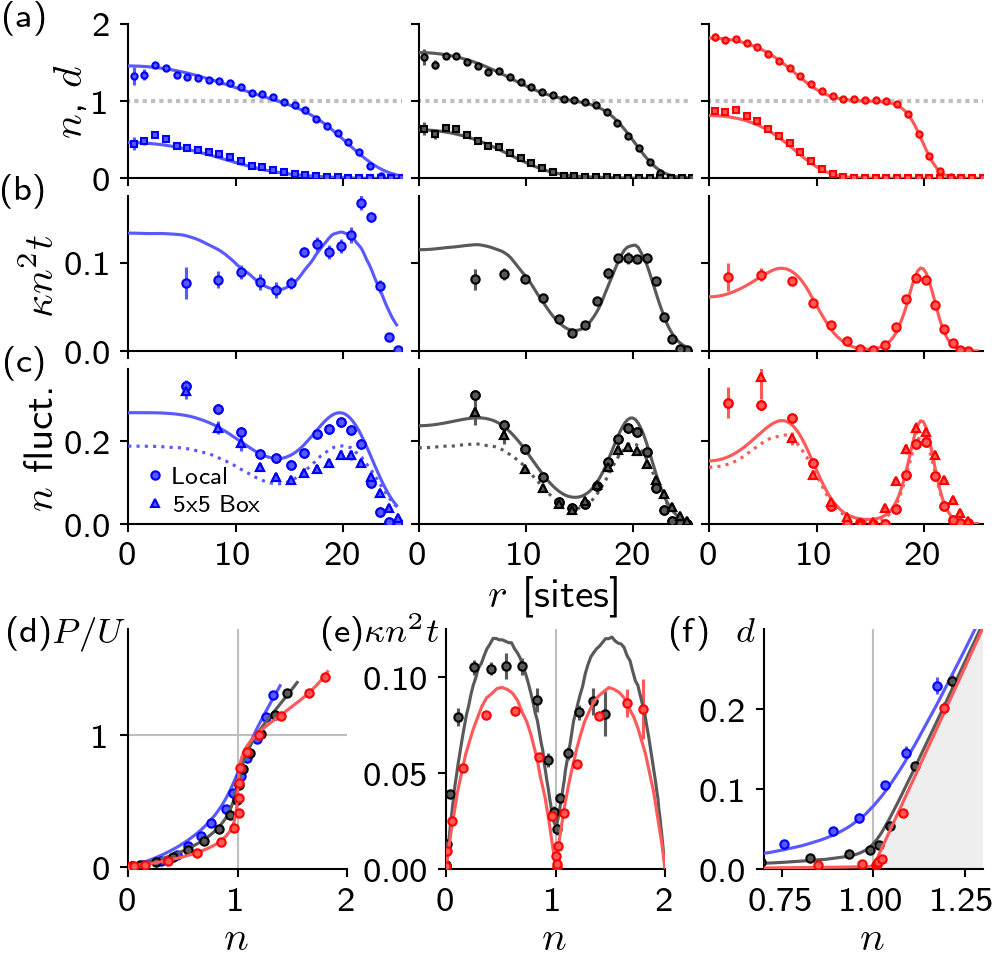

In [25]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
fig2 = plt.figure(figsize = [fig_size[0],fig_size[1]/golden_mean])
        
# some style choices
maxdDenPlotd = 0.4
minDenPlot = 0
maxDenPlot = 2

r1h = 0.435
rgr = 0.05 # row grout 
r2h = 0.435
r3h = 0.435
    
# Region for first few figures
# ax_pressure = fig2.add_subplot(2,1,2)

ax_nr1 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_nr2 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_nr3 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
anchorGraphInSubplot(ax_nr1, ax_nr1, relx=0.0, rely=1-r1h, relwidth=0.32, relheight=r1h)
anchorGraphInSubplot(ax_nr2, ax_nr2, relx=0.333+(0.333-0.32)/2, rely=1-r1h, relwidth=0.32, relheight=r1h)
anchorGraphInSubplot(ax_nr3, ax_nr3, relx=0.666+(0.333-0.32), rely=1-r1h, relwidth=0.32, relheight=r1h)
plt.setp(ax_nr2.get_yticklabels(), visible=False)
plt.setp(ax_nr3.get_yticklabels(), visible=False)

kappaHeight = 1-r1h-rgr-r2h
ax_kappar1 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_kappar2 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_kappar3 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
anchorGraphInSubplot(ax_kappar1, ax_kappar1, relx=0.0, rely=kappaHeight, relwidth=0.32, relheight=r2h)
anchorGraphInSubplot(ax_kappar2, ax_kappar2, relx=0.333+(0.333-0.32)/2, rely=kappaHeight, relwidth=0.32, relheight=r2h)
anchorGraphInSubplot(ax_kappar3, ax_kappar3, relx=0.666+(0.333-0.32), rely=kappaHeight, relwidth=0.32, relheight=r2h)
plt.setp(ax_kappar2.get_yticklabels(), visible=False)
plt.setp(ax_kappar3.get_yticklabels(), visible=False)

delnsqHeight =1-r1h-2*rgr-r2h-r3h
ax_delnsqr1 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_delnsqr2 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
ax_delnsqr3 = fig2.add_subplot(2,1,1, label = str(np.random.rand()))
anchorGraphInSubplot(ax_delnsqr1, ax_delnsqr1, relx=0.0, rely=delnsqHeight, relwidth=0.32, relheight=r3h)
anchorGraphInSubplot(ax_delnsqr2, ax_delnsqr2, relx=0.333+(0.333-0.32)/2, rely=delnsqHeight, relwidth=0.32, relheight=r3h)
anchorGraphInSubplot(ax_delnsqr3, ax_delnsqr3, relx=0.666+(0.333-0.32), rely=delnsqHeight, relwidth=0.32, relheight=r3h)
plt.setp(ax_delnsqr2.get_yticklabels(), visible=False)
plt.setp(ax_delnsqr3.get_yticklabels(), visible=False)

ax_pressure = fig2.add_subplot(2,1,2, label = str(np.random.rand()))
ax_kappa = fig2.add_subplot(2,1,2, label = str(np.random.rand()))
ax_nd = fig2.add_subplot(2,1,2, label = str(np.random.rand()))
r4h = r1h*1.55
anchorGraphInSubplot(ax_pressure, ax_pressure, relx=0.0, rely=0, relwidth=0.32, relheight=r4h)
anchorGraphInSubplot(ax_kappa, ax_kappa, relx=0.333+(0.333-0.32)/2, rely=0, relwidth=0.32, relheight=r4h)
anchorGraphInSubplot(ax_nd, ax_nd, relx=0.666+(0.333-0.32), rely=0, relwidth=0.32, relheight=r4h)
shrinkxFactor = 0.2
anchorGraphInSubplot(ax_pressure, ax_pressure, relx=0.0, rely=0.0, relwidth=1-shrinkxFactor, relheight=1)
anchorGraphInSubplot(ax_kappa, ax_kappa, relx=shrinkxFactor/2, rely=0.0, relwidth=1-shrinkxFactor, relheight=1)
anchorGraphInSubplot(ax_nd, ax_nd, relx=shrinkxFactor, rely=0.0, relwidth=1-shrinkxFactor, relheight=1)

offsetUpa = 0.1
offsetUpb = 0.1
offsetUpc = 0.1
ax_nr_lab1 = fig2.add_subplot(2,3,4, label = str(np.random.rand()))
ax_nr_lab1.axis('off')  
anchorGraphInSubplot(ax_nr1,ax_nr_lab1, 
                     relx=0 , rely=0.0, relwidth=1, relheight=1+offsetUpa)
ax_kappar_lab2 = fig2.add_subplot(2,3,5, label = str(np.random.rand()))
ax_kappar_lab2.axis('off')  
anchorGraphInSubplot(ax_kappar1,ax_kappar_lab2, 
                     relx=0 , rely=0.0, relwidth=1, relheight=1+offsetUpb)
ax_delnsqr_lab3 = fig2.add_subplot(2,3,6, label = str(np.random.rand()))
ax_delnsqr_lab3.axis('off')  
anchorGraphInSubplot(ax_delnsqr1,ax_delnsqr_lab3, 
                     relx=0 , rely=0.0, relwidth=1, relheight=1+offsetUpc)

labelSubplot(ax_nr_lab1,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_kappar_lab2,'(b)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_delnsqr_lab3,'(c)') # Annotate plot as (a), (b), and so on.
# Make fake labels for bottom three to not overlap.
offsetRighta = 0.025
offsetRightb = 0.0
offsetRightc = 0.125
offsetUp = 0.025
ax_EOS_lab1 = fig2.add_subplot(2,3,4, label = str(np.random.rand()))
ax_EOS_lab1.axis('off')  
anchorGraphInSubplot(ax_pressure,ax_EOS_lab1, 
                     relx=offsetRighta , rely=0.0, relwidth=1-offsetRighta , relheight=1+offsetUp)
ax_EOS_lab2 = fig2.add_subplot(2,3,5, label = str(np.random.rand()))
ax_EOS_lab2.axis('off')  
anchorGraphInSubplot(ax_kappa,ax_EOS_lab2, 
                     relx=offsetRightb , rely=0.0, relwidth=1-offsetRightb , relheight=1+offsetUp)
ax_EOS_lab3 = fig2.add_subplot(2,3,6, label = str(np.random.rand()))
ax_EOS_lab3.axis('off')  
anchorGraphInSubplot(ax_nd,ax_EOS_lab3, 
                     relx=offsetRightc , rely=0.0, relwidth=1-offsetRightc , relheight=1+offsetUp)
labelSubplot(ax_EOS_lab1,'(d)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_EOS_lab2,'(e)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_EOS_lab3,'(f)') # Annotate plot as (a), (b), and so on

# nr plots 
axArray = [ax_nr1, ax_nr2, ax_nr3]
for jjj in range(len(Fig2_RunIndToUse)) :
    axArray[jjj].errorbar(DQMC_r_rvals_Fig2[jjj],DQMC_Dens_rvals_Fig2[jjj],
                           xerr = None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray[jjj].errorbar(DQMC_r_rvals_Fig2[jjj],DQMC_dd_rvals_Fig2[jjj],
                           xerr = None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    # Full Density 
    axArray[jjj].errorbar(radialDensitiesArr_Fig2[jjj][0],radialDensitiesArr_Fig2[jjj][1],
                           xerr = None, yerr=radialDensitiesArr_Fig2[jjj][4],
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
    # Doublons 
    axArray[jjj].errorbar(radialDensitiesArr_Fig2[jjj][0],radialDensitiesArr_Fig2[jjj][2],
                       xerr = None, yerr=radialDensitiesArr_Fig2[jjj][5],
                       marker='s', linestyle = '', 
                       color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
              label = '_no_legend_', zorder = 40, linewidth= pgslinewidth, 
              markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
    axArray[jjj].plot([-0.2, 40], [1., 1.], marker = '', linestyle = (0,(1,1)), color="0.75")
    axArray[jjj].set_yticks([0,1,2])
    axArray[jjj].set_xticks([0,10,20])
    axArray[jjj].set_xticklabels(['','',''])
    axArray[jjj].set_xlim([0, 25.5])
    axArray[jjj].set_ylim([0, 2])
axArray[0].set_ylabel("$n$, $d$", 	labelpad = label_globalpad)

#kappa and fluct cutoff ind
kf_cutInd = 0

# kappa plots vs radius 
axArray3 = [ax_kappar1, ax_kappar2, ax_kappar3]
for jjj in range(len(Fig2_RunIndToUse)) :
    # Compressibility
    axArray3[jjj].errorbar(DQMC_r_rvals_Fig2[jjj],DQMC_kappa_rvals_Fig2[jjj],
                           xerr = None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray3[jjj].errorbar(rArr_Fig2[jjj][0][:],EOSArr_Fig2[jjj][3][:],
                           xerr = rArr_Fig2[jjj][1][:], yerr = EOSArr_Fig2[jjj][8][:],
                           marker='o', linestyle = 'none', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
#     axArray3[jjj].plot(fitsForComp_rr_Fig2[jjj],fitsForComp_kappa_Fig2[jjj], marker = '', linestyle = 'solid',
#                        color = xcolors[jjj],linewidth= pgslinewidth, zorder = -50,
#                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
    
# fitsForComp_rr_Fig2 = np.zeros((len(Fig2_RunIndToUse),lenForFits))
# fitsForComp_kappa_Fig2 = np.zeros((len(Fig2_RunIndToUse),lenForFits))

    axArray3[jjj].set_yticks([0,0.1])
    axArray3[jjj].set_xticks([0,10,20])
    axArray3[jjj].set_xticklabels(['','',''])
    axArray3[jjj].set_xlim([0, 25.5])
    axArray3[jjj].set_ylim([0, 0.175])
axArray3[0].set_ylabel("$\\kappa n^2 t$", 	labelpad = label_globalpad)

# density variance  plots 
axArray2 = [ax_delnsqr1, ax_delnsqr2, ax_delnsqr3]
for jjj in range(len(Fig2_RunIndToUse)) :
    # Local density variance 
    axArray2[jjj].errorbar(DQMC_r_rvals_Fig2[jjj],DQMC_deltan_rvals_Fig2[jjj],
                           xerr = None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = '_no_legend_', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].errorbar(DQMC_r_rvals_Fig2[jjj],DQMC_deltantotal_rvals_Fig2[jjj],
                           xerr = None, yerr = None,
                           marker='', linestyle = 'dotted', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = '_no_legend_', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].errorbar(rArr_Fig2[jjj][0][:],delNSqAvgOvAreaArr_Fig2[jjj][0][:],
                           xerr = rArr_Fig2[jjj][1][:], yerr = delNSqAvgOvAreaArr_Fig2[jjj][3][:], 
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = '_no_legend_', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].errorbar(rArr_Fig2[jjj][0][:],delNSqAvgOvAreaArr_Fig2[jjj][2][:], 
                           xerr = rArr_Fig2[jjj][1][:], yerr = delNSqAvgOvAreaArr_Fig2[jjj][5][:], 
                           marker='^', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = '_no_legend_', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].plot(rArr_Fig2[jjj][0][:],delNSqAvgOvAreaArr_Fig2[jjj][0][:],
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = 'Local', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].plot(rArr_Fig2[jjj][0][:],delNSqAvgOvAreaArr_Fig2[jjj][2][:], 
                           marker='^', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = '5x5 Box', zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
#     axArray2[jjj].errorbar(rArr_Fig2[jjj][0][:-1],delNSqAvgOvAreaArr_Fig2[jjj][1][:-1], 
#                            xerr = rArr_Fig2[jjj][1][:-1], yerr = delNSqAvgOvAreaArr_Fig2[jjj][4][:-1], 
#                            marker='s', linestyle = '', 
#                            color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
#                   label = '$3\\times 3$', zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    axArray2[jjj].set_yticks([0,0.2])
    axArray2[jjj].set_xticks([0,10,20])
#     axArray2[jjj].set_xticklabels(['','',''])
    axArray2[jjj].set_xlim([0, 25.5])
    axArray2[jjj].set_ylim([0, 0.375])
axArray2[0].set_ylabel("$n$ fluct.", 	labelpad = label_globalpad)
axArray2[1].set_xlabel("$r$ [sites]", 	labelpad = label_globalpad)
axArray2[0].legend(frameon=False,fancybox=False, borderpad=0.1, 
                   handletextpad= 0,fontsize = 'xx-small', loc = 'lower left')

for jjj in range(len(Fig2_RunIndToUse)) :
    # Doublons 
    ax_nd.errorbar(DQMC_Dens_Fig2[jjj],DQMC_dd_Fig2[jjj],
                           xerr =None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    ax_nd.errorbar(EOSArr_Fig2[jjj][1],EOSArr_Fig2[jjj][4],
                           xerr = EOSArr_Fig2[jjj][6], yerr = EOSArr_Fig2[jjj][9],
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_nd.plot([1,1],[-4,4], color = '0.75', linewidth = 0.5, marker ='', linestyle = 'solid',zorder=-50)
# ax_nd.set_ylabel("$\\langle \\hat{d} \\rangle$", 	labelpad = label_globalpad)
ax_nd.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_nd.set_xlim([0.7,1.3])
ax_nd.set_yticks([0,0.1,0.2])
ax_nd.set_ylim([0,0.3])
ax_nd.fill_between([1, 2], [0., 1], [0,0], 
                         facecolor = "0.75", edgecolor = None, alpha = 0.25)
ax_nd.annotate('$d$', xy=(-0.035,1.05), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='right', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

for jjj in [1,2]: # range(len(Fig2_RunIndToUse)) :
    # Kappa
    ax_kappa.errorbar(DQMC_Dens_Fig2[jjj],DQMC_kappa_Fig2[jjj],
                           xerr =None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    ax_kappa.errorbar(EOSArr_Fig2[jjj][1],EOSArr_Fig2[jjj][3],
                           xerr = EOSArr_Fig2[jjj][6], yerr = EOSArr_Fig2[jjj][8],
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
#     ax_kappa.plot(fitsForComp_n_Fig2[jjj],fitsForComp_kappa_Fig2[jjj], marker = '', linestyle = 'solid',
#                        color = xcolors[jjj],linewidth= pgslinewidth, zorder = -50,
#                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
ax_kappa.plot([1,1],[-4,4], color = '0.75', linewidth = 0.5, marker ='', linestyle = 'solid',zorder=-50)
# ax_kappa.set_ylabel("$\\tilde{\\kappa}t$", 	labelpad = label_globalpad)
ax_kappa.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_kappa.set_yticks([0,0.05,0.1])
ax_kappa.set_xlim([minDenPlot,maxDenPlot])
ax_kappa.set_ylim([0,0.125])
# ax_kappa.set_ylim([0,0.14])
ax_kappa.annotate('$\\kappa n^2 t$', xy=(-0.025,1.05), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='right', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# Find max values to plot for DQMC pressure and density and things. 
# pmax0 = np.argmax(DQMC_Dens_Fig2[0][np.where(DQMC_Dens_Fig2[0] < np.max(EOSArr_Fig2[0][1]))])+1
# pmax1 = np.argmax(DQMC_Dens_Fig2[1][np.where(DQMC_Dens_Fig2[1] < np.max(EOSArr_Fig2[1][1]))])+1
# pmax2 = np.argmax(DQMC_Dens_Fig2[2][np.where(DQMC_Dens_Fig2[2] < np.max(EOSArr_Fig2[2][1]))])+1
pmax0 = np.argmax(DQMC_Dens_Fig2[0][np.where(DQMC_Dens_Fig2[0] < 1.4)])+1
pmax1 = np.argmax(DQMC_Dens_Fig2[1][np.where(DQMC_Dens_Fig2[1] < 1.55)])+1
pmax2 = np.argmax(DQMC_Dens_Fig2[2][np.where(DQMC_Dens_Fig2[2] < 1.825)])+1
pmaxArr= [pmax0, pmax1, pmax2]

for jjj in range(len(Fig2_RunIndToUse)) :
    # Pressure
    ax_pressure.errorbar(DQMC_Dens_Fig2[jjj][:pmaxArr[jjj]],DQMC_Pressure_Fig2[jjj][:pmaxArr[jjj]],
                           xerr =None, yerr = None,
                           marker='', linestyle = 'solid', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
    ax_pressure.errorbar(EOSArr_Fig2[jjj][1],EOSArr_Fig2[jjj][2],
                           xerr = EOSArr_Fig2[jjj][6], yerr = EOSArr_Fig2[jjj][7],
                           marker='o', linestyle = '', 
                           color = xcolors[jjj], mec = tuple(xedgecolors[jjj]),
                  label = Fig2_RunIndToUse[jjj], zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_pressure.plot([1,1],[-2,2], color = '0.75', linewidth = 0.5, marker ='', linestyle = 'solid',zorder=-50)
ax_pressure.plot([-2,2],[1,1], color = '0.75', linewidth = 0.5, marker ='', linestyle = 'solid',zorder=-50)
# ax_pressure.set_ylabel("$P/U$", 	labelpad = label_globalpad)
ax_pressure.set_xlabel("$n$", 	labelpad = label_globalpad)
# ax_pressure.set_yticks([0,1])
ax_pressure.set_xlim([minDenPlot,maxDenPlot])
ax_pressure.set_ylim([-0.01*1.8,1.8])

ax_pressure.annotate('$P/U$', xy=(-0.025,1.05), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='right', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig2.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('Fig2.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

## Figure 3

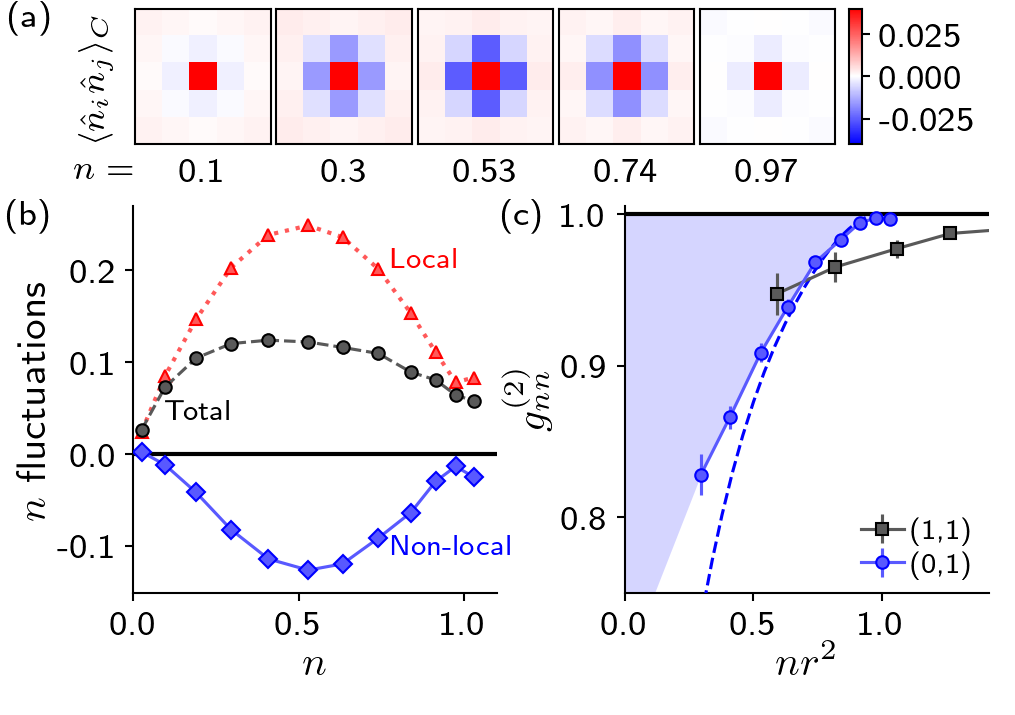

In [133]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
fig3 = plt.figure(figsize = [fig_size[0],fig_size[1]*1.6])
figAspect = fig_size[0]/(fig_size[1]*1.6)

sub0 = fig3.add_subplot(1,1,1, label = str(np.random.rand()))
sub0.axis('off')  

subjunk = fig3.add_axes((0,0,1,1), label = str(np.random.rand()))
subjunk.axis('off')  
# to not cut off left side
anchorGraphInSubplot(subjunk,subjunk, relx=0.0, rely=0, 
                     relwidth=1, relheight=0.2)

# some style choices
DQMC01linestyle = 'dashed'
DQMC11linestyle = 'dashed'
NonIntFermionslinestyle = 'solid'
NonIntFermions1Specieslinestyle ='dotted'
DQMC01color = tuple(xedgecolors[0])
DQMC11color = 'deepskyblue'
NonIntFermionscolor = tuple(xedgecolors[2])
# 2D img arrays for display 
numcols = len(nArr_Fig3_matsExpIndToDisplay)
numrows = 1
axArray = [[None for junkind in range(numcols)] for x in range(numrows)]
imgArrayTop = 0.70
imgArrayRight=0.825
imgArrayLeft=0.0
imgArrayHorizSpace = (imgArrayRight-imgArrayLeft)/numcols
imgArrayBot = imgArrayTop- numrows*imgArrayHorizSpace
imgArrayVertSpace = imgArrayHorizSpace*figAspect
imgGrout = 0.0025
vminPlotnnij2D = -0.04
vmaxPlotnnij2D = -vminPlotnnij2D
# Moving up bottom a bit 
stretchBotFactor = 1.1

markerSum = 'o'
marker3x3= 's'
marker1x1 = '^'
markerNonLoc = 'D'
alphaSum = 1; # How transparent? 
alphaLoc= 1
alphaNonLoc = 1


ax_StuffvsN = fig3.add_subplot(2,2,3, label = str(np.random.rand()))
ax_g2 = fig3.add_subplot(2,2,4, label = str(np.random.rand()))
anchorGraphInSubplot(ax_StuffvsN, ax_StuffvsN, relx=0.0, rely=0, 
                     relwidth=1, relheight=stretchBotFactor)
anchorGraphInSubplot(ax_g2, ax_g2, relx=0.0, rely=0, 
                     relwidth=1, relheight=stretchBotFactor)
# Make array for images shown 
for rowind in range(numrows):
    for colind in range(numcols): 
        axArray[rowind][colind] = fig3.add_axes([0,0,0,0], label = str(np.random.rand()))
        setupImgDisplay(axArray[rowind][colind], xedgecolors[1]) # make it look pretty 
        anchorGraphInSubplot(sub0, axArray[rowind][colind], 
                             imgArrayLeft+imgArrayHorizSpace*colind +imgGrout, 
                             imgArrayBot+ imgArrayVertSpace*(numrows-1-rowind)+imgGrout, 
                             imgArrayHorizSpace-2*imgGrout, imgArrayVertSpace-2*imgGrout)
        axArray[rowind][colind].annotate(np.around(nArr_Fig3_matsToDisplay[colind],2), 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(0.5,-0.1), 
                    textcoords='axes fraction', verticalalignment='top', horizontalalignment='center', 
                    fontsize=subplotlabelfontsize);
#annotate bottom left and left of whole thing
denWords = '$n =$'
titleWords = '$\\langle \\hat{n}_i \\hat{n}_{j} \\rangle_C$'
axArray[0][0].annotate(denWords, 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(0,-0.075), 
                    textcoords='axes fraction', verticalalignment='top', horizontalalignment='right', 
                    fontsize=subplotlabelfontsize);
axArray[0][0].annotate(titleWords, 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(-0.15,0.5), 
                    textcoords='axes fraction', rotation=90, verticalalignment='center', horizontalalignment='right', 
                    fontsize=subplotlabelfontsize);
  
anchorGraphInSubplot(sub0, sub0, relx=0, rely=0, 
                     relwidth=1, relheight=imgArrayTop)
labelSubplot(sub0,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_StuffvsN,'(b)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_g2,'(c)') # Annotate plot as (a), (b), and so on.

# 2D image plots
for rowind in range(numrows):
    for colind in range(numcols): 
        if rowind == 0 : # experiment
            axArray[rowind][colind].imshow(nnij_c_matsToDisplay_Fig3[colind], cmap='bwr', 
                                           vmin=vminPlotnnij2D, vmax=vmaxPlotnnij2D)
        elif rowind ==1 : # DQMC
            axtemp = axArray[rowind][colind].imshow(nnij_c_mats_DQMC[DQMCConvExpIndToDQMCInd[nArr_Fig3_matsnnij_c_mat_nExpIndToDisplay[colind]]],
                                           # colind is which graph, nnij_c_mat_nExpIndToDisplay says which of exp indices
                                           # DQMCConvExpIndToDQMCInd converts that experimental ind to which DQMC is closest
                                           cmap='bwr', 
                                           vmin=vminPlotnnij2D, vmax=vmaxPlotnnij2D)
# Add colorbar
# Colorbar 
ax_cb = fig3.add_axes((1,1,1,1), label = str(np.random.rand()));
ax_cb.spines['right'].set_visible(True)
ax_cb.spines['top'].set_visible(True)
plt.setp(ax_cb.get_xticklabels(), visible=False)
ax_cb.tick_params(axis='x', which='both', length=0)
c_range=vmaxPlotnnij2D
ax_cb.imshow(np.asarray([np.linspace(c_range, -1*c_range, 1000)]).transpose(),
             extent=[-c_range, c_range, -c_range, c_range],
             vmin=-1.0*c_range, vmax=1.0*c_range, cmap='bwr')
ax_cb.yaxis.tick_right()
    # move it over a little to left
anchorGraphInSubplot(axArray[numrows-1][numcols-1], ax_cb, relx=1.1, rely=0, 
                     relwidth=0.1, relheight=1)


# Don't show all the densities. we don't trust things too low
minDenInd = 1

# Stuff vs n
for thisRunInd in [0]:
    # Locals
    ax_StuffvsN.errorbar(EOSArr_Fig3[thisRunInd][1][minDenInd:], nnij_c_sumsArr_Fig3[thisRunInd][1][minDenInd:], 
                         xerr = EOSArr_Fig3[thisRunInd][6][minDenInd:], yerr=nnij_c_sumsArr_Fig3[thisRunInd][4][minDenInd:],
                         color = xcolors[2], mec = tuple(xedgecolors[2]), 
                         marker = marker1x1, alpha = alphaLoc,linestyle = 'dotted',
                         markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
                         label = '$\\delta N^2_{1\\times 1}/$Area',
                         zorder = 42)#, **errorbar_global_style)
    # Connecte correlator sum
    ax_StuffvsN.errorbar(EOSArr_Fig3[thisRunInd][1][minDenInd:], nnij_c_sumsArr_Fig3[thisRunInd][0][minDenInd:], 
                         xerr = EOSArr_Fig3[thisRunInd][6][minDenInd:], yerr=nnij_c_sumsArr_Fig3[thisRunInd][3][minDenInd:],
                         color = xcolors[1], mec = tuple(xedgecolors[1]), 
                         marker = markerSum, alpha = alphaSum, linestyle = 'dashed',
                         markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
                         label = '$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$',# '$\\delta n^2_{\\rm{tot}}$',
                         zorder = 43, **errorbar_global_style)
    # nonlocals 
    ax_StuffvsN.errorbar(EOSArr_Fig3[thisRunInd][1][minDenInd:], nnij_c_sumsArr_Fig3[thisRunInd][2][minDenInd:], 
                         xerr = EOSArr_Fig3[thisRunInd][6][minDenInd:], yerr=nnij_c_sumsArr_Fig3[thisRunInd][5][minDenInd:],
                         color = xcolors[0], mec = tuple(xedgecolors[0]), 
                         marker = markerNonLoc, alpha = alphaSum, linestyle = 'solid',
                         markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
                         label = '$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$',# '$\\delta n^2_{\\rm{tot}}$',
                         zorder = 43, **errorbar_global_style)

#     # DQMC nonlocals 
#     ax_StuffvsN.errorbar(DQMC_Final_Dens_Fig3, DQMC_Final_deltanonloc_Fig3, 
#                          xerr = None, yerr = None,
#                          color = xcolors[0], mec = tuple(xedgecolors[0]), 
#                          marker = '', alpha = alphaSum, linestyle = 'solid',
#                          markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                          label = '$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)
#     # DQMC locals 
#     ax_StuffvsN.errorbar(DQMC_Final_Dens_Fig3, DQMC_Final_deltan_Fig3, 
#                          xerr = None, yerr = None,
#                          color = xcolors[2], mec = tuple(xedgecolors[2]), 
#                          marker = '', alpha = alphaSum, linestyle = 'solid',
#                          markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                          label = '$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)
#     # DQMC totals 
#     ax_StuffvsN.errorbar(DQMC_Final_Dens_Fig3, DQMC_Final_deltan_Fig3+DQMC_Final_deltanonloc_Fig3, 
#                          xerr = None, yerr = None,
#                          color = xcolors[1], mec = tuple(xedgecolors[1]), 
#                          marker = '', alpha = alphaSum, linestyle = 'solid',
#                          markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                          label = '$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)

ax_StuffvsN.plot([0,4],[0,0], color = 'black', linestyle = 'solid', marker = '')
ax_StuffvsN.set_xticks([0,0.5,1])
ax_StuffvsN.set_xlim([0,1.1])
# ax_StuffvsN.set_ylim([-0.035,-0.02*(-0.035)])
ax_StuffvsN.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_StuffvsN.set_ylabel("$n$ fluctuations", 	labelpad = label_globalpad)
# ax_StuffvsN.legend()


ax_StuffvsN.annotate('Local', xy=(EOSArr_Fig3[thisRunInd][1][minDenInd:][7], 
                                  nnij_c_sumsArr_Fig3[thisRunInd][1][minDenInd:][7]), xycoords='data',
               xytext=(3,-1), 
               textcoords='offset points', verticalalignment='bottom', horizontalalignment='left', 
               fontsize='x-small',
                 color = xedgecolors[2])
ax_StuffvsN.annotate('Non-local', xy=(EOSArr_Fig3[thisRunInd][1][minDenInd:][7], 
                                      nnij_c_sumsArr_Fig3[thisRunInd][2][minDenInd:][7]), xycoords='data',
               xytext=(3,1), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize='x-small',
                 color = xedgecolors[0])
ax_StuffvsN.annotate('Total', xy=(EOSArr_Fig3[thisRunInd][1][minDenInd:][1], 
                                      nnij_c_sumsArr_Fig3[thisRunInd][0][minDenInd:][1]), xycoords='data',
               xytext=(0,-3), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize='x-small',
                 color = xedgecolors[1])



# Don't show all the densities. we don't trust things too low
minDenInd = 4
# nng2 plots 
# experiment
# Coldest 
ax_g2.errorbar(2*nArr_Fig3_mats[minDenInd:],nng211_Fig3[minDenInd:],
                           xerr = None, yerr = nng211_err_Fig3[minDenInd:],
                       marker='s', linestyle = 'solid', 
                       color = xcolors[1], mec = xedgecolors[1],
              label = "(1,1)", zorder = 40, linewidth= pgslinewidth, 
              markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth)
ax_g2.errorbar(nArr_Fig3_mats[minDenInd:],nng201_Fig3[minDenInd:],
                           xerr = None, yerr = nng201_err_Fig3[minDenInd:],
                       marker='o', linestyle = 'solid', 
                       color = xcolors[0], mec = tuple(xedgecolors[0]),
              label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
              markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth)
junk1vals = np.ones(len(nArr_Fig3_mats[minDenInd:]))
ax_g2.fill_between(np.insert(nArr_Fig3_mats[minDenInd:],0,0),np.insert(nng201_Fig3[minDenInd:],0,0.7),
                 np.insert(junk1vals,0,1), color = xcolors[0], alpha=0.25, zorder= -500, linewidth = 0.0)
# # Non interacting theory

ax_g2.plot(nonIntg2nn_1Component_Fig3[0],nonIntg2nn_1Component_Fig3[1],
                           marker='', linestyle = 'dashed', 
                           color = xedgecolors[0], 
                  label = "_no_legend", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
# ax_g2.plot(nonIntg2nn_2Component_Fig3[0],nonIntg2nn_2Component_Fig3[1],
#                            marker='', linestyle = 'dotted', 
#                            color = xedgecolors[1], 
#                   label = "_no_legend", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
# ax_g2.plot(DQMC_Final_Dens_Fig3,DQMC_Final_g2nn_Fig3,
#                            marker='', linestyle = DQMC01linestyle, 
#                            color = xcolors[0], 
#                   label = "_no_legend_", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth)
ax_g2.plot([0,4],[1,1], color = 'black', linestyle = 'solid', marker = '')
ax_g2.set_yticks([0.8, 0.9,1.0])
ax_g2.set_xticks([0,0.5,1,1.5,2,3,4])
ax_g2.set_xlim([0.0,np.sqrt(2)])
ax_g2.set_ylim([0.75,1.00+0.02*(1-0.75)])
ax_g2.legend(loc = 'lower right')
ax_g2.set_xlabel("$n r^2$", 	labelpad = label_globalpad)
ax_g2.set_ylabel("$g^{(2)}_{nn}$", 	labelpad = label_globalpad)


# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig3.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('Fig3.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

## Figure 4

0.6852826634576606 0.015969542858327145
0.8534236864982964 0.039939303804073116
1.2387259696004675 0.08299851892434996
Fluct
[0.68528266 0.85342369 1.23872597] [0.01596954 0.0399393  0.08299852]
Theory
[0.56880802 0.70495497 1.17019237] [0.04341826 0.07791915 0.11871121]


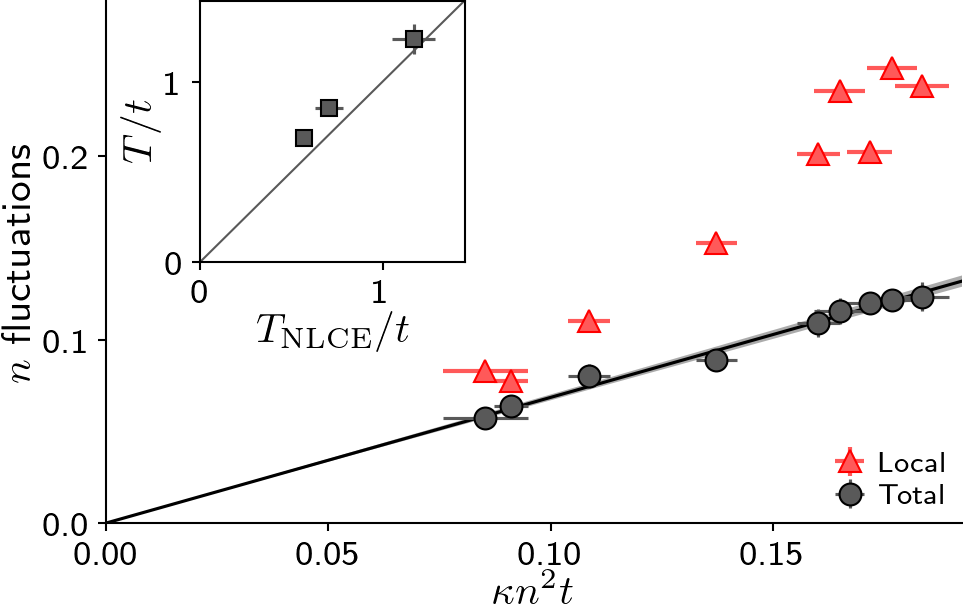

In [29]:
# with junk temp inset

######### Now plotting figure
    # Can adjust figure size in style area above if you want. 
fig4 = plt.figure(figsize = [fig_size[0],fig_size[1]*1.0])

# sub0 = fig4.add_axes((0,0,1,1), label = str(np.random.rand()))
# sub0.axis('off')  # random things so I can move it in 

ax_CvsKappa = fig4.add_subplot(1,1,1, label = str(np.random.rand()))
ax_Therm = fig4.add_subplot(4,4,9)
ax_Therm.spines['right'].set_visible(True)
ax_Therm.spines['top'].set_visible(True)

anchorGraphInSubplot(ax_CvsKappa,ax_CvsKappa, relx=0.00, rely=0.0, 
                     relwidth=1, relheight= 1)
# anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.11, rely=0.54, 
#                      relwidth=0.525, relheight= 0.45)
anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.11, rely=0.5, 
                     relwidth=0.5*fig_size[1]/fig_size[0], relheight= 0.5)

# Color choices and other formatting 
cteq0 = 0
cteq1 = 1
cteq2 = 2 
cArr = [cteq0,cteq1,cteq2]
markerSum = 'o'
marker5x5= 's'
marker1x1 = '^'
markerNonLoc = 'D'
linestyleSum = ''
linestyle5x5= ''
linestyle1x1 = ''
colorIndSum = 1
colorInd5x5= 0
colorInd1x1 = 2
alphaSum = 1; # How transparent? 
alphaLoc= 1
alphaNonLoc = 1
locMarkerScaling = 0.5; 

# nArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'nArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # hole singlon doublon full density
# delNSqAvgOvNArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'delNSqAvgOvNArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # 1x1, 5x5, then 5x5
# delNSqAvgOvAreaArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'delNSqAvgOvAreaArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # 1x1, 5x5, then 5x5
# TovertArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'TovertArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# Tovert_cutoffArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'Tovert_cutoffArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# EOSArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'EOSArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # mu, full density,P_vsn, kappa_vsn, doublon density
# nnij_c_sumsArr_Fig4 = [np.loadtxt(
#     os.path.join(data_dir, 'nnij_c_sumsArr_Heating_'+str(_Heating)+'.txt'))
#           for _Heating in Fig4_Heating_IndToUse]
#     # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]

globaldensityCutoffForPlotting=0.2
markerSizeForFluct = 1.75

# Sum of correlator vs kappa
for thisRunInd in [0]:
    densityFromEOS = EOSArr_Fig4[thisRunInd][1]
    densityCutoffForPlotting = globaldensityCutoffForPlotting # only greater than this
    dIndsPlot = np.where(densityFromEOS>densityCutoffForPlotting)
    dIndsPlotSmallDen = np.where(densityFromEOS<=densityCutoffForPlotting)
    # High density datapoints
    # Locals
    ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][1][dIndsPlot], 
                         xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][4][dIndsPlot],
                         color = xcolors[colorInd1x1], mec = tuple(xedgecolors[colorInd1x1]), 
                         marker = marker1x1, alpha = alphaLoc,linestyle = linestyle1x1,
                         markersize = pgsmarkersize*markerSizeForFluct, markeredgewidth = pgsmarkeredgewidth,
                         label = 'Local',
                         zorder = 42)#, **errorbar_global_style)
#     # 5x5 box
#     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], delNSqAvgOvAreaArr_Fig4[thisRunInd][2][dIndsPlot], 
#                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=delNSqAvgOvAreaArr_Fig4[thisRunInd][5][dIndsPlot],
#                          color = xcolors[colorInd5x5], mec = tuple(xedgecolors[colorInd5x5]), 
#                          marker = marker5x5, alpha = alphaLoc,linestyle = linestyle5x5,
#                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
#                          label = '5x5 Box',#'$3\\times3$ box',
#                          zorder = 42)#, **errorbar_global_style)
    # Connected correlator sum
    ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][0][dIndsPlot], 
                         xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][3][dIndsPlot],
                         color = xcolors[colorIndSum], mec = tuple(xedgecolors[colorIndSum]), 
                         marker = markerSum, alpha = alphaSum, linestyle = linestyleSum,
                         markersize = pgsmarkersize*markerSizeForFluct, markeredgewidth = pgsmarkeredgewidth,
                         label = 'Total',# '$\\delta n^2_{\\rm{tot}}$',
                         zorder = 43, **errorbar_global_style)
    #'$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$'
    ax_CvsKappa.plot([0,5], [0, 5*Tovert_cutoffArr_Fig4[thisRunInd][0][0]], '-', color = xedgecolors[colorIndSum], 
                     zorder=40, linewidth= pgslinewidth)
    ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0])],
                             [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0])], 
                              facecolor = xcolors[cArr[1]], edgecolor = None, alpha = 0.5)
    
    #print((Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0]),
    #(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0]))
    
    #ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]-Tovert_TtheoryCompArr_Fig4[1][0])],
    #                         [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]+Tovert_TtheoryCompArr_Fig4[1][0])], 
    #                          facecolor = xcolors[cArr[1]], edgecolor = None, alpha = 0.5)

    # # NonLocals
    # ax_CvsKappa.fill_between(EOSArr_Fig4[thisRunInd][2],
    #                          nnij_c_sumsArr_Fig4[thisRunInd][0], nnij_c_sumsArr_Fig4[thisRunInd][1], 
    #                          facecolor = xcolors[cArr[thisRunInd]], edgecolor = None, alpha = 0.5)
    # ax_CvsKappa.errorbar(KappaVsDensity[thisRunInd][1], delnSqVsDensity[thisRunInd][2], 
    #                      xerr = KappaVsDensity[thisRunInd][3], yerr=delnSqVsDensity[thisRunInd][6],
    #                      color = xcolors[cArr[thisRunInd]], mec = tuple(xedgecolors[cArr[thisRunInd]]), 
    #                      marker = markerNonLoc, alpha = alphaNonLoc,linestyle = 'dotted',
    #                      markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth,
    #                      zorder = 42, **errorbar_global_style)
ax_CvsKappa.set_yticks([0,0.1,0.2,0.3])
ax_CvsKappa.set_xticks([0,0.05,0.1,0.15,0.2])
ax_CvsKappa.set_xlim(0.0,0.1925) # (0.0,0.195) 
ax_CvsKappa.set_ylim(0,0.285) # (0,0.255) 
ax_CvsKappa.set_ylabel("$n$ fluctuations", labelpad = label_globalpad)
ax_CvsKappa.set_xlabel("$\\kappa n^2 t $",labelpad = label_globalpad)
ax_CvsKappa.legend(loc='lower right',ncol=1)

print(Tovert_cutoffArr_Fig4[0][0][0], Tovert_cutoffArr_Fig4[0][1][0])

print(Tovert_cutoffArr_Fig4[1][0][0],Tovert_cutoffArr_Fig4[1][1][0])

print(Tovert_cutoffArr_Fig4[2][0][0],Tovert_cutoffArr_Fig4[2][1][0])


# # Temperature
# Convert temperature vs run to a single array
# waitTimeVals = [0,0.25,0.5,1.25,2]
# waitTimeRunInds = [0,1,2,3,4]
waitTimeVals = [0,1,2]
waitTimeRunInds = [0,1,2]
arrTempnnij = np.array([Tovert_cutoffArr_Fig4[_runInd][0][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
arrTemp1x1 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][1] for _runInd in waitTimeRunInds])
arrTemp5x5 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][3] for _runInd in waitTimeRunInds])
arrTempnnij_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
arrTemp1x1_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][1] for _runInd in waitTimeRunInds])
arrTemp5x5_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][3] for _runInd in waitTimeRunInds])

# print(arrTempnnij)
# print(arrTempnnij_err)

# ax_Therm.errorbar(junktemps, arrTemp1x1, xerr = junktemps_err, yerr=arrTemp1x1_err, 
#                   color = xcolors[colorInd1x1], mec = tuple(xedgecolors[colorInd1x1]), 
#                      marker = marker1x1, alpha = alphaSum,
#                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                   linestyle = linestyle1x1,
#                      zorder = 43, **errorbar_global_style)
# ax_Therm.errorbar(waitTimeVals, arrTemp5x5, xerr = None, yerr=arrTemp5x5_err,  
#                   color = xcolors[colorInd5x5], mec = tuple(xedgecolors[colorInd5x5]), 
#                      marker = marker5x5, alpha = alphaSum,
#                   linestyle = linestyle5x5,
#                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)

ax_Therm.errorbar(Tovert_TtheoryCompArr_Fig4[1], arrTempnnij, 
                  xerr = Tovert_TtheoryCompArr_Fig4[3], yerr=arrTempnnij_err, 
                  color = xcolors[colorIndSum], mec = tuple(xedgecolors[colorIndSum]), 
                     marker = 's', alpha = alphaSum,
                  linestyle = linestyleSum,
                     markersize = pgsmarkersize*1.25, markeredgewidth = pgsmarkeredgewidth,
                     zorder = 43, **errorbar_global_style)

# ax_Therm.errorbar(Tovert_TtheoryCompArr_Fig4[1], arrTempnnij, 
#                   xerr = Tovert_TtheoryCompArr_Fig4[3], yerr=arrTempnnij_err, 
#                   color = xcolors[0], mec = tuple(xedgecolors[0]), 
#                      marker = 'o', alpha = alphaSum,
#                   linestyle = linestyleSum,
#                      markersize = pgsmarkersize*1.0, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)

ax_Therm.plot([0,5], [0,5], linestyle = '-', marker = '', linewidth = 0.5, color = xcolors[1], zorder = -50)
ax_Therm.set_ylabel('$T/t$', 			labelpad = label_globalpad)
ax_Therm.set_xlabel('$T_{\\rm NLCE}/t$', 	labelpad = label_globalpad)
# ax_Therm.set_yticks([0,0.05,0.1])
ax_Therm.set_xticks([0,1,2])
ax_Therm.set_yticks([0,1,2])
ax_Therm.set_xlim(0.0, 1.45)
ax_Therm.set_ylim(0.0, 1.45)

print("Fluct")
print(arrTempnnij,arrTempnnij_err)
print("Theory")
print(Tovert_TtheoryCompArr_Fig4[1],Tovert_TtheoryCompArr_Fig4[3])

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('Fig4.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [81]:
# # with junk temp inset

# ######### Now plotting figure
#     # Can adjust figure size in style area above if you want. 
# fig4 = plt.figure(figsize = [fig_size[0],fig_size[1]*1.0])

# # sub0 = fig4.add_axes((0,0,1,1), label = str(np.random.rand()))
# # sub0.axis('off')  # random things so I can move it in 

# ax_CvsKappa = fig4.add_subplot(1,1,1, label = str(np.random.rand()))
# ax_Therm = fig4.add_subplot(4,4,9)
# ax_Therm.spines['right'].set_visible(True)
# ax_Therm.spines['top'].set_visible(True)

# anchorGraphInSubplot(ax_CvsKappa,ax_CvsKappa, relx=0.00, rely=0.0, 
#                      relwidth=1, relheight= 1)
# # anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.11, rely=0.54, 
# #                      relwidth=0.525, relheight= 0.45)
# anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.11, rely=0.5, 
#                      relwidth=0.5*fig_size[1]/fig_size[0], relheight= 0.5)

# # Color choices and other formatting 
# cteq0 = 0
# cteq1 = 1
# cteq2 = 2 
# cArr = [cteq0,cteq1,cteq2]
# markerSum = 'o'
# marker5x5= 's'
# marker1x1 = '^'
# markerNonLoc = 'D'
# linestyleSum = ''
# linestyle5x5= ''
# linestyle1x1 = ''
# colorIndSum = 1
# colorInd5x5= 0
# colorInd1x1 = 2
# alphaSum = 1; # How transparent? 
# alphaLoc= 1
# alphaNonLoc = 1
# locMarkerScaling = 0.5; 

# # nArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'nArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # hole singlon doublon full density
# # delNSqAvgOvNArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'delNSqAvgOvNArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # 1x1, 5x5, then 5x5
# # delNSqAvgOvAreaArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'delNSqAvgOvAreaArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # 1x1, 5x5, then 5x5
# # TovertArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'TovertArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# # Tovert_cutoffArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'Tovert_cutoffArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# # EOSArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'EOSArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # mu, full density,P_vsn, kappa_vsn, doublon density
# # nnij_c_sumsArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'nnij_c_sumsArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]

# globaldensityCutoffForPlotting=0.25


# # Sum of correlator vs kappa
# for thisRunInd in [0,1,2]:
#     densityFromEOS = EOSArr_Fig4[thisRunInd][1]
#     densityCutoffForPlotting = globaldensityCutoffForPlotting # only greater than this
#     dIndsPlot = np.where(densityFromEOS>densityCutoffForPlotting)
#     dIndsPlotSmallDen = np.where(densityFromEOS<=densityCutoffForPlotting)
#     # High density datapoints
#     # Locals
# #     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][1][dIndsPlot], 
# #                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][4][dIndsPlot],
# #                          color = xcolors[colorInd1x1], mec = tuple(xedgecolors[colorInd1x1]), 
# #                          marker = marker1x1, alpha = alphaLoc,linestyle = linestyle1x1,
# #                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
# #                          label = 'Local',
# #                          zorder = 42)#, **errorbar_global_style)
# #     # 5x5 box
# #     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], delNSqAvgOvAreaArr_Fig4[thisRunInd][2][dIndsPlot], 
# #                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=delNSqAvgOvAreaArr_Fig4[thisRunInd][5][dIndsPlot],
# #                          color = xcolors[colorInd5x5], mec = tuple(xedgecolors[colorInd5x5]), 
# #                          marker = marker5x5, alpha = alphaLoc,linestyle = linestyle5x5,
# #                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
# #                          label = '5x5 Box',#'$3\\times3$ box',
# #                          zorder = 42)#, **errorbar_global_style)
#     # Connected correlator sum
#     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][0][dIndsPlot], 
#                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][3][dIndsPlot],
#                          color = xcolors[thisRunInd], mec = tuple(xedgecolors[thisRunInd]), 
#                          marker = markerSum, alpha = alphaSum, linestyle = linestyleSum,
#                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
#                          label = 'Total',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)
#     #'$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$'
#     ax_CvsKappa.plot([0,5], [0, 5*Tovert_cutoffArr_Fig4[thisRunInd][0][0]], '-', color = xedgecolors[thisRunInd], 
#                      zorder=40, linewidth= pgslinewidth)
#     ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0])],
#                              [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0])], 
#                               facecolor = xcolors[thisRunInd], edgecolor = None, alpha = 0.5)
    
#     print((Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0]),
#     (Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0]))
    
#     #ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]-Tovert_TtheoryCompArr_Fig4[1][0])],
#     #                         [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]+Tovert_TtheoryCompArr_Fig4[1][0])], 
#     #                          facecolor = xcolors[cArr[1]], edgecolor = None, alpha = 0.5)

#     # # NonLocals
#     # ax_CvsKappa.fill_between(EOSArr_Fig4[thisRunInd][2],
#     #                          nnij_c_sumsArr_Fig4[thisRunInd][0], nnij_c_sumsArr_Fig4[thisRunInd][1], 
#     #                          facecolor = xcolors[cArr[thisRunInd]], edgecolor = None, alpha = 0.5)
#     # ax_CvsKappa.errorbar(KappaVsDensity[thisRunInd][1], delnSqVsDensity[thisRunInd][2], 
#     #                      xerr = KappaVsDensity[thisRunInd][3], yerr=delnSqVsDensity[thisRunInd][6],
#     #                      color = xcolors[cArr[thisRunInd]], mec = tuple(xedgecolors[cArr[thisRunInd]]), 
#     #                      marker = markerNonLoc, alpha = alphaNonLoc,linestyle = 'dotted',
#     #                      markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth,
#     #                      zorder = 42, **errorbar_global_style)
# ax_CvsKappa.set_yticks([0,0.1,0.2,0.3])
# ax_CvsKappa.set_xticks([0,0.05,0.1,0.15,0.2])
# ax_CvsKappa.set_xlim(0.0,0.19) # (0.0,0.195) 
# ax_CvsKappa.set_ylim(0,0.285) # (0,0.255) 
# ax_CvsKappa.set_ylabel("$n$ fluctuations", labelpad = label_globalpad)
# ax_CvsKappa.set_xlabel("$\\kappa n^2 t $",labelpad = label_globalpad)
# ax_CvsKappa.legend(loc='lower right',ncol=1)

# print(Tovert_cutoffArr_Fig4[0][0][0])
# print(Tovert_cutoffArr_Fig4[0][1][0])

# print(Tovert_cutoffArr_Fig4[1][0][0])
# print(Tovert_cutoffArr_Fig4[1][1][0])

# print(Tovert_cutoffArr_Fig4[2][0][0])
# print(Tovert_cutoffArr_Fig4[2][1][0])

# print(Tovert_cutoffArr_Fig4[thisRunInd][0][0])
# print(Tovert_cutoffArr_Fig4[thisRunInd][1][0])

# # # Temperature
# # Convert temperature vs run to a single array
# # waitTimeVals = [0,0.25,0.5,1.25,2]
# # waitTimeRunInds = [0,1,2,3,4]
# waitTimeVals = [0,1,2]
# waitTimeRunInds = [0,1,2]
# arrTempnnij = np.array([Tovert_cutoffArr_Fig4[_runInd][0][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
# arrTemp1x1 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][1] for _runInd in waitTimeRunInds])
# arrTemp5x5 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][3] for _runInd in waitTimeRunInds])
# arrTempnnij_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
# arrTemp1x1_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][1] for _runInd in waitTimeRunInds])
# arrTemp5x5_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][3] for _runInd in waitTimeRunInds])

# # print(arrTempnnij)
# # print(arrTempnnij_err)

# # ax_Therm.errorbar(junktemps, arrTemp1x1, xerr = junktemps_err, yerr=arrTemp1x1_err, 
# #                   color = xcolors[colorInd1x1], mec = tuple(xedgecolors[colorInd1x1]), 
# #                      marker = marker1x1, alpha = alphaSum,
# #                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
# #                   linestyle = linestyle1x1,
# #                      zorder = 43, **errorbar_global_style)
# # ax_Therm.errorbar(waitTimeVals, arrTemp5x5, xerr = None, yerr=arrTemp5x5_err,  
# #                   color = xcolors[colorInd5x5], mec = tuple(xedgecolors[colorInd5x5]), 
# #                      marker = marker5x5, alpha = alphaSum,
# #                   linestyle = linestyle5x5,
# #                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
# #                      zorder = 43, **errorbar_global_style)

# ax_Therm.errorbar(Tovert_TtheoryCompArr_Fig4[1], arrTempnnij, 
#                   xerr = Tovert_TtheoryCompArr_Fig4[3], yerr=arrTempnnij_err, 
#                   color = xcolors[colorIndSum], mec = tuple(xedgecolors[colorIndSum]), 
#                      marker = 's', alpha = alphaSum,
#                   linestyle = linestyleSum,
#                      markersize = pgsmarkersize*1.0, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)

# # ax_Therm.errorbar(Tovert_TtheoryCompArr_Fig4[1], arrTempnnij, 
# #                   xerr = Tovert_TtheoryCompArr_Fig4[3], yerr=arrTempnnij_err, 
# #                   color = xcolors[0], mec = tuple(xedgecolors[0]), 
# #                      marker = 'o', alpha = alphaSum,
# #                   linestyle = linestyleSum,
# #                      markersize = pgsmarkersize*1.0, markeredgewidth = pgsmarkeredgewidth,
# #                      zorder = 43, **errorbar_global_style)

# ax_Therm.plot([0,5], [0,5], linestyle = '-', marker = '', linewidth = 0.5, color = xcolors[1], zorder = -50)
# ax_Therm.set_ylabel('$T/t$', 			labelpad = label_globalpad)
# ax_Therm.set_xlabel('$T_{\\rm NLCE}/t$', 	labelpad = label_globalpad)
# # ax_Therm.set_yticks([0,0.05,0.1])
# ax_Therm.set_xticks([0,1,2])
# ax_Therm.set_yticks([0,1,2])
# ax_Therm.set_xlim(0.0, 1.5)
# ax_Therm.set_ylim(0.0, 1.5)

# print(Tovert_TtheoryCompArr_Fig4[0],Tovert_TtheoryCompArr_Fig4[1])
# print(arrTempnnij,arrTempnnij_err)

# # Draw all plots and convert axis labels to Sans-serif 
#     # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
# for ax_inst in fig4.axes :
#     convAxLabelSansSerif(ax_inst, 'both')

# ########## Save figure and show
#     # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
#     # Automatic setting is .pdf in style file to preserve highest resolution
# # plt.savefig('Fig4.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# # shouldnt have to worry about DPI since images were loaded without interpolation
# plt.show() # Can comment this out if you want. 

In [82]:
# # with junk temp inset

# ######### Now plotting figure
#     # Can adjust figure size in style area above if you want. 
# fig4 = plt.figure(figsize = [fig_size[0],fig_size[1]*1.0])

# # sub0 = fig4.add_axes((0,0,1,1), label = str(np.random.rand()))
# # sub0.axis('off')  # random things so I can move it in 

# ax_CvsKappa = fig4.add_subplot(1,1,1, label = str(np.random.rand()))
# ax_Therm = fig4.add_subplot(4,4,9)
# ax_Therm.spines['right'].set_visible(True)
# ax_Therm.spines['top'].set_visible(True)

# anchorGraphInSubplot(ax_CvsKappa,ax_CvsKappa, relx=0.00, rely=0.0, 
#                      relwidth=1, relheight= 1)
# # anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.11, rely=0.54, 
# #                      relwidth=0.525, relheight= 0.45)
# anchorGraphInSubplot(ax_CvsKappa,ax_Therm, relx=0.14, rely=0.5, 
#                      relwidth=0.5*fig_size[1]/fig_size[0], relheight= 0.5)

# # Color choices and other formatting 
# cteq0 = 0
# cteq1 = 1
# cteq2 = 2 
# cArr = [cteq0,cteq1,cteq2]
# markerSum = 'o'
# marker5x5= 's'
# marker1x1 = '^'
# markerNonLoc = 'D'
# linestyleSum = ''
# linestyle5x5= ''
# linestyle1x1 = ''
# colorIndSum = 1
# colorInd5x5= 0
# colorInd1x1 = 2
# alphaSum = 1; # How transparent? 
# alphaLoc= 1
# alphaNonLoc = 1
# locMarkerScaling = 0.5; 

# # nArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'nArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # hole singlon doublon full density
# # delNSqAvgOvNArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'delNSqAvgOvNArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # 1x1, 5x5, then 5x5
# # delNSqAvgOvAreaArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'delNSqAvgOvAreaArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # 1x1, 5x5, then 5x5
# # TovertArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'TovertArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# # Tovert_cutoffArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'Tovert_cutoffArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # contains 4 elements: [Tovertnnij,Tovert1x1,Tovert5x5,Tovert5x5]
# # EOSArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'EOSArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # mu, full density,P_vsn, kappa_vsn, doublon density
# # nnij_c_sumsArr_Fig4 = [np.loadtxt(
# #     os.path.join(data_dir, 'nnij_c_sumsArr_Heating_'+str(_Heating)+'.txt'))
# #           for _Heating in Fig4_Heating_IndToUse]
# #     # [nnij_c_sums, nnij_c_locals, nnij_c_nonlocals]

# globaldensityCutoffForPlotting=0.25


# # Sum of correlator vs kappa
# for thisRunInd in [0]:
#     densityFromEOS = EOSArr_Fig4[thisRunInd][1]
#     densityCutoffForPlotting = globaldensityCutoffForPlotting # only greater than this
#     dIndsPlot = np.where(densityFromEOS>densityCutoffForPlotting)
#     dIndsPlotSmallDen = np.where(densityFromEOS<=densityCutoffForPlotting)
#     # High density datapoints
#     # Locals
#     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][1][dIndsPlot], 
#                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][4][dIndsPlot],
#                          color = xcolors[colorInd1x1], mec = tuple(xedgecolors[colorInd1x1]), 
#                          marker = marker1x1, alpha = alphaLoc,linestyle = linestyle1x1,
#                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
#                          label = 'Local',
#                          zorder = 42)#, **errorbar_global_style)
# #     # 5x5 box
# #     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], delNSqAvgOvAreaArr_Fig4[thisRunInd][2][dIndsPlot], 
# #                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=delNSqAvgOvAreaArr_Fig4[thisRunInd][5][dIndsPlot],
# #                          color = xcolors[colorInd5x5], mec = tuple(xedgecolors[colorInd5x5]), 
# #                          marker = marker5x5, alpha = alphaLoc,linestyle = linestyle5x5,
# #                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
# #                          label = '5x5 Box',#'$3\\times3$ box',
# #                          zorder = 42)#, **errorbar_global_style)
#     # Connected correlator sum
#     ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][0][dIndsPlot], 
#                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][3][dIndsPlot],
#                          color = xcolors[colorIndSum], mec = tuple(xedgecolors[colorIndSum]), 
#                          marker = markerSum, alpha = alphaSum, linestyle = linestyleSum,
#                          markersize = pgsmarkersize*1.5, markeredgewidth = pgsmarkeredgewidth,
#                          label = 'Total',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)
#     #'$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$'
#     ax_CvsKappa.plot([0,5], [0, 5*Tovert_cutoffArr_Fig4[thisRunInd][0][0]], '-', color = xedgecolors[colorIndSum], 
#                      zorder=40, linewidth= pgslinewidth)
#     ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0])],
#                              [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0])], 
#                               facecolor = xcolors[cArr[1]], edgecolor = None, alpha = 0.5)
    
#     print((Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0]),
#     (Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0]))
    
#     #ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]-Tovert_TtheoryCompArr_Fig4[1][0])],
#     #                         [0, 5*(Tovert_TtheoryCompArr_Fig4[0][0]+Tovert_TtheoryCompArr_Fig4[1][0])], 
#     #                          facecolor = xcolors[cArr[1]], edgecolor = None, alpha = 0.5)

#     # # NonLocals
#     # ax_CvsKappa.fill_between(EOSArr_Fig4[thisRunInd][2],
#     #                          nnij_c_sumsArr_Fig4[thisRunInd][0], nnij_c_sumsArr_Fig4[thisRunInd][1], 
#     #                          facecolor = xcolors[cArr[thisRunInd]], edgecolor = None, alpha = 0.5)
#     # ax_CvsKappa.errorbar(KappaVsDensity[thisRunInd][1], delnSqVsDensity[thisRunInd][2], 
#     #                      xerr = KappaVsDensity[thisRunInd][3], yerr=delnSqVsDensity[thisRunInd][6],
#     #                      color = xcolors[cArr[thisRunInd]], mec = tuple(xedgecolors[cArr[thisRunInd]]), 
#     #                      marker = markerNonLoc, alpha = alphaNonLoc,linestyle = 'dotted',
#     #                      markersize = pgsmarkersize/2, markeredgewidth = pgsmarkeredgewidth,
#     #                      zorder = 42, **errorbar_global_style)
# ax_CvsKappa.set_yticks([0,0.1,0.2,0.3])
# ax_CvsKappa.set_xticks([0,0.05,0.1,0.15,0.2])
# ax_CvsKappa.set_xlim(0.0,0.2) # (0.0,0.195) 
# ax_CvsKappa.set_ylim(0,0.285) # (0,0.255) 
# ax_CvsKappa.set_ylabel("$n$ fluctuations", labelpad = label_globalpad)
# ax_CvsKappa.set_xlabel("$\\kappa n^2 t $",labelpad = label_globalpad)
# ax_CvsKappa.legend(loc='lower right',ncol=1)

# print(Tovert_cutoffArr_Fig4[0][0][0])
# print(Tovert_cutoffArr_Fig4[0][1][0])

# print(Tovert_cutoffArr_Fig4[1][0][0])
# print(Tovert_cutoffArr_Fig4[1][1][0])

# print(Tovert_cutoffArr_Fig4[2][0][0])
# print(Tovert_cutoffArr_Fig4[2][1][0])

# print(Tovert_cutoffArr_Fig4[thisRunInd][0][0])
# print(Tovert_cutoffArr_Fig4[thisRunInd][1][0])

# # # Temperature
# # Convert temperature vs run to a single array
# # waitTimeVals = [0,0.25,0.5,1.25,2]
# # waitTimeRunInds = [0,1,2,3,4]
# waitTimeVals = [0,1,2]
# waitTimeRunInds = [0,1,2]
# arrTempnnij = np.array([Tovert_cutoffArr_Fig4[_runInd][0][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
# arrTemp1x1 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][1] for _runInd in waitTimeRunInds])
# arrTemp5x5 = np.array([Tovert_cutoffArr_Fig4[_runInd][0][3] for _runInd in waitTimeRunInds])
# arrTempnnij_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][0] for _runInd in waitTimeRunInds]) # first 0 is value, not erro ,second is type
# arrTemp1x1_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][1] for _runInd in waitTimeRunInds])
# arrTemp5x5_err = np.array([Tovert_cutoffArr_Fig4[_runInd][1][3] for _runInd in waitTimeRunInds])

# for thisRunInd in [0,1,2]:
#     densityFromEOS = EOSArr_Fig4[thisRunInd][1]
#     densityCutoffForPlotting = globaldensityCutoffForPlotting # only greater than this
#     dIndsPlot = np.where(densityFromEOS>densityCutoffForPlotting)
#     dIndsPlotSmallDen = np.where(densityFromEOS<=densityCutoffForPlotting)
#     # High density datapoints
#     # Connected correlator sum
#     ax_Therm.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][0][dIndsPlot], 
#                          xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][3][dIndsPlot],
#                          color = xcolors[thisRunInd], mec = tuple(xedgecolors[thisRunInd]), 
#                          marker = markerSum, alpha = alphaSum, linestyle = linestyleSum,
#                          markersize = pgsmarkersize*0.5, markeredgewidth = pgsmarkeredgewidth,
#                          label = 'Total',# '$\\delta n^2_{\\rm{tot}}$',
#                          zorder = 43, **errorbar_global_style)
#     #'$\\sum_{\\delta} \\langle\\hat{n}_i\\hat{n}_{i + \\delta}\\rangle_C$'
#     ax_Therm.plot([0,5], [0, 5*Tovert_cutoffArr_Fig4[thisRunInd][0][0]], '-', color = xedgecolors[thisRunInd], 
#                      zorder=40, linewidth= pgslinewidth)
#     ax_Therm.fill_between([0,5], [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0])],
#                              [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0])], 
#                               facecolor = xcolors[thisRunInd], edgecolor = None, alpha = 0.5)

# ax_Therm.set_ylabel("$n$ fluctuations", labelpad = label_globalpad)
# ax_Therm.set_xlabel("$\\kappa n^2 t $",labelpad = label_globalpad)
# # ax_Therm.set_yticks([0,0.05,0.1])
# ax_Therm.set_xticks([0,0.1,0.2])
# ax_Therm.set_yticks([0,0.1,0.2])
# ax_Therm.set_xlim(0.0, 0.2)
# ax_Therm.set_ylim(0.0, 0.285)

# print(Tovert_TtheoryCompArr_Fig4[0],Tovert_TtheoryCompArr_Fig4[1])
# print(arrTempnnij,arrTempnnij_err)

# # Draw all plots and convert axis labels to Sans-serif 
#     # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
# for ax_inst in fig4.axes :
#     convAxLabelSansSerif(ax_inst, 'both')

# ########## Save figure and show
#     # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
#     # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('Fig4.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# # shouldnt have to worry about DPI since images were loaded without interpolation
# plt.show() # Can comment this out if you want. 

## Figure 5

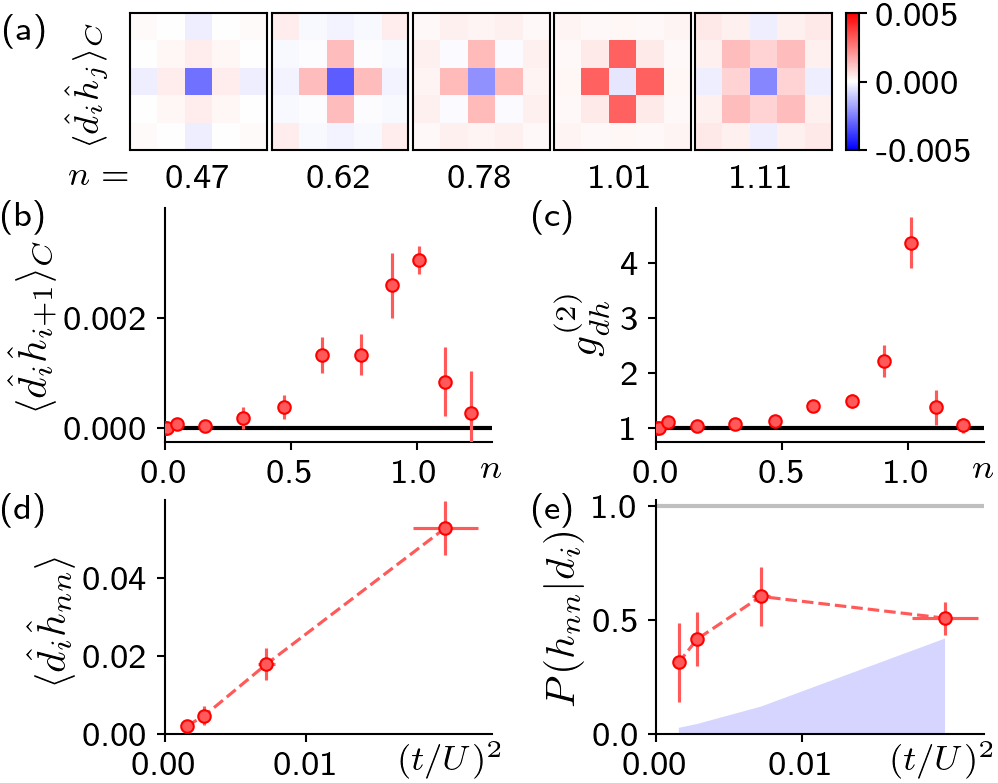

In [30]:
# Fig 5 v1

########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
fig5 = plt.figure(figsize = [fig_size[0],fig_size[1]/golden_mean*1.35])
figAspect=fig_size[0]/(fig_size[1]/golden_mean*1.35)

#########################################################
############ All the vs heating stuff ###################
#########################################################

sub1 = fig5.add_subplot(1,1,1, label = str(np.random.rand()))
sub1.axis('off')  

# 2D img arrays for display 
numcols = len(nArr_Fig5a_matsExpIndToDisplay)
numrows = 1
axArray = [[None for junkind in range(numcols)] for x in range(numrows)]
imgArrayTop = 0.78
imgArrayRight=0.825
imgArrayLeft=0.0
imgArrayHorizSpace = (imgArrayRight-imgArrayLeft)/numcols
imgArrayBot = imgArrayTop- numrows*imgArrayHorizSpace
imgArrayVertSpace = imgArrayHorizSpace
imgGrout = 0.0025
vminPlotdhij2D = -0.005
vmaxPlotdhij2D = -vminPlotdhij2D
# Moving up bottom a bit 
# dh vs density params
dhVsDenminden = 0.0
dhVsDenmaxden = 1.3

ax_dhg2 = fig5.add_subplot(4,2,6, label = str(np.random.rand()))
ax_dhij_c_1D = fig5.add_subplot(4,2,5, label = str(np.random.rand()))
ax_dhij_c_1D_label = fig5.add_subplot(4,2,5, label = str(np.random.rand()))
# ax_dhg2_label.axis('off') 
ax_dhij_c_1D_label.axis('off') 
movUpdhij = 0.48
plotsrelwidth = 0.9
plotsrelheight = 1.05
plotsMoveRight = 0.1
anchorGraphInSubplot(ax_dhij_c_1D, ax_dhij_c_1D, relx=0.0+plotsMoveRight, rely=movUpdhij, 
                     relwidth=plotsrelwidth, relheight=plotsrelheight)
anchorGraphInSubplot(ax_dhg2, ax_dhg2, relx=0.0+plotsMoveRight, rely=movUpdhij, 
                     relwidth=plotsrelwidth, relheight=plotsrelheight)
anchorGraphInSubplot(ax_dhij_c_1D_label, ax_dhij_c_1D_label, relx=0.0, rely=movUpdhij, 
                     relwidth=plotsrelwidth, relheight=plotsrelheight)

# Make array for images shown 
for rowind in range(numrows):
    for colind in range(numcols): 
        axArray[rowind][colind] = fig5.add_axes([0,0,0,0], label = str(np.random.rand()))
        setupImgDisplay(axArray[rowind][colind], xedgecolors[1]) # make it look pretty 
        anchorGraphInSubplot(sub1, axArray[rowind][colind], 
                             imgArrayLeft+imgArrayHorizSpace*colind +imgGrout, 
                             imgArrayBot+ imgArrayVertSpace*(numrows-1-rowind)+imgGrout, 
                             imgArrayHorizSpace-2*imgGrout, imgArrayVertSpace-2*imgGrout)
        axArray[rowind][colind].annotate(np.around(nArr_Fig5a_matsToDisplay[colind],2), 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(0.5,-0.1), 
                    textcoords='axes fraction', verticalalignment='top', horizontalalignment='center', 
                    fontsize=subplotlabelfontsize);
#annotate bottom left and left of whole thing
denWords = '$n =$'
titleWords = '$\\langle \\hat{d}_i \\hat{h}_{j} \\rangle_C$'
axArray[0][0].annotate(denWords, 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(0,-0.075), 
                    textcoords='axes fraction', verticalalignment='top', horizontalalignment='right', 
                    fontsize=subplotlabelfontsize);
axArray[0][0].annotate(titleWords, 
                  xy=(0,0), 
                  xycoords='axes fraction',
                  xytext=(-0.15,0.5), 
                    textcoords='axes fraction', rotation=90, verticalalignment='center', 
                       horizontalalignment='right', 
                    fontsize=subplotlabelfontsize);


# 2D image plots
for rowind in range(numrows):
    for colind in range(numcols): 
        if rowind == 0 : # experiment
            axArray[rowind][colind].imshow(dhij_c_matsToDisplay_Fig5a[colind], cmap='bwr', 
                                           vmin=vminPlotdhij2D, vmax=vmaxPlotdhij2D)
# Add colorbar
# Colorbar 
ax_cb = fig5.add_axes((1,1,1,1), label = str(np.random.rand()));
ax_cb.spines['right'].set_visible(True)
ax_cb.spines['top'].set_visible(True)
plt.setp(ax_cb.get_xticklabels(), visible=False)
ax_cb.tick_params(axis='x', which='both', length=0)
c_range=vmaxPlotdhij2D
ax_cb.imshow(np.asarray([np.linspace(c_range, -1*c_range, 1000)]).transpose(),
             extent=[-c_range, c_range, -c_range, c_range],
             vmin=-1.0*c_range, vmax=1.0*c_range, cmap='bwr')
ax_cb.yaxis.tick_right()
    # move it over a little to left
anchorGraphInSubplot(axArray[numrows-1][numcols-1], ax_cb, relx=1.1, rely=0, 
                     relwidth=0.1, relheight=1)



# dhij plots 
# experiment
ax_dhij_c_1D.errorbar(nArr_Fig5a_mats,dh01_c_Fig5a,
                           xerr = None, yerr = dh01_c_err_Fig5a,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth)
# ax_dhij_c_1D.plot([0,2],[0,0], color = '0.75', linestyle = 'dotted')
ax_dhij_c_1D.plot([0,2],[0,0], color = 'black', marker = '',linestyle = 'solid', zorder = -50)
ax_dhij_c_1D.set_yticks([0,0.002])
ax_dhij_c_1D.set_xlim([dhVsDenminden,dhVsDenmaxden])
ax_dhij_c_1D.set_ylim([-0.00025,0.004])
# ax_dhij_c_1D.set_xlabel("$\\langle \\hat{n} \\rangle$", 	labelpad = label_globalpad)
ax_dhij_c_1D.set_ylabel("$\\langle \\hat{d}_i\\hat{h}_{i+1} \\rangle_C$", 	labelpad = label_globalpad)
ax_dhij_c_1D.annotate('$n$', xy=(1.0,-0.05), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# dhij plots 
# experiment
# Coldest 
ax_dhg2.errorbar(nArr_Fig5a_mats,dhg201_Fig5a,
                           xerr = None, yerr = dhg201_err_Fig5a,
                       marker='o', linestyle = '', 
                       color = xcolors[2], mec = tuple(xedgecolors[2]),
              label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
              markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth)
ax_dhg2.plot([0,2],[1,1], color = 'black', marker = '',linestyle = 'solid', zorder = -50)
ax_dhg2.set_yticks([0,1,2,3,4])
ax_dhg2.set_xlim([dhVsDenminden,dhVsDenmaxden])
ax_dhg2.set_ylim([0.75,5.0])
# ax_dhg2.legend(frameon=False,fancybox=False, borderpad=0.1, handletextpad= 0,fontsize = 'xx-small', loc = 'upper left')
# ax_dhg2.set_xlabel("$\\langle \hat{n}\\rangle$", 	labelpad = label_globalpad)
ax_dhg2.set_ylabel("$g^{(2)}_{dh}$", 	labelpad = label_globalpad)
ax_dhg2.annotate('$n$', xy=(1.0,-0.05), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'black')


# #########################################################
# ############ All the t/U stuff ###################
# #########################################################

ax_dhVsUovert = fig5.add_subplot(4,2,7)
ax_dhVsUovert_label = fig5.add_subplot(4,2,7, label = str(np.random.rand()))
ax_dhVsUovert_label.axis('off')  
ax_dhCondVsUovert = fig5.add_subplot(4,2,8)
# ax_dhCondVsUovert.spines['right'].set_visible(True)
# ax_dhCondVsUovert.spines['top'].set_visible(True)
# ax_dhCondVsUovert.yaxis.set_label_position("right")
# ax_dhCondVsUovert.yaxis.tick_right()
botrowshiftdown = 1.25
anchorGraphInSubplot(ax_dhij_c_1D,ax_dhVsUovert, relx=0.00, rely=0-botrowshiftdown, 
                     relwidth=1, relheight= 1)
anchorGraphInSubplot(ax_dhg2,ax_dhCondVsUovert, relx=0.00, rely=0-botrowshiftdown, 
                     relwidth=1, relheight= 1)
anchorGraphInSubplot(ax_dhij_c_1D_label,ax_dhVsUovert_label, relx=0.00, rely=0-botrowshiftdown, 
                     relwidth=1, relheight= 1)

extraInside = 0.01
imgSize = 0.25
imgRowHeight = 0.75
rawImgBrightnessScale1 = 0.95 # weak int
rawImgBrightnessScale2 = 0.925 # strong int
# # actual images strong int
# ax_im2 = fig5.add_axes( (0,imgRowHeight,imgSize,imgSize*figAspect),frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_im2.axis('off')
# setupImgDisplay(ax_im2, xcolors[5]) 
# ax_im2b = fig5.add_axes( (imgSize,imgRowHeight,imgSize,imgSize*figAspect),frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_im2b.axis('off')
# setupImgDisplay(ax_im2b, xcolors[5]) 
# # actual image weak int
# ax_im1 = fig5.add_axes( (2*imgSize,imgRowHeight,imgSize,imgSize*figAspect),frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_im1.axis('off')
# setupImgDisplay(ax_im1, xcolors[5]) 
# ax_im1b = fig5.add_axes( (3*imgSize,imgRowHeight,imgSize,imgSize*figAspect),frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_im1b.axis('off')
# setupImgDisplay(ax_im1b, xcolors[5]) 
# ax_im2.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# # ax_im2b.annotate('(b)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
# #                xytext=(0,0), 
# #                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
# #                fontsize=subplotlabelfontsize,
# #                  color = 'white')
# ax_im1.annotate('(b)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# ax_im1b.annotate('(d)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')

# # Strongly interacting 10.5 Er setpoint 
# ax_im2.imshow(arrdhrawimgs[5]*rawImgBrightnessScale2, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
# ax_im2b.imshow(arrdhbinnedimgs[5], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')
# # More weakly interacting 
# ax_im1.imshow(arrdhrawimgs[1]*rawImgBrightnessScale1, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
# ax_im1b.imshow(arrdhbinnedimgs[1], cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')
# arrdhrawimgs[jj]
# arrdhbinnedimgs[jj]
# # best seems to be 1 and 5  

# ax_dhVsUovert.errorbar(tovUSqArr[0], vsRun_ndArr_Uovert_Fig5, 
#                        xerr = tovUSqArr[1], yerr=vsRun_ndArr_err_Uovert_Fig5, 
#                   color = xcolors[0], mec = tuple(xedgecolors[0]), 
#                      marker = 'o', linestyle = 'dashed',
#                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)
# ax_dhVsUovert.errorbar(tovUSqArr[0], 4*vsRun_dh11_Uovert_Fig5, 
#                        xerr = tovUSqArr[1], yerr=4*vsRun_dh11_err_Uovert_Fig5, 
#                   color = xcolors[1], mec = tuple(xedgecolors[1]), 
#                      marker = '^', linestyle = 'dashed',
#                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)
ax_dhVsUovert.errorbar(tovUSqArr[0], 4*vsRun_dh01_Uovert_Fig5, 
                       xerr = tovUSqArr[1], yerr=4*vsRun_dh01_err_Uovert_Fig5, 
                  color = xcolors[2], mec = tuple(xedgecolors[2]), 
                     marker = 'o', linestyle = 'dashed',
                     markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
                     zorder = 43, **errorbar_global_style)
ax_dhVsUovert.set_ylabel('$\\langle \\hat{d}_i\\hat{h}_{nn} \\rangle$',
                         labelpad = label_globalpad)
# ax_dhVsUovert.set_xlabel('$(t/U)^2$', 	labelpad = label_globalpad)
ax_dhVsUovert.set_xticks([0,0.01])
ax_dhVsUovert.set_yticks([0,0.02,0.04])
ax_dhVsUovert.set_ylim(0, 0.06)
ax_dhVsUovert.set_xlim(xmin=0)
ax_dhVsUovert.annotate('$(t/U)^2$', xy=(0.88,-0.035), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

ax_dhCondVsUovert.fill_between(tovUSqArr[0], [0,0,0,0],4*vsRun_ndArr_Uovert_Fig5,
                         facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
# ax_dhCondVsUovert.errorbar(tovUSqArr[0], 4*vsRun_dhPcond11_Uovert_Fig5, 
#                         xerr = tovUSqArr[1], yerr=4*vsRun_dhPcond11_err_Uovert_Fig5, 
#                   color = xcolors[1], mec = tuple(xedgecolors[1]), 
#                      marker = '^', linestyle = 'dashed',
#                      markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
#                      zorder = 43, **errorbar_global_style)
ax_dhCondVsUovert.errorbar(tovUSqArr[0], 4*vsRun_dhPcond01_Uovert_Fig5, 
                        xerr = tovUSqArr[1], yerr=4*vsRun_dhPcond01_err_Uovert_Fig5, 
                  color = xcolors[2], mec = tuple(xedgecolors[2]), 
                     marker = 'o', linestyle = 'dashed',
                     markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth,
                     zorder = 43, **errorbar_global_style)
ax_dhCondVsUovert.set_ylabel('$P(h_{nn}|d_i)$',
# ax_dhCondVsUovert.set_ylabel('$4\\langle \\hat{d}_i\\hat{h}_j \\rangle/\\langle \\hat{d}_i \\rangle$,$4\\langle \\hat{d}_i \\rangle$ ',
                          labelpad = label_globalpad)
ax_dhCondVsUovert.plot([0,0.0225],[1,1], color = '0.75', marker = '',linestyle = 'solid')
# ax_dhCondVsUovert.set_xlabel('$(t/U)^2$', 	labelpad = label_globalpad)
ax_dhCondVsUovert.set_xticks([0,0.01])
ax_dhCondVsUovert.set_yticks([0,0.5,1])
ax_dhCondVsUovert.set_ylim([0,1.025])
ax_dhCondVsUovert.set_xlim([0,0.0225])
ax_dhCondVsUovert.annotate('$(t/U)^2$', xy=(0.88,-0.035), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'black')

# Make a little diagram

# sub2 = fig5.add_subplot(1,1,1, label = str(np.random.rand()))
# sub2.axis('off')  
# sub2.set_aspect(1)

# patx0=0.06
# paty0=0.135
# patdspace = 0.035
# colorArrInds = [0,1,2]
# colorArr = [
#     ['white',xcolors[2],'white'],
#     [xcolors[2],'black',xcolors[2]],
#     ['white',xcolors[2],'white']
# ]
# # colorArr = [
# #     [xcolors[1],xcolors[2],xcolors[1]],
# #     [xcolors[2],'white',xcolors[2]],
# #     [xcolors[1],xcolors[2],xcolors[1]]
# # ]
# for _rr in colorArrInds :
#     for _cc in colorArrInds :
#         rect = matplotlib.patches.Rectangle((patx0+_rr*patdspace,paty0+_cc*patdspace),patdspace,patdspace,
#                                     linewidth=0.25,edgecolor='black',facecolor=colorArr[_rr][_cc])
#         sub2.add_patch(rect)
# # circ1 = matplotlib.patches.Circle((patx0+1.3*patdspace,paty0+1.3*patdspace),radius=patdspace/4,
# #                             linewidth=0.25,edgecolor=tuple(xedgecolors[0]),facecolor=xcolors[0])
# # circ2 = matplotlib.patches.Circle((patx0+1.7*patdspace,paty0+1.7*patdspace),radius=patdspace/4,
# #                             linewidth=0.25,edgecolor=tuple(xedgecolors[0]),facecolor=xcolors[0])
                           
# # sub2.add_patch(circ1)
# # sub2.add_patch(circ2)

labelSubplot(ax_dhVsUovert_label,'(d)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_dhCondVsUovert,'(e)') # Annotate plot as (a), (b), and so on.
anchorGraphInSubplot(sub1, sub1, relx=0, rely=0.5, 
                     relwidth=1, relheight=0.23)
labelSubplot(sub1,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_dhij_c_1D_label,'(b)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_dhg2,'(c)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig5.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest| resolution
plt.savefig('Fig5.png',transparent=True,  bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

## Figure S1

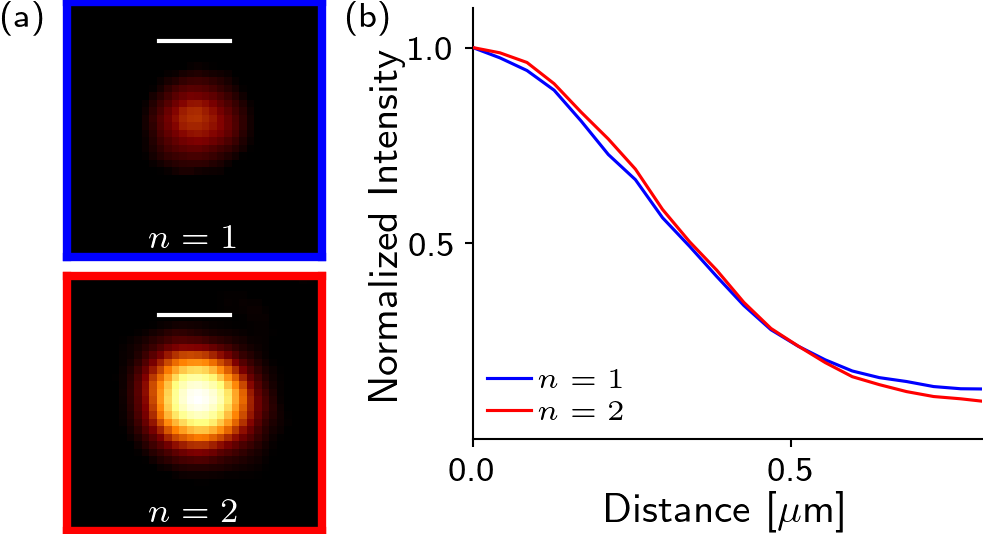

In [31]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
fig2 = plt.figure(figsize = [fig_size[0],fig_size[1]])
# Region for first few figures
subplot1 = fig2.add_subplot(1,2,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
subplot1.axis('off')
# 2D PSFs
subplot1a = fig2.add_axes([0,0,0,0], label = str(np.random.rand()))
subplot1b = fig2.add_axes([0,0,0,0], label = str(np.random.rand()))
setupImgDisplay(subplot1a, xedgecolors[0]) 
setupImgDisplay(subplot1b, xedgecolors[2]) 
for axis in ['top','bottom','left','right']:
    subplot1a.spines[axis].set_linewidth(2) #. a little wider to see
    subplot1b.spines[axis].set_linewidth(2)
centPSF = 0.5
sizePSF = 0.7
heightPSF1 = 0.0
heightPSF2 = 0.525
psfsloc = [
    [centPSF - 0.95*sizePSF,heightPSF2,sizePSF,sizePSF],
    [centPSF -0.95*sizePSF,heightPSF1,sizePSF,sizePSF],
    [0.5-0.025/2,0.7,0.025,0.28] ]
anchorGraphInSubplot(subplot1, subplot1a, 
                     relx=psfsloc[0][0], rely=psfsloc[0][1], relwidth=psfsloc[0][2], relheight=psfsloc[0][3])
anchorGraphInSubplot(subplot1, subplot1b, 
                     relx=psfsloc[1][0], rely=psfsloc[1][1], relwidth=psfsloc[1][2], relheight=psfsloc[1][3])
# Radial PSFs
subplot1c = fig2.add_subplot(1,2,2, label = str(np.random.rand()))
anchorGraphInSubplot(subplot1c, subplot1c, relx=-0.4, rely=0.175, relwidth=1.4, relheight=0.825)
# Histogram

# Annotate plots 
# Region for figure label 
subplot0 = fig2.add_subplot(1,2,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
subplot0.axis('off')
labelSubplot(subplot0,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(subplot1c,'(b)') # Annotate plot as (a), (b), and so on.

# 2D PSFs plots
cmapforpsfs = rawimgColorMap
# we have brightness of singlons and doublons in rawimgColorMap scales. What scales do we need here?
rawPSFMaxDoublonPix = np.amax(tot_psf_doublons_crop)
rawPSFMinPix = min(np.amin(tot_psf_doublons_crop),np.amin(tot_psf_singlons_crop))
vminforpsfs =rawPSFMinPix +backgroundBrightnessPlotRatio*doubBrightnessPlotRatio*(rawPSFMaxDoublonPix - rawPSFMinPix)
vmaxforpsfs = doubBrightnessPlotRatio*(rawPSFMaxDoublonPix - rawPSFMinPix) + rawPSFMinPix
extentforpsfs = [-1.8,1.8,-1.8,1.8]
psfim1 = subplot1a.imshow(tot_psf_singlons_crop,cmap=cmapforpsfs, 
                          vmin=vminforpsfs, vmax=vmaxforpsfs,
                          extent=extentforpsfs,origin='lower', interpolation ='none')
subplot1a.axhline(y=1.25, color='white',
                  xmin=0.5+ -0.5*(1/3.6), xmax=0.5+ 0.5*(1/3.6), linestyle='-', marker = '')
psfim2 = subplot1b.imshow(tot_psf_doublons_crop,cmap=cmapforpsfs, 
                          vmin=vminforpsfs, vmax=vmaxforpsfs,
                          extent=extentforpsfs,origin='lower', interpolation ='none')
subplot1b.axhline(y=1.25, color='white',
                  xmin=0.5+ -0.5*(1/3.6), xmax=0.5+ 0.5*(1/3.6), linestyle='-', marker = '')
extraInside = 0.01
subplot1a.annotate('$n=1$', xy=(0.5,extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='bottom', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
subplot1b.annotate('$n=2$', xy=(0.5,extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='bottom', horizontalalignment='center', 
               fontsize=subplotlabelfontsize,
                 color = 'white')

# Radial PSFs
subplot1c.plot(tot_psf_singlons_rad_x, tot_psf_singlons_rad_d, linestyle="-", 
               marker = "", color = xedgecolors[0],label = '$n=1$', **plot_global_style)
# subplot4.plot(tot_psf_doublons_rad_x, tot_psf_doublons_rad_d, linestyle="-", 
#               marker = "", color = xedgecolors[2],label = 'Doublons', **plot_global_style)
subplot1c.plot(tot_psf_doublons_rad_normed_x, tot_psf_doublons_rad_normed_d, 
               linestyle="-", marker = "", color = xedgecolors[2],label = '$n=2$', **plot_global_style)
subplot1c.set_xlabel("Distance [$\mu$m]", 			labelpad = label_globalpad)
subplot1c.set_ylabel("Normalized Intensity", 	labelpad = label_globalpad)
subplot1c.set_yticks([0.5,1])
subplot1c.set_xticks([0,0.5,1.0])
subplot1c.set_xlim([0,0.8])
subplot1c.set_ylim([0,1.1])
#subplot1c.yaxis.set_major_locator(plt.MaxNLocator(nbins=3, prune = 'lower'))
subplot1c.margins(x=0.05,y=0.05,tight=True)
# Legend if desired
    # Should really only have to change subplot1 to something else, or change labels
handles1c, labels1c = subplot1c.get_legend_handles_labels()
subplot1c.legend(handles1c, labels1c, loc=3)

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in fig2.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('FigS1.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want.

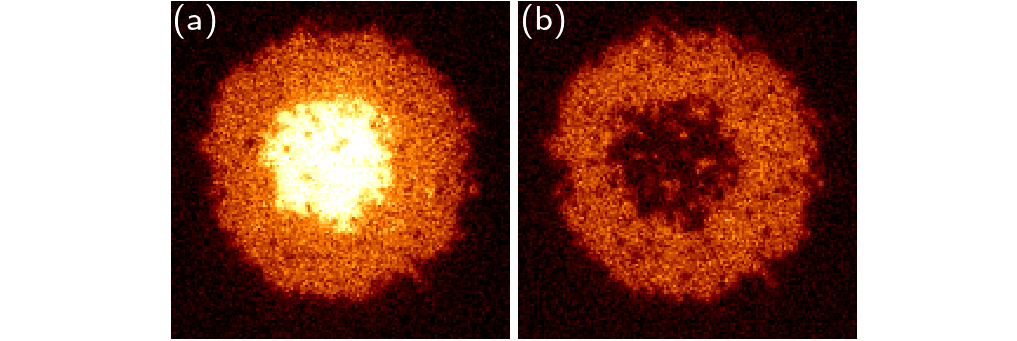

In [32]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
figS2 = plt.figure(figsize = [fig_size[0],fig_size[0]/2.5]) # Make height same as width 
# basic drawing region
subplot0 = figS2.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

# actual images
imgSize = 1
imgGrout = 0.02
imgIn = 0.004
ax_fill = figS2.add_subplot(1,2,1, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fill.axis('off')
setupImgDisplay(ax_fill, xcolors[5]) 
anchorGraphInSubplot(ax_fill, ax_fill, relx=0.43, rely=0.0, relwidth=1, 
                     relheight=1)
# anchorGraphInSubplot(subplot0, ax_fill, relx=(1-1/2.5)/2, rely=0.0, relwidth=1/2.5, 
#                      relheight=1)


# # Move the annotation up relative to plots so they dont hit
# extraInside = 0.04
# ax_fill.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')

ax_fill.imshow(rawimgBest, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')

ax_empty = figS2.add_subplot(1,2,2, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_empty.axis('off')
setupImgDisplay(ax_empty, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_empty, relx=0.6666+(0.3333-imgSize), rely=0.0, 
#                      relwidth=imgSize, relheight=imgSize/figAspectRatio)

# Move the annotation up relative to plots so they dont hit
extraInside = 0.01
ax_fill.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
ax_empty.annotate('(b)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
               xytext=(0,0), 
               textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
               fontsize=subplotlabelfontsize,
                 color = 'white')
ax_empty.imshow(rawimgRecom, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')

# rawimgRecom

anchorGraphInSubplot(ax_fill, subplot0, relx=-0.5, rely=0.0, relwidth=3.0, 
                     relheight=imgSize)
    # Make the thing broader 

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in figS2.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('FigS1p5.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

## Figure S2

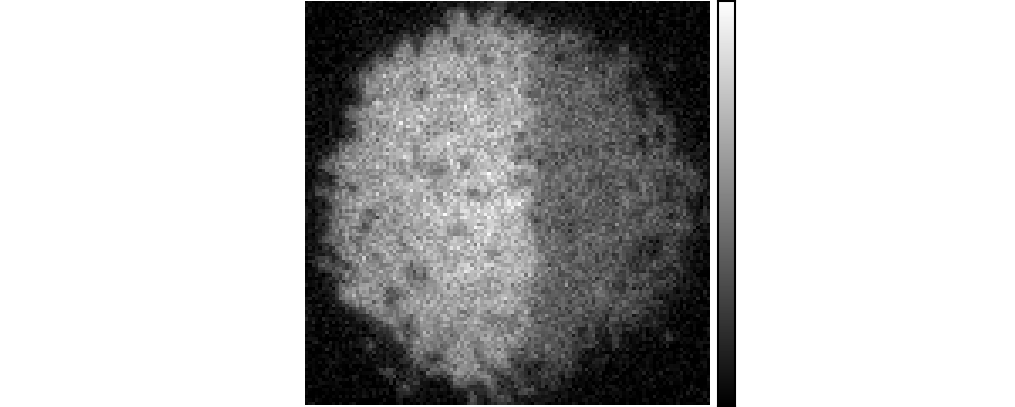

In [33]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
figS2 = plt.figure(figsize = [fig_size[0],fig_size[0]/2.5]) # Make height same as width 
# basic drawing region
subplot0 = figS2.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

# actual images
imgSize = 1
imgGrout = 0.02
imgIn = 0.004
ax_fill = figS2.add_subplot(1,3,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fill.axis('off')
setupImgDisplay(ax_fill, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fill, relx=(1-1/2.5)/2, rely=0.0, relwidth=1/2.5, 
                     relheight=1)


# # Move the annotation up relative to plots so they dont hit
# extraInside = 0.04
# ax_fill.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')

ax_fill.imshow(rawimg_FigS2, cmap='gray', vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')

# Add colorbar
# Colorbar 
# ax_cb = figS2.add_axes((1,1,1,1), label = str(np.random.rand()));
# ax_cb.spines['right'].set_visible(True)
# ax_cb.spines['top'].set_visible(True)
# plt.setp(ax_cb.get_xticklabels(), visible=False)
# ax_cb.tick_params(axis='x', which='both', length=0)
# c_range=1
# ax_cb.imshow(np.asarray([np.linspace(1,0, 1000)]).transpose(),
#              extent=[-c_range, c_range, 0, c_range],
#              vmin=0, vmax=1.0*c_range, cmap='gray')
# ax_cb.yaxis.tick_right()
ax_cb = figS2.add_axes((1,1,1,1), label = str(np.random.rand()));
ax_cb.spines['right'].set_visible(True)
ax_cb.spines['top'].set_visible(True)
plt.setp(ax_cb.get_xticklabels(), visible=False)
plt.setp(ax_cb.get_yticklabels(), visible=False)
ax_cb.tick_params(axis='x', which='both', length=0)
ax_cb.tick_params(axis='y', which='both', length=0)
c_range=1
ax_cb.imshow(np.asarray([np.linspace(1,0, 1000)]).transpose(),
             extent=[-c_range, c_range, 0, c_range],
             vmin=0, vmax=1.0*c_range, cmap='gray')
    # move it over a little to left
anchorGraphInSubplot(ax_fill, ax_cb, relx=1.02, rely=0, 
                     relwidth=0.04, relheight=1)

anchorGraphInSubplot(subplot0, subplot0, relx=0, rely=0.0, relwidth=imgSize, 
                     relheight=imgSize)

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in figS2.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('FigS2.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

## Figure S3

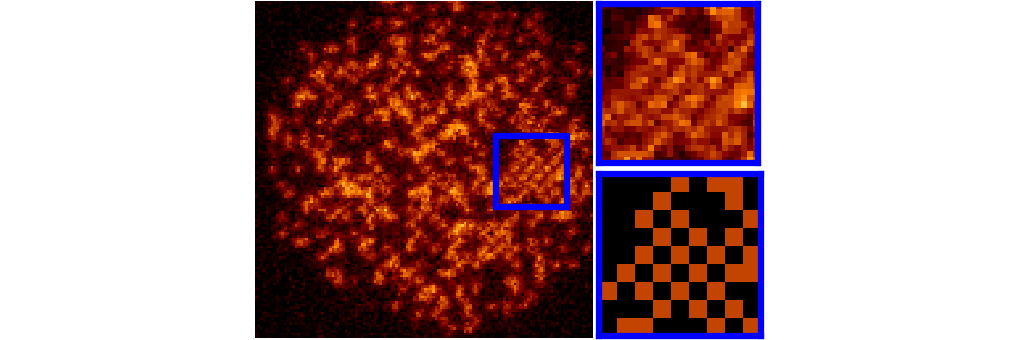

In [28]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
figS3 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) # Make height same as width 
# basic drawing region
subplot0 = figS3.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

# actual images
imgSize = 1
imgGrout = 0.04
imgIn = 0.008
ax_fill = figS3.add_subplot(1,3,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
ax_fill.axis('off')
setupImgDisplay(ax_fill, xcolors[5]) 
anchorGraphInSubplot(subplot0, ax_fill, relx=0, rely=0.0, relwidth=imgSize, 
                     relheight=imgSize)
ax_fillzoom = figS3.add_subplot(1,3,3, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillzoom.axis('off')
setupImgDisplay(ax_fillzoom, xedgecolors[0]) 
anchorGraphInSubplot(subplot0, ax_fillzoom, relx=imgSize/3+imgGrout/3/2, rely=0.5+imgGrout/2, relwidth=imgSize/2-imgGrout/2, 
                     relheight=imgSize/2-imgGrout/2-imgIn)
ax_fillbinned = figS3.add_subplot(1,3,3, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fillbinned.axis('off')
setupImgDisplay(ax_fillbinned, xedgecolors[0]) 
anchorGraphInSubplot(subplot0, ax_fillbinned, relx=imgSize/3+imgGrout/3/2, rely=imgIn, relwidth=imgSize/2-imgGrout/2, 
                     relheight=imgSize/2-imgGrout/2)

anchorGraphInSubplot(subplot0, subplot0, relx=-0.25, rely=0.0, relwidth=1, 
                     relheight=1)

# Make zoomed in part of image
# cutsize= 2/5
# cutx= 3.0/5
# cuty= 1.9/5
cutsize= 1.0/5
cutx= 3.5/5
cuty= 2.0/5
rawimgXoffset = 2
rawimg_cuty = np.round(len(rawimg_FigS3)*cuty).astype(int)
rawimg_cutx = np.round(len(rawimg_FigS3)*cutx).astype(int)+rawimgXoffset
rawimg_delta = np.round(len(rawimg_FigS3)*cutsize).astype(int)
rawimg_FigS3_cut = rawimg_FigS3[rawimg_cuty:rawimg_cuty+rawimg_delta,rawimg_cutx:rawimg_cutx+rawimg_delta]
binnedimg_cuty = np.round(len(binnedimg_FigS3)*cuty).astype(int)
binnedimg_cutx = np.round(len(binnedimg_FigS3)*cutx).astype(int)
binnedimg_delta = np.round(len(binnedimg_FigS3)*cutsize).astype(int)
binnedimg_FigS3_cut = binnedimg_FigS3[binnedimg_cuty:binnedimg_cuty+binnedimg_delta,binnedimg_cutx:binnedimg_cutx+binnedimg_delta]

ax_fill.imshow(rawimg_FigS3, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
ax_fillzoom.imshow(rawimg_FigS3_cut, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
                 extent=rawimgExtent,interpolation ='none')
ax_fillbinned.imshow(binnedimg_FigS3_cut, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
                     extent=rawimgExtent,interpolation ='none')

for axis in ['top','bottom','left','right']:
    ax_fillzoom.spines[axis].set_linewidth(1.5) #. a little wider to see
    ax_fillzoom.spines[axis].set_linewidth(1.5)
for axis in ['top','bottom','left','right']:
    ax_fillbinned.spines[axis].set_linewidth(1.5) #. a little wider to see
    ax_fillbinned.spines[axis].set_linewidth(1.5)

# rect = matplotlib.patches.Rectangle((cutx, cuty),cutsize, cutsize,
#                                     linewidth=0.25,edgecolor='blue',facecolor=None)
ax_fill.add_patch(matplotlib.patches.Rectangle((0.43,-0.22),cutsize*2.1, cutsize*2.1,
                                    linewidth=1.5,edgecolor=xedgecolors[0],facecolor='none'))

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in figS3.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('FigS3.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [ ]:
# ########## Now plotting figure
#     # Can adjust figure size in style area above if you want. 
# figAspectRatio = 0.8 ;
# figS3 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) # Make height same as width 
# # basic drawing region
# subplot0 = figS3.add_axes((0,0,1,1), label = str(np.random.rand()))
# subplot0.axis('off')  # random things so I can move it in 

# # actual images
# imgSize = 1
# imgGrout = 0.04
# imgIn = 0.008
# ax_fill = figS3.add_subplot(1,3,3, frameon=False, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# ax_fill.axis('off')
# setupImgDisplay(ax_fill, xcolors[5]) 
# anchorGraphInSubplot(subplot0, ax_fill, relx=0, rely=0.0, relwidth=imgSize, 
#                      relheight=imgSize)
# ax_fillzoom = figS3.add_subplot(1,3,3, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillzoom.axis('off')
# setupImgDisplay(ax_fillzoom, xedgecolors[0]) 
# anchorGraphInSubplot(subplot0, ax_fillzoom, relx=imgSize/3+imgGrout/3/2, rely=0.5+imgGrout/2, relwidth=imgSize/2-imgGrout/2, 
#                      relheight=imgSize/2-imgGrout/2-imgIn)
# ax_fillbinned = figS3.add_subplot(1,3,3, label = str(np.random.rand())) # Create plot with nothing visible at all. 
# # ax_fillbinned.axis('off')
# setupImgDisplay(ax_fillbinned, xedgecolors[0]) 
# anchorGraphInSubplot(subplot0, ax_fillbinned, relx=imgSize/3+imgGrout/3/2, rely=imgIn, relwidth=imgSize/2-imgGrout/2, 
#                      relheight=imgSize/2-imgGrout/2)

# ax_ssij_c_1D = figS3.add_subplot(1,2,2, label = str(np.random.rand()))
# ax_ssij_c_1D.spines['right'].set_visible(True)
# ax_ssij_c_1D.spines['top'].set_visible(True)
# plotsMoveRight = 0.08
# anchorGraphInSubplot(ax_ssij_c_1D, ax_ssij_c_1D, relx=0.0+plotsMoveRight, rely=0, 
#                      relwidth=1-plotsMoveRight, relheight=1)


# theorychopind = -5
# # experiment
# # ax_ssij_c_1D.errorbar(SzVsMzSq_DQMC_FigS3[0][:theorychopind],SzVsMzSq_DQMC_FigS3[1][:theorychopind],
# #                            xerr = None, yerr = None,
# #                            marker='', linestyle = 'solid', 
# #                            color = xcolors[1], mec = tuple(xedgecolors[1]),
# #                   label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
# #                   markersize = pgsmarkersize, markeredgewidth = pgsmarkeredgewidth)

# # ax_ssij_c_1D.plot(niceplotnArr_FigS3, 4*niceplotszszBestArr_FigS3, marker = '', linestyle = '-')
# # ax_ssij_c_1D.plot(niceplotnArr_FigS3, 4*niceplotszszArr_FigS3[0], marker = '', linestyle = '-')
# # ax_ssij_c_1D.plot(niceplotnArr_FigS3, 4*niceplotszszArr_FigS3[1], marker = '', linestyle = '-')

# # ax_ssij_c_1D.plot(finalDQMCs_0p5_FigS3, finalDQMCszsz_0p5_FigS3, marker = '', linestyle = '-', 
# #                   color = xedgecolors[1],linewidth= pgslinewidth)
# # ax_ssij_c_1D.plot(finalDQMCs_0p4_FigS3, finalDQMCszsz_0p4_FigS3, marker = '', linestyle = '-', 
# #                   color = xedgecolors[1],linewidth= pgslinewidth)

# ax_ssij_c_1D.fill_between(finalDQMCs_0p4_FigS3, finalDQMCszsz_0p4_FigS3, finalDQMCszsz_0p5_FigS3, 
#                          facecolor = "0.75", edgecolor = None, alpha = 0.5)
# ax_ssij_c_1D.plot(finalDQMCs_0p45_FigS3, finalDQMCszsz_0p45_FigS3, marker = '', linestyle = '-', 
#                   color = xedgecolors[1],linewidth= pgslinewidth)

# ax_ssij_c_1D.errorbar(SzVsMzSq_FigS3[0],SzVsMzSq_FigS3[1],
#                            xerr = SzVsMzSq_FigS3[2], yerr = SzVsMzSq_FigS3[3],
#                            marker='o', linestyle = '', 
#                            color = xcolors[2], mec = tuple(xedgecolors[2]),
#                   label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
# # ax_ssij_c_1D.plot([0,2],[0,0], color = '0.75', linestyle = 'dotted')
# # ax_ssij_c_1D.plot([0,2],[0,0], color = 'black', marker = '',linestyle = 'solid', zorder = -50)
# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
# ax_ssij_c_1D.set_xlim([0,1])
# ax_ssij_c_1D.set_ylim([-0.14,0])
# # ax_ssij_c_1D.set_xlabel("$\\langle \\hat{n} \\rangle$", 	labelpad = label_globalpad)
# ax_ssij_c_1D.set_ylabel("$C_{\\rm spin}(1)$", 	labelpad = label_globalpad)
# ax_ssij_c_1D.annotate('$s$', xy=(1.0,-0.05), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='center', 
#                fontsize=subplotlabelfontsize,
#                  color = 'black')


# # Move the annotation up relative to plots so they dont hit
# extraInside = 0.01
# ax_fill.annotate('(a)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
#                xytext=(0,0), 
#                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
#                fontsize=subplotlabelfontsize,
#                  color = 'white')
# # ax_fillzoom.annotate('(b)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
# #                xytext=(0,0), 
# #                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
# #                fontsize=subplotlabelfontsize,
# #                  color = 'white')
# # ax_fillbinned.annotate('(c)', xy=(0+extraInside,1-extraInside), xycoords='axes fraction',
# #                xytext=(0,0), 
# #                textcoords='offset points', verticalalignment='top', horizontalalignment='left', 
# #                fontsize=subplotlabelfontsize,
# #                  color = 'white')

# # Make zoomed in part of image
# # cutsize= 2/5
# # cutx= 3.0/5
# # cuty= 1.9/5
# cutsize= 1.0/5
# cutx= 3.5/5
# cuty= 2.0/5
# rawimgXoffset = 2
# rawimg_cuty = np.round(len(rawimg_FigS3)*cuty).astype(int)
# rawimg_cutx = np.round(len(rawimg_FigS3)*cutx).astype(int)+rawimgXoffset
# rawimg_delta = np.round(len(rawimg_FigS3)*cutsize).astype(int)
# rawimg_FigS3_cut = rawimg_FigS3[rawimg_cuty:rawimg_cuty+rawimg_delta,rawimg_cutx:rawimg_cutx+rawimg_delta]
# binnedimg_cuty = np.round(len(binnedimg_FigS3)*cuty).astype(int)
# binnedimg_cutx = np.round(len(binnedimg_FigS3)*cutx).astype(int)
# binnedimg_delta = np.round(len(binnedimg_FigS3)*cutsize).astype(int)
# binnedimg_FigS3_cut = binnedimg_FigS3[binnedimg_cuty:binnedimg_cuty+binnedimg_delta,binnedimg_cutx:binnedimg_cutx+binnedimg_delta]

# ax_fill.imshow(rawimg_FigS3, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
# ax_fillzoom.imshow(rawimg_FigS3_cut, cmap=rawimgColorMap, vmin=minrawimgscale, vmax=maxrawimgscale, 
#                  extent=rawimgExtent,interpolation ='none')
# ax_fillbinned.imshow(binnedimg_FigS3_cut, cmap=rawimgColorMap, vmin=vminBinned, vmax=vmaxBinned,  
#                      extent=rawimgExtent,interpolation ='none')

# for axis in ['top','bottom','left','right']:
#     ax_fillzoom.spines[axis].set_linewidth(1.5) #. a little wider to see
#     ax_fillzoom.spines[axis].set_linewidth(1.5)
# for axis in ['top','bottom','left','right']:
#     ax_fillbinned.spines[axis].set_linewidth(1.5) #. a little wider to see
#     ax_fillbinned.spines[axis].set_linewidth(1.5)

# # rect = matplotlib.patches.Rectangle((cutx, cuty),cutsize, cutsize,
# #                                     linewidth=0.25,edgecolor='blue',facecolor=None)
# ax_fill.add_patch(matplotlib.patches.Rectangle((0.43,-0.22),cutsize*2.1, cutsize*2.1,
#                                     linewidth=1.5,edgecolor=xedgecolors[0],facecolor='none'))

# labelSubplot(ax_ssij_c_1D,'(b)') # Annotate plot as (a), (b), and so on.

# # Draw all plots and convert axis labels to Sans-serif 
#     # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
# for ax_inst in figS3.axes :
#     convAxLabelSansSerif(ax_inst, 'both')

# ########## Save figure and show
#     # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
#     # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS3.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# # shouldnt have to worry about DPI since images were loaded without interpolation
# plt.show() # Can comment this out if you want. 

## Fig S4 Thermometry

0.6852826634576606 0.015969542858327145
0.8534236864982964 0.039939303804073116
1.2387259696004675 0.08299851892434996


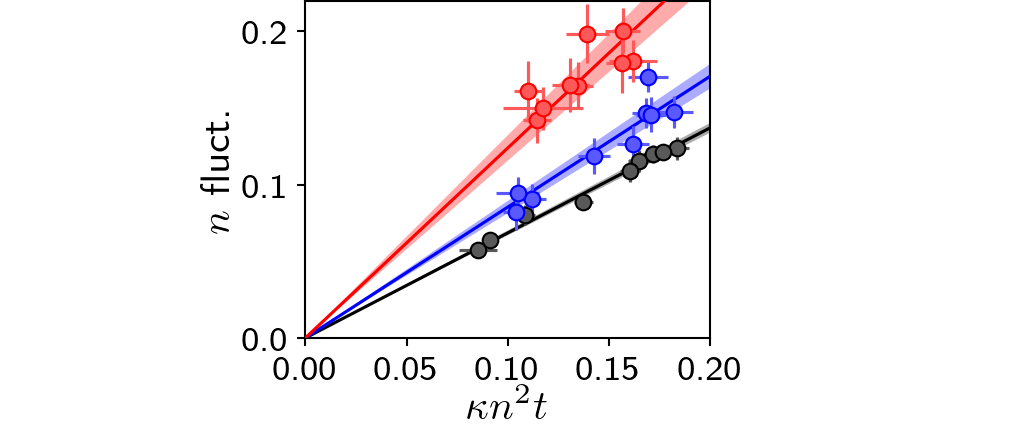

In [136]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_CvsKappa = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_CvsKappa.spines['right'].set_visible(True)
ax_CvsKappa.spines['top'].set_visible(True)

anchorGraphInSubplot(ax_CvsKappa,ax_CvsKappa, relx=0+0.025, rely=0, 
                     relwidth=1, relheight=1)

# Color choices and other formatting 
cteq0 = 0
cteq1 = 1
cteq2 = 2 
cArr = [cteq0,cteq1,cteq2]
markerSum = 'o'
marker5x5= 's'
marker1x1 = '^'
markerNonLoc = 'D'
linestyleSum = ''
linestyle5x5= ''
linestyle1x1 = ''
colorIndSum = 1
colorInd5x5= 0
colorInd1x1 = 2
alphaSum = 1; # How transparent? 
alphaLoc= 1
alphaNonLoc = 1
locMarkerScaling = 0.5; 

globaldensityCutoffForPlotting=0.2

colorIndForFluctArr = [1,0,2]

# Sum of correlator vs kappa
for thisRunInd in [0,1,2]:
    densityFromEOS = EOSArr_Fig4[thisRunInd][1]
    densityCutoffForPlotting = globaldensityCutoffForPlotting # only greater than this
    dIndsPlot = np.where(densityFromEOS>densityCutoffForPlotting)
    dIndsPlotSmallDen = np.where(densityFromEOS<=densityCutoffForPlotting)
    # Connected correlator sum
    ax_CvsKappa.errorbar(EOSArr_Fig4[thisRunInd][3][dIndsPlot], nnij_c_sumsArr_Fig4[thisRunInd][0][dIndsPlot], 
                         xerr = EOSArr_Fig4[thisRunInd][8][dIndsPlot], yerr=nnij_c_sumsArr_Fig4[thisRunInd][3][dIndsPlot],
                         color = xcolors[colorIndForFluctArr[thisRunInd]], 
                         mec = tuple(xedgecolors[colorIndForFluctArr[thisRunInd]]), 
                         marker = markerSum, alpha = alphaSum, linestyle = linestyleSum,
                         markersize = pgsmarkersize*1.25, markeredgewidth = pgsmarkeredgewidth,
                         label = 'Total',# '$\\delta n^2_{\\rm{tot}}$',
                         zorder = 43, **errorbar_global_style)
    ax_CvsKappa.plot([0,5], [0, 5*Tovert_cutoffArr_Fig4[thisRunInd][0][0]], '-', 
                     color = xedgecolors[colorIndForFluctArr[thisRunInd]], 
                     zorder=40, linewidth= pgslinewidth)
    ax_CvsKappa.fill_between([0,5], [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0])],
                             [0, 5*(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0])], 
                              facecolor = xcolors[colorIndForFluctArr[thisRunInd]], edgecolor = None, alpha = 0.5)
    
    #print((Tovert_cutoffArr_Fig4[thisRunInd][0][0]-Tovert_cutoffArr_Fig4[thisRunInd][1][0]),
    #(Tovert_cutoffArr_Fig4[thisRunInd][0][0]+Tovert_cutoffArr_Fig4[thisRunInd][1][0]))
    print(Tovert_cutoffArr_Fig4[thisRunInd][0][0],Tovert_cutoffArr_Fig4[thisRunInd][1][0])
ax_CvsKappa.set_yticks([0,0.1,0.2,0.3])
ax_CvsKappa.set_xticks([0,0.05,0.1,0.15,0.2])
ax_CvsKappa.set_xlim(0.0,0.2) # (0.0,0.195) 
ax_CvsKappa.set_ylim(0,0.22) # (0,0.255) 
ax_CvsKappa.set_ylabel("$n$ fluct.", labelpad = label_globalpad)
ax_CvsKappa.set_xlabel("$\\kappa n^2 t $",labelpad = label_globalpad)
# ax_CvsKappa.legend(loc='lower right',ncol=1)

# anchorGraphInSubplot(subplot0, ax_ssij_c_1D, relx=(1-1/2.5)/2, rely=0.0, relwidth=1/2.5, 
#                      relheight=1)


anchorGraphInSubplot(subplot0, ax_CvsKappa, relx=(1-1/2.5)/2, rely=0.0, relwidth=1/2.5, 
                     relheight=1)

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

# Extra stuff

In [36]:
np.savetxt('spinCorrDat_s.txt', SzVsMzSq_FigS3[0], delimiter =', ',fmt='%.8f') 

np.savetxt('spinCorrDat_corr.txt', SzVsMzSq_FigS3[1], delimiter =', ',fmt='%.8f') 

np.savetxt('spinCorrDat_corr_err.txt', SzVsMzSq_FigS3[2], delimiter =', ',fmt='%.8f') 


NameError: name 'DQMCss01_c_FigS4_t0' is not defined

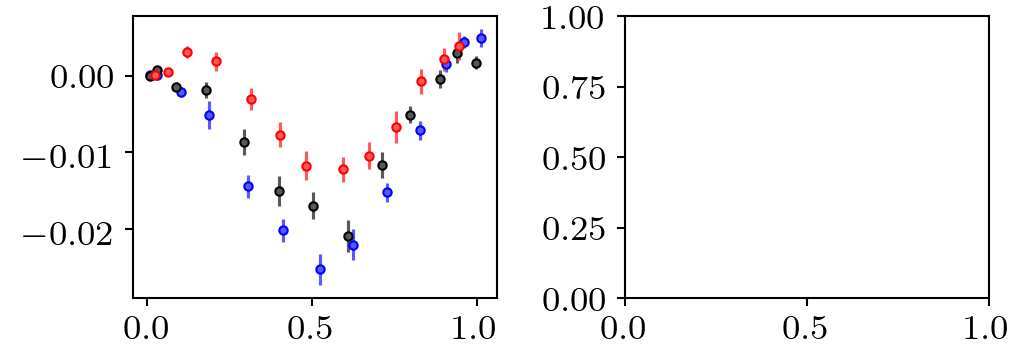

In [18]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(nArr_FigS4_t0,ss01_c_FigS4_t0,
                           xerr = None, yerr = ss01_c_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t1,ss01_c_FigS4_t1,
                           xerr = None, yerr = ss01_c_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t2,ss01_c_FigS4_t2,
                           xerr = None, yerr = ss01_c_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# DQMC data
ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t0[0], DQMCss01_c_FigS4_t0[1], DQMCss01_c_FigS4_t0[2], 
                         facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t1[0], DQMCss01_c_FigS4_t1[1], DQMCss01_c_FigS4_t1[2], 
                         facecolor = xcolors[1], edgecolor = None, alpha = 0.25)
ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t2[0], DQMCss01_c_FigS4_t2[1], DQMCss01_c_FigS4_t2[2], 
                         facecolor = xcolors[2], edgecolor = None, alpha = 0.25)

# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim([nmintoplot,1])
ax_ssij_c_1D.set_ylim([-0.03,0.01])
ax_ssij_c_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$C_{\\rm moment}(1)$", 	labelpad = label_globalpad)


ax_doub_1D.errorbar(nArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([nmintoplot,1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

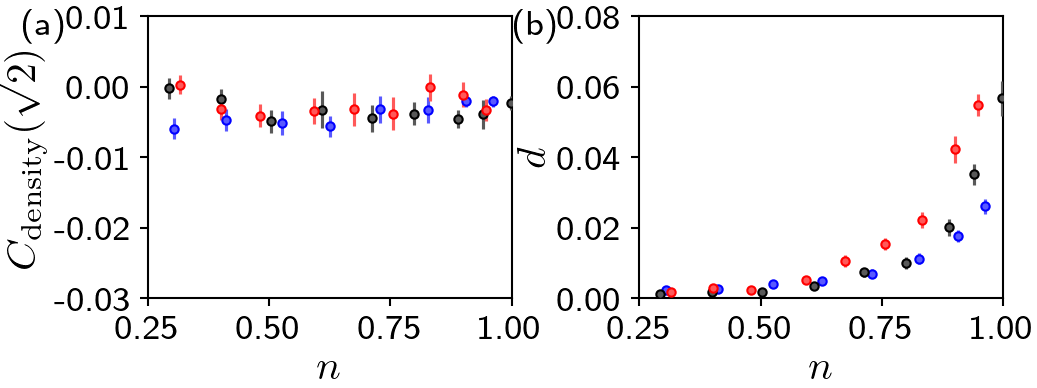

In [19]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(nArr_FigS4_t0,nn11_c_FigS4_t0,
                           xerr = None, yerr = nn11_c_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t1,nn11_c_FigS4_t1,
                           xerr = None, yerr = nn11_c_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t2,nn11_c_FigS4_t2,
                           xerr = None, yerr = nn11_c_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# # DQMC data
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t0[0], DQMCss01_c_FigS4_t0[1], DQMCss01_c_FigS4_t0[2], 
#                          facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t1[0], DQMCss01_c_FigS4_t1[1], DQMCss01_c_FigS4_t1[2], 
#                          facecolor = xcolors[1], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t2[0], DQMCss01_c_FigS4_t2[1], DQMCss01_c_FigS4_t2[2], 
#                          facecolor = xcolors[2], edgecolor = None, alpha = 0.25)

# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim([nmintoplot,1])
ax_ssij_c_1D.set_ylim([-0.03,0.01])
ax_ssij_c_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$C_{\\rm density}(\\sqrt{2})$", 	labelpad = label_globalpad)


ax_doub_1D.errorbar(nArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([nmintoplot,1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

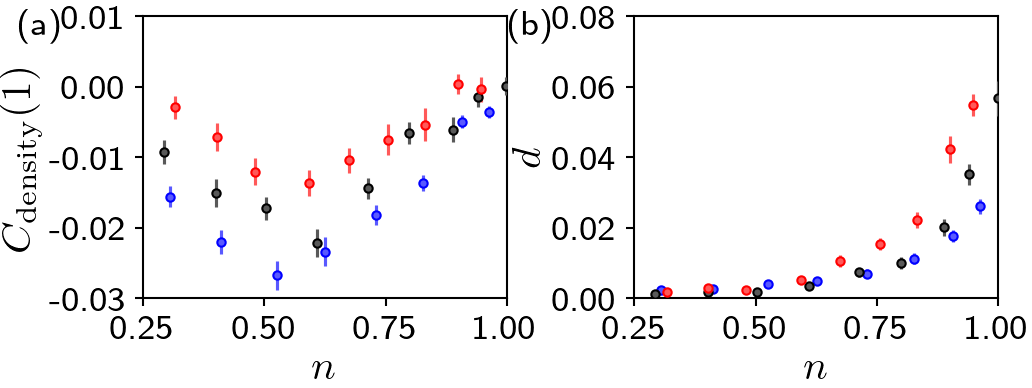

In [20]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(nArr_FigS4_t0,nn01_c_FigS4_t0,
                           xerr = None, yerr = nn01_c_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t1,nn01_c_FigS4_t1,
                           xerr = None, yerr = nn01_c_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t2,nn01_c_FigS4_t2,
                           xerr = None, yerr = nn01_c_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# # DQMC data
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t0[0], DQMCss01_c_FigS4_t0[1], DQMCss01_c_FigS4_t0[2], 
#                          facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t1[0], DQMCss01_c_FigS4_t1[1], DQMCss01_c_FigS4_t1[2], 
#                          facecolor = xcolors[1], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t2[0], DQMCss01_c_FigS4_t2[1], DQMCss01_c_FigS4_t2[2], 
#                          facecolor = xcolors[2], edgecolor = None, alpha = 0.25)

# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim([nmintoplot,1])
ax_ssij_c_1D.set_ylim([-0.03,0.01])
ax_ssij_c_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$C_{\\rm density}(1)$", 	labelpad = label_globalpad)


ax_doub_1D.errorbar(nArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([nmintoplot,1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

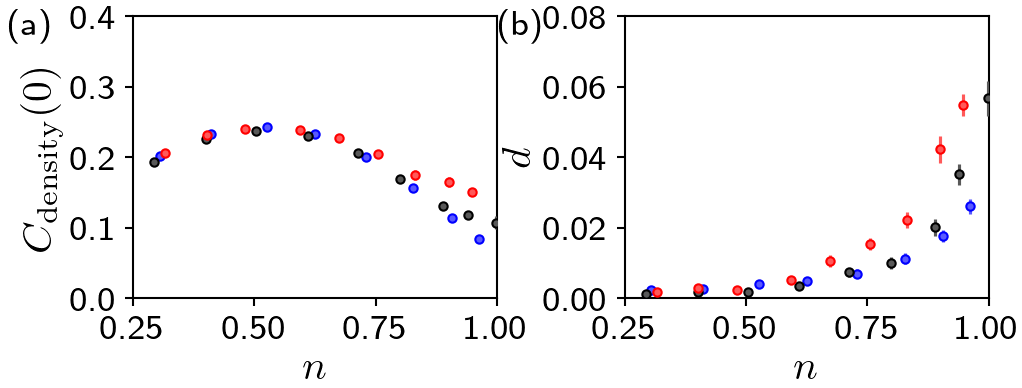

In [21]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(nArr_FigS4_t0,nn00_c_FigS4_t0,
                           xerr = None, yerr = nn00_c_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t1,nn00_c_FigS4_t1,
                           xerr = None, yerr = nn00_c_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS4_t2,nn00_c_FigS4_t2,
                           xerr = None, yerr = nn00_c_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# # DQMC data
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t0[0], DQMCss01_c_FigS4_t0[1], DQMCss01_c_FigS4_t0[2], 
#                          facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t1[0], DQMCss01_c_FigS4_t1[1], DQMCss01_c_FigS4_t1[2], 
#                          facecolor = xcolors[1], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS4_t2[0], DQMCss01_c_FigS4_t2[1], DQMCss01_c_FigS4_t2[2], 
#                          facecolor = xcolors[2], edgecolor = None, alpha = 0.25)

# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim([nmintoplot,1])
ax_ssij_c_1D.set_ylim([0,0.4])
ax_ssij_c_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$C_{\\rm density}(0)$", 	labelpad = label_globalpad)


ax_doub_1D.errorbar(nArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([nmintoplot,1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [ ]:
print(nArr_FigS3_t2,dArr_FigS3_t2)

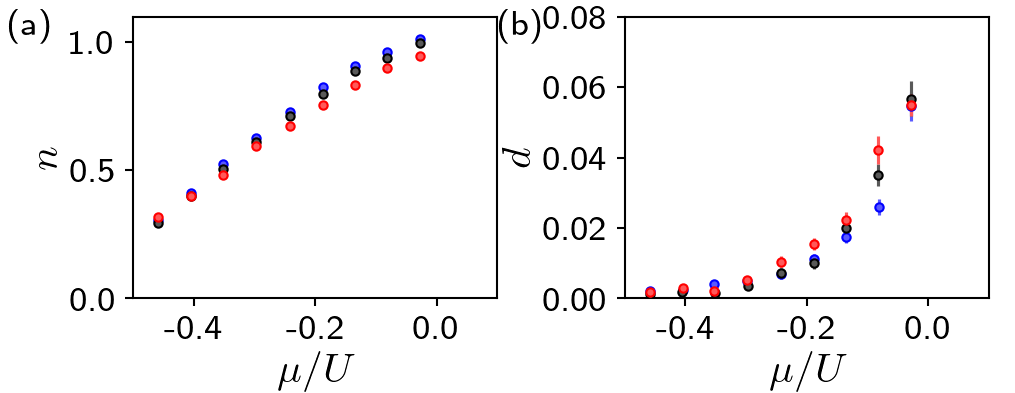

In [22]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(muArr_FigS4_t0,nArr_FigS4_t0,
                           xerr = None, yerr = None,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(muArr_FigS4_t1,nArr_FigS4_t1,
                           xerr = None, yerr = None,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(muArr_FigS4_t2,nArr_FigS4_t2,
                           xerr = None, yerr = None,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim(-0.5,0.1)
ax_ssij_c_1D.set_ylim([0,1.1])
ax_ssij_c_1D.set_xlabel("$\\mu/U$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$n$", 	labelpad = label_globalpad)

ax_doub_1D.errorbar(muArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(muArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(muArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([-0.5,0.1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$\\mu/U$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

0.17667485852452663
0.17385846908749467
0.15480465564607748


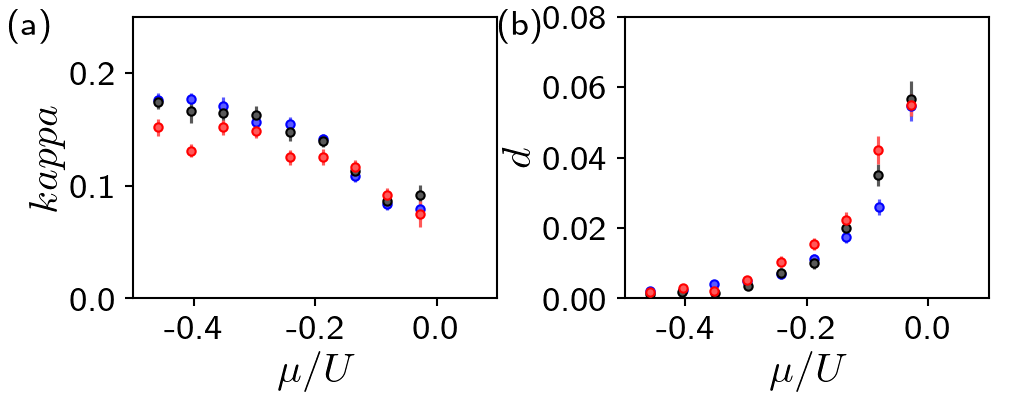

In [24]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
FigS4 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = FigS4.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = FigS4.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = FigS4.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# experiment
ax_ssij_c_1D.errorbar(muArr_FigS4_t0,kappaArr_FigS4_t0,
                           xerr = None, yerr = kappaArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(muArr_FigS4_t1,kappaArr_FigS4_t1,
                           xerr = None, yerr = kappaArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(muArr_FigS4_t2,kappaArr_FigS4_t2,
                           xerr = None, yerr = kappaArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)


print(max(kappaArr_FigS4_t0))
print(max(kappaArr_FigS4_t1))
print(max(kappaArr_FigS4_t2))
# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim(-0.5,0.1)
ax_ssij_c_1D.set_ylim([0,0.25])
ax_ssij_c_1D.set_xlabel("$\\mu/U$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("$kappa$", 	labelpad = label_globalpad)

ax_doub_1D.errorbar(muArr_FigS4_t0,dArr_FigS4_t0,
                           xerr = None, yerr = dArr_err_FigS4_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(muArr_FigS4_t1,dArr_FigS4_t1,
                           xerr = None, yerr = dArr_err_FigS4_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(muArr_FigS4_t2,dArr_FigS4_t2,
                           xerr = None, yerr = dArr_err_FigS4_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([-0.5,0.1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$\\mu/U$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in FigS4.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS4.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [25]:
0.17667485852452663
0.17385846908749467
0.15480465564607748


0.164539
0.14606
0.125955

print(0.17667485852452663/0.164539)
print(0.17385846908749467/0.14606)
print(0.15480465564607748/0.125955)

1.0737567295566806
1.1903222585752065
1.229047323616192


In [ ]:
########## Now plotting figure
    # Can adjust figure size in style area above if you want. 
figAspectRatio = 0.8 ;
figS3 = plt.figure(figsize = [fig_size[0],fig_size[0]/3]) 
# basic drawing region
subplot0 = figS3.add_axes((0,0,1,1), label = str(np.random.rand()))
subplot0.axis('off')  # random things so I can move it in 

ax_ssij_c_1D = figS3.add_subplot(1,2,1, label = str(np.random.rand()))
ax_ssij_c_1D.spines['right'].set_visible(True)
ax_ssij_c_1D.spines['top'].set_visible(True)

ax_doub_1D = figS3.add_subplot(1,2,2, label = str(np.random.rand()))
ax_doub_1D.spines['right'].set_visible(True)
ax_doub_1D.spines['top'].set_visible(True)

nmintoplot = 0.25;

# # experiment
# ax_ssij_c_1D.errorbar(nArr_FigS3_t0,4*nn01_c_FigS3_t0+4*nn11_c_FigS3_t0,
#                            xerr = None, yerr = None,
#                            marker='o', linestyle = '', 
#                            color = xcolors[0], mec = tuple(xedgecolors[0]),
#                   label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
# ax_ssij_c_1D.errorbar(nArr_FigS3_t1,4*nn01_c_FigS3_t1+4*nn11_c_FigS3_t1,
#                            xerr = None, yerr = None,
#                            marker='o', linestyle = '', 
#                            color = xcolors[1], mec = tuple(xedgecolors[1]),
#                   label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
# ax_ssij_c_1D.errorbar(nArr_FigS3_t2,4*nn01_c_FigS3_t2+4*nn11_c_FigS3_t2,
#                            xerr = None, yerr = None,
#                            marker='o', linestyle = '', 
#                            color = xcolors[2], mec = tuple(xedgecolors[2]),
#                   label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
#                   markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# experiment
ax_ssij_c_1D.errorbar(nArr_FigS3_t0,nnij_c_sumsArr_FigS3[0][2],
                           xerr = None, yerr = nnij_c_sumsArr_FigS3[0][5],
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS3_t1,nnij_c_sumsArr_FigS3[1][2],
                           xerr = None, yerr = nnij_c_sumsArr_FigS3[1][5],
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_ssij_c_1D.errorbar(nArr_FigS3_t2,nnij_c_sumsArr_FigS3[2][2],
                           xerr = None, yerr = nnij_c_sumsArr_FigS3[2][5],
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)

# # DQMC data
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS3_t0[0], DQMCss01_c_FigS3_t0[1], DQMCss01_c_FigS3_t0[2], 
#                          facecolor = xcolors[0], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS3_t1[0], DQMCss01_c_FigS3_t1[1], DQMCss01_c_FigS3_t1[2], 
#                          facecolor = xcolors[1], edgecolor = None, alpha = 0.25)
# ax_ssij_c_1D.fill_between(DQMCss01_c_FigS3_t2[0], DQMCss01_c_FigS3_t2[1], DQMCss01_c_FigS3_t2[2], 
#                          facecolor = xcolors[2], edgecolor = None, alpha = 0.25)

# ax_ssij_c_1D.set_yticks([-0.1,0])
# ax_ssij_c_1D.set_xticks([0, 0.5])
ax_ssij_c_1D.set_xlim([nmintoplot,1])
ax_ssij_c_1D.set_ylim([-0.15,0.01])
ax_ssij_c_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_ssij_c_1D.set_ylabel("Nonlocal density corr", 	labelpad = label_globalpad)


ax_doub_1D.errorbar(nArr_FigS3_t0,dArr_FigS3_t0,
                           xerr = None, yerr = dArr_err_FigS3_t0,
                           marker='o', linestyle = '', 
                           color = xcolors[0], mec = tuple(xedgecolors[0]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS3_t1,dArr_FigS3_t1,
                           xerr = None, yerr = dArr_err_FigS3_t1,
                           marker='o', linestyle = '', 
                           color = xcolors[1], mec = tuple(xedgecolors[1]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.errorbar(nArr_FigS3_t2,dArr_FigS3_t2,
                           xerr = None, yerr = dArr_err_FigS3_t2,
                           marker='o', linestyle = '', 
                           color = xcolors[2], mec = tuple(xedgecolors[2]),
                  label = "(0,1)", zorder = 40, linewidth= pgslinewidth, 
                  markersize = pgsmarkersize/1.5, markeredgewidth = pgsmarkeredgewidth)
ax_doub_1D.set_xlim([nmintoplot,1])
ax_doub_1D.set_ylim([0,0.08])
ax_doub_1D.set_xlabel("$n$", 	labelpad = label_globalpad)
ax_doub_1D.set_ylabel("$d$", 	labelpad = label_globalpad)

labelSubplot(ax_ssij_c_1D,'(a)') # Annotate plot as (a), (b), and so on.
labelSubplot(ax_doub_1D,'(b)') # Annotate plot as (a), (b), and so on.

# Draw all plots and convert axis labels to Sans-serif 
    # CAREFUL (have to be done plotting first! so it can draw labels and retrieve them)
for ax_inst in figS3.axes :
    convAxLabelSansSerif(ax_inst, 'both')

########## Save figure and show
    # Don't do bbox = tight or anything like that. We want to save  the figure as is. 
    # Automatic setting is .pdf in style file to preserve highest resolution
# plt.savefig('FigS3.png',transparent=True, bbox_inches='tight', format='png', dpi=globalDPI) 
# shouldnt have to worry about DPI since images were loaded without interpolation
plt.show() # Can comment this out if you want. 

In [ ]:
# Save relevant data to files
np.savetxt('doublonDensity_t=0.txt', [nArr_FigS3_t0,dArr_FigS3_t0,dArr_err_FigS3_t0], delimiter =', ',fmt='%.18f')
np.savetxt('doublonDensity_t=1.txt', [nArr_FigS3_t1,dArr_FigS3_t1,dArr_err_FigS3_t1], delimiter =', ',fmt='%.18f')
np.savetxt('doublonDensity_t=2.txt', [nArr_FigS3_t2,dArr_FigS3_t2,dArr_err_FigS3_t2], delimiter =', ',fmt='%.18f')

np.savetxt('momentMoment_t=0.txt', [nArr_FigS3_t0,ss01_c_FigS3_t0,ss01_c_err_FigS3_t0], delimiter =', ',fmt='%.18f')
np.savetxt('momentMoment_t=1.txt', [nArr_FigS3_t1,ss01_c_FigS3_t1,ss01_c_err_FigS3_t1], delimiter =', ',fmt='%.18f')
np.savetxt('momentMoment_t=2.txt', [nArr_FigS3_t2,ss01_c_FigS3_t2,ss01_c_err_FigS3_t2], delimiter =', ',fmt='%.18f')

np.savetxt('densityDensity_t=0.txt', [nArr_FigS3_t0,nn01_c_FigS3_t0,nn01_c_err_FigS3_t0], delimiter =', ',fmt='%.18f') 
np.savetxt('densityDensity_t=1.txt', [nArr_FigS3_t1,nn01_c_FigS3_t1,nn01_c_err_FigS3_t1], delimiter =', ',fmt='%.18f') 
np.savetxt('densityDensity_t=2.txt', [nArr_FigS3_t2,nn01_c_FigS3_t2,nn01_c_err_FigS3_t2], delimiter =', ',fmt='%.18f') 

np.savetxt('nonlocal_t=0.txt', [nArr_FigS3_t0,nnij_c_sumsArr_FigS3[0][2],nnij_c_sumsArr_FigS3[0][5]], delimiter =', ',fmt='%.18f') 
np.savetxt('nonlocal_t=1.txt', [nArr_FigS3_t1,nnij_c_sumsArr_FigS3[1][2],nnij_c_sumsArr_FigS3[1][5]], delimiter =', ',fmt='%.18f') 
np.savetxt('nonlocal_t=2.txt', [nArr_FigS3_t2,nnij_c_sumsArr_FigS3[2][2],nnij_c_sumsArr_FigS3[2][5]], delimiter =', ',fmt='%.18f') 
